# Introduction

**Objectif et démarche:**


L'objectif de ce notebook est d'établir un modèle de scoring qui indique si un individu est susceptible de rembourser son prêt ou pas. Pour cela, nous disposons d'un dataset principal et de 6 autres tableaux. Ces données sont fournies par **Home Credit**, un service de prêt à la consommation. Le tableaux principal contient la cible ("TARGET") et des informations concernant le demandeur de prêt et le prêt en lui-même. La cible est une variable binaire: **0** si la personne a remboursé son prêt et **1** si la personne a fait défaut. Les autres tableaux contiennent des informations annexes comme des demandes de prêt antérieures dans d'autres banques. Nous concentrons notre travail sur le dataset principal. Si nous devions nous servir des autres dataset, nous expliquerons en détails pourquoi.

# I. Analyse exploratoire

## I.A. Analyse de forme.

L'objectif de cette sous-partie est d'étudier la forme du dataset ce qui comprend:
- ses dimensions,
- ses valeurs manquantes,
- le type des variables qu'il contient,
- le traitement des lignes dupliquées,
- le traitement des colonnes dupliquées.

---
**Récupération des données**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns

# Récupération de df

import pickle   
with open('df', 'rb') as fichier:
    df_depickler = pickle.Unpickler(fichier)
    df = df_depickler.load()

---

In [2]:
# Aperçu des premières lignes du tableau
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
1,100002,1,Cash loans,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,100003,0,Cash loans,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0,Revolving loans,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,100006,0,Cash loans,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,100007,0,Cash loans,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Dimensions du tableau
df.shape

(307511, 122)

In [4]:
# Types des variables
df.dtypes.value_counts()

float64    65
int64      43
object     14
dtype: int64

In [5]:
# Variables binaires
s = 0
for col in df.columns:
    if len(df[col].unique())==2:
        s+=1
print('Il y a {} variables binaires.'.format(s))

# Variables binaires et qualitatives
s = 0
for col in df.columns:
    if ((len(df[col].unique())==2)&(df[col].dtypes == 'object')):
        s+=1
print('Dont {} variable qualitative.'.format(s))

Il y a 36 variables binaires.
Dont 1 variable qualitative.


**Analyse de forme:**
- Dimension tableau: 
    - 307 511 lignes
    - 122 colonnes
- Variables quantitatives et qualitatives:
    - Il y a 65 variables quantitatives continues.
    - Il y a 43 variables quantitatives discrètes dont 35 binaires.
    - Il y a 14 variables qualitatives dont 1 binaire dont on va de suite analyser les modalités.

In [6]:
# Variables binaires et qualitatives: modalités
for col in df.columns:
    if ((len(df[col].unique())==2)&(df[col].dtypes == 'object')):
        print('{} est binaire et prend comme valeurs:\n {}.'.format(col,df[col].unique()))

NAME_CONTRACT_TYPE est binaire et prend comme valeurs:
 ['Cash loans' 'Revolving loans'].


Pour que l'analyse exploratoire soit plus claire nous allons garder les modalités telles qu'elles sont sans les encoder.

Nous allons maintenant observer les **valeurs manquantes de notre tableau grâce à une heatmap.**

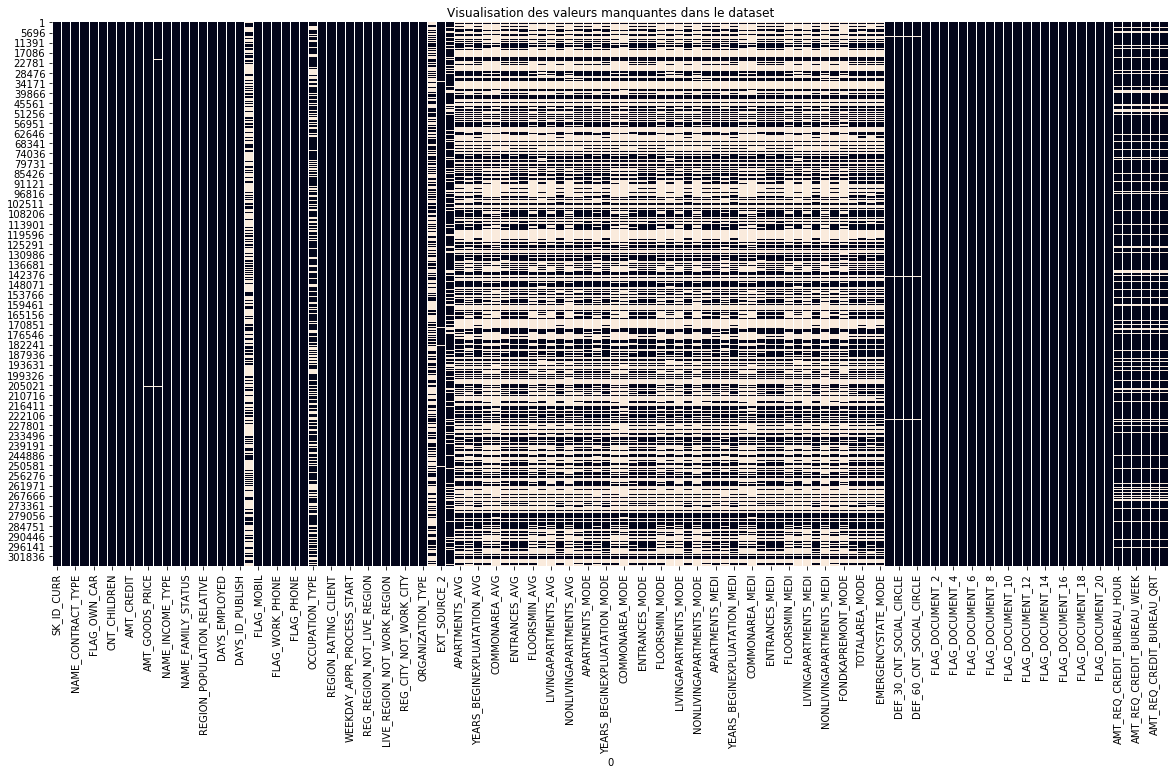

In [7]:
# Heatmap, visualisation des valeurs manquantes dans le tableau
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)
plt.title('Visualisation des valeurs manquantes dans le dataset')
plt.savefig('heatmap_missing_values_1.png')

**Valeurs manquantes:**

Identifier les barres blanches sur la heatmap pemet de voir quelles sont les variables qui forment des groupes. Sur la heatmap ci-dessus on constate plusieurs choses:
- AVG, MEDI, MODE semblent présenter plus de valeurs manquantes que les autres variables.
- AMT_REQ_CREDIT ont le même nombre de valeurs manquantes.
- Aucune variable ne semble avoir un très grand nombre de valeurs manquantes.

In [8]:
# Fonction qui permet d'afficher un tableau regroupant les colonnes et leurs valeurs manquantes
def missing_frame(df):
    missing_df=pd.DataFrame()
    missing_df['nom_colonne']=df.isna().sum().sort_values(ascending=[False]).index
    missing_df['nbr_val_manquantes']=df.isna().sum().sort_values(ascending=[False]).values
    missing_df['%_de_valeurs_manquantes']=np.around((missing_df['nbr_val_manquantes']/len(df))*100, 1)
    return missing_df

In [9]:
# Valeurs manquantes de df
missing_df = missing_frame(df)

In [10]:
# Affichage des colonnes qui ont plus de 50% de valeurs manquantes
missing_df[missing_df['%_de_valeurs_manquantes']>=50]

,nom_colonne,nbr_val_manquantes,%_de_valeurs_manquantes
0,COMMONAREA_MEDI,214865,69.9
1,COMMONAREA_AVG,214865,69.9
2,COMMONAREA_MODE,214865,69.9
3,NONLIVINGAPARTMENTS_MODE,213514,69.4
4,NONLIVINGAPARTMENTS_MEDI,213514,69.4
5,NONLIVINGAPARTMENTS_AVG,213514,69.4
6,FONDKAPREMONT_MODE,210295,68.4
7,LIVINGAPARTMENTS_MEDI,210199,68.4
8,LIVINGAPARTMENTS_MODE,210199,68.4
9,LIVINGAPARTMENTS_AVG,210199,68.4


Comme nous pouvions le voir sur la heatmap:
- les variables de type MODE, AVG et MEDI sont les moins remplies,
- aucune variable n'a plus de 70% de valeurs manquantes.

Pour conclure cette analyse de forme, nous allons nous assurer qu'il n'y a pas de **ligne et de colonne dupliquée.** S'il y en a, nous les traiterons.

In [11]:
# Colonnes dupliquées
s = 0
for col in df.columns:
    result = np.where(df.columns.values==col)
    if len(result[0])!=1:
        s+=1
        print('{} aux indices : {} '.format(col, result[0]))
if s==0:
    print("Il n'y a pas de colonne dupliquée.")

Il n'y a pas de colonne dupliquée.


In [12]:
# Lignes entières dupliquées
print("Nombre de lignes dupliquées: {} ".format(df.duplicated().sum()))

Nombre de lignes dupliquées: 0 


Maintenant que nous connaissons un peu mieux la forme de notre tableau nous allons passer à l'analyse de fond

---
**Enregistrement de df**

In [13]:
with open('df', 'wb') as fichier:
    df_pickler = pickle.Pickler(fichier)
    df_pickler.dump(df)

---

## I.B. Première analyse de fond

L'objectif de cette partie est d'analyser la forme de notre **target** mais également de **réduire le nombre de colonnes** de notre tableau en ne gardant que les variables les plus pertinentes et en limitant au maximum la perte d'informations.

**Forme de la Target.**

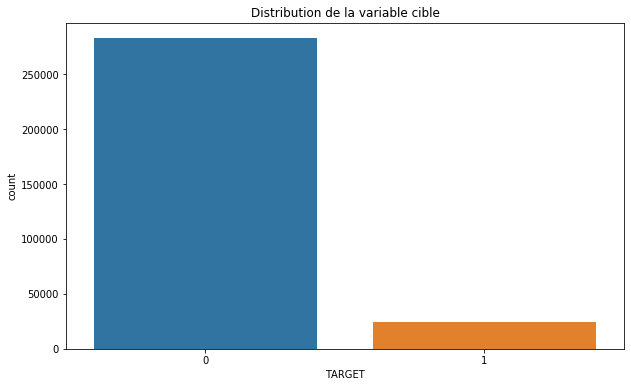

In [14]:
# Distribution de la target
plt.figure(figsize=(10,6))
sns.countplot(x='TARGET', data=df)
plt.title('Distribution de la variable cible')
plt.savefig('Distribution_target.png')

In [15]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [16]:
# Pourcentage d'individus ayant fait défaut.
p = np.around((df['TARGET'].value_counts()[1]/df['TARGET'].value_counts()[0])*100, 2)
print('Il y a {}% des demandeurs de crédit qui ont fait défaut.'.format(p))

Il y a 8.78% des demandeurs de crédit qui ont fait défaut.


**Analyse:**<br/>
La distribution de la variable cible est **très déséquilibrée.** En effet, il y a moins de 10% des demandeurs de prêt qui on fait défaut. Cette information est primordiale et devra être prise en compte lors de l'élaboration des modèles de machine learning afin de ne pas avoir des modèles erronés.

**Les groupes de variables.**<br/>
Le dataset est très grand, il possède 122 variables. Notre but est de réduire la dimension du tableau en ne gardant que les variables les plus importantes et en éliminant les redondances d'information. Afin d'optimiser l'analyse des variables et de traquer au mieux la redondance d'information, nous allons étudier les variables par groupes. Ces groupes ont été établis à partir des descriptions des colonnes qui sont fournies avec le dataset mais également grâce à l'analyse de forme que nous avons effectuée dans la sous-partie précédente.

In [17]:
# Montants
montant_df = ex.selection_variables(df, ['AMT_'])

# Nombres
nombre_df = ex.selection_variables(df, ['CNT_'])

# Signalé.e
flag_df = ex.selection_variables(df, ['FLAG_'])

# Numerical informations
num_information_df = ex.selection_variables(df, ['_MEDI', '_MODE','_AVG'])

# Noms
nom_df = ex.selection_variables(df, ['NAME_'])

# Scores
score_df = ex.selection_variables(df, ['EXT_SOURCE_'])

In [18]:
# Autres variables
variables_a_supprimer = list(montant_df.columns)  + list(nombre_df.columns) + list(flag_df.columns) + list(num_information_df.columns) + list(nom_df.columns) + list(score_df.columns)
autres_variables_df = df.drop(variables_a_supprimer, axis=1)

**Types des variables présentes dans les groupes.**<br/>
Afficher les types des groupes de variables nous permettra de choisir les bons graphiques pour leurs représentation.

In [19]:
# FLAG
flag_df.dtypes.value_counts()

int64    28
dtype: int64

In [20]:
# AVG, MEDI, MODE
num_information_df.dtypes.value_counts()

float64    43
object      4
dtype: int64

In [21]:
# AMT
montant_df.dtypes.value_counts()

float64    10
dtype: int64

In [22]:
# CNT
nombre_df.dtypes.value_counts()

float64    5
int64      1
dtype: int64

In [23]:
#SCORE
score_df.dtypes.value_counts()

float64    3
dtype: int64

In [24]:
# NAME
nom_df.dtypes.value_counts()

object    6
dtype: int64

In [25]:
# Autres variables
autres_variables_df.dtypes.value_counts()

int64      14
float64     4
object      4
dtype: int64

### FLAG, AVG, MEDI & MODE 

**Documents fournis.**

In [26]:
# Copie du dataset
df1 = df.copy()

In [27]:
# Affichage des premières lignes
flag_df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
1,0,1,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Documents fournis
flag_doc_df = ex.selection_variables(flag_df, ['DOCUMENT'])

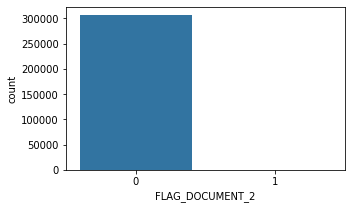

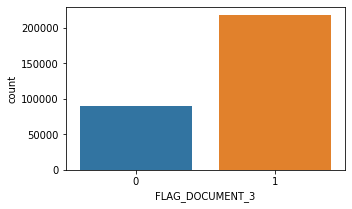

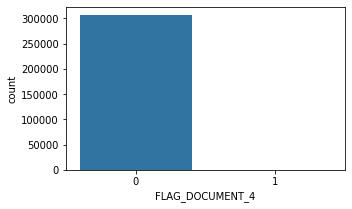

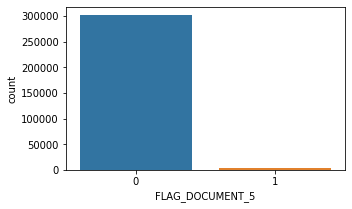

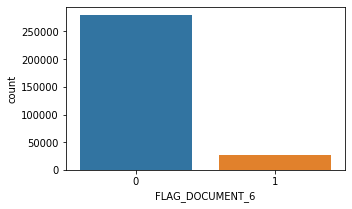

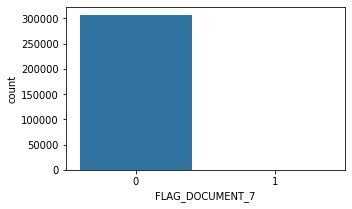

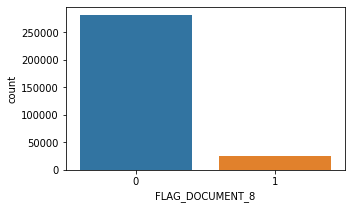

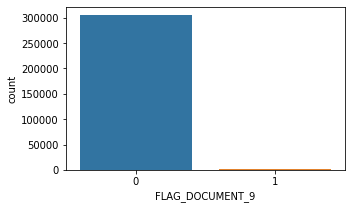

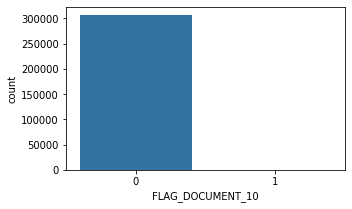

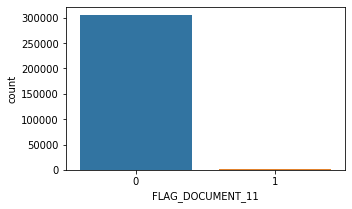

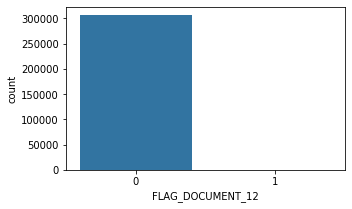

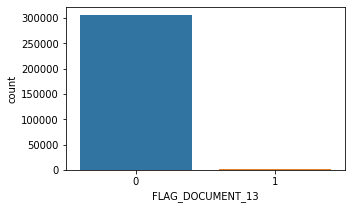

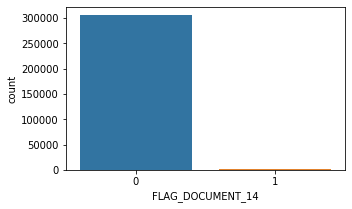

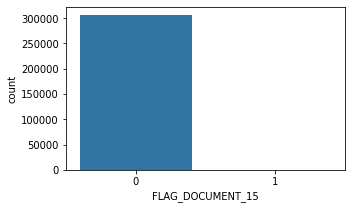

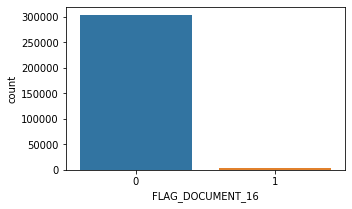

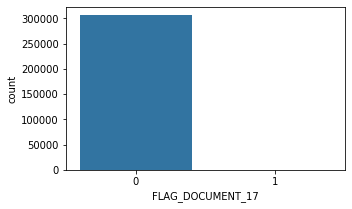

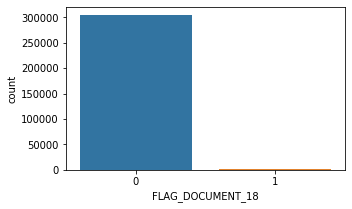

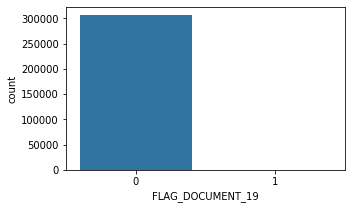

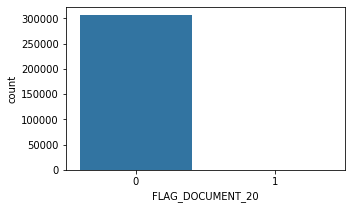

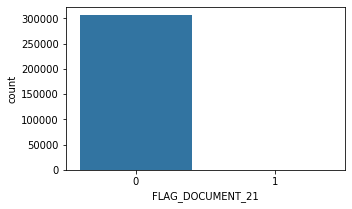

In [29]:
# Distributions des variables "document fourni"
for col in flag_doc_df.columns:
    plt.figure(figsize=(5,3))
    sns.countplot(x=flag_doc_df[col], data=flag_doc_df)

Les individus fournissent beaucoup plus le document 3 que les autres documents. 

In [30]:
# Valeurs manquantes pour ces colonnes.
for col in flag_doc_df.columns:
    if df1[col].isna().sum() != 0:
        print(col)

Il n'y a pas de valeurs manquantes pour les colonnes de type FLAG.

On crée une variable qui indique le nombre de documents fournis par le demandeur de prêt: "nombre_doc_fournis".

In [31]:
# Nombre de documents fournis par l'individu
df1['nombre_doc_fournis'] = flag_doc_df.sum(axis=1)

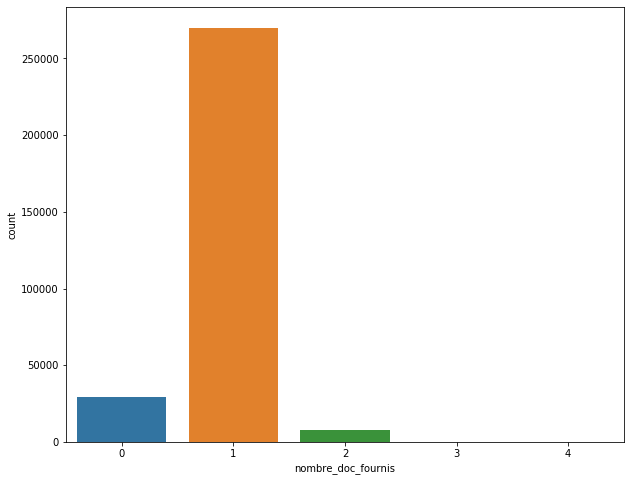

In [32]:
# Distribution de la variable "nombre de documents fournis"
plt.figure(figsize=(10,8))
sns.countplot(x=df1['nombre_doc_fournis'], data=df1)

In [33]:
# Effectifs de chaque classe de la variable "nombre de documents fournis"
df1['nombre_doc_fournis'].value_counts()

1    270056
0     29549
2      7742
3       163
4         1
Name: nombre_doc_fournis, dtype: int64

In [34]:
# Suppression des colonnes flag_doc sauf pour le doc 3
document_colonnes = flag_doc_df.drop('FLAG_DOCUMENT_3', axis=1).columns
df1.drop(document_colonnes, axis=1,inplace=True)

**Biens du client.**

In [38]:
# Ce que le client possède
biens_client_df = flag_df.drop(flag_doc_df.columns, axis=1)

In [39]:
# Apperçu du tableau
biens_client_df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL
1,0,1,1,1,0,1,1,0
2,0,0,1,1,0,1,1,0
3,1,1,1,1,1,1,1,0
4,0,1,1,1,0,1,0,0
5,0,1,1,1,0,1,0,0


**Analyse:**<br/>
Les variables les plus importantes parmi ces variables sont les variables "FLAG_OWN_REALTY" et "FLAG_OWN_CAR" qui indiquent si la personne a un logement ou pas et si la personne a une voiture ou pas. En effet, en cas de défaut la banque pourra toujours saisir la voiture et/ou le logement de la personne. C'est une garantie indirecte. Ces deux variables vont nous permettre de juger si une personne risque de faire perdre beaucoup d'argent à la banque ou non en cas de défaut. De plus, ces deux variables seront intéressantes à étudier en parallèle de la variable cible car intuitivement on pourrait se dire qu'une personne ayant une voiture et un logement a surement une situation stable et donc serait moins susceptible de faire défaut.

In [40]:
# Suppression de toutes les colonnes sauf "REALTY" et "CAR"
biens_colonnes = biens_client_df.drop(["FLAG_OWN_REALTY","FLAG_OWN_CAR"], axis=1).columns
df1.drop(biens_colonnes, axis=1,inplace=True)

In [41]:
# Dimensions de df1 après traitement des variables de type "FLAG"
df1.shape

(307511, 98)

**Colonnes de documents fournis:**
- Le document le plus fourni est le document 3.
- Les individus fournissent entre 0 et 4 documents.
- Le nombre de documents fournis a été mis dans la variable "nombre_doc_fournis".
- La variable "FLAG_DOCUMENT_3" a été conservée uniquement afin de l'étudier en fonction de la target, cette variable sera amenée à être supprimée lors de la phase de machine learning.

**On sait donc:**<br/>
- si un individu n'a pas fourni de document,
- si un individu n'a fourni que le document 3,
- si un individu n'a pas fourni le document 3 mais d'autres documents,
- si un individu a fourni le document 3 et d'autres documents.

**Le df1:**<br/>
- possède **98** colonnes car les colonnes "FLAG_DOCUMENT" ont été supprimées sauf  "FLAG_DOCUMENT_3" ,
- possède la colonne "nombre_doc_fournis".
- les colonnes qui indiquent si la personne possède une voiture et/ou un logement ont été conservées.

---
**Enregistrement de df1**

In [42]:
import pickle

with open('df1', 'wb') as fichier:
    df1_pickler = pickle.Pickler(fichier)
    df1_pickler.dump(df1)

---

**AVG, MEDI et MODE**

In [43]:
# Copie de df1
df2 = df1.copy()

In [44]:
# Quelles sont les colonnes de type objet parmi les colonnes AVG, MODE et MEDI ? Quelles sont leurs modalités ?
for col in num_information_df.columns[num_information_df.dtypes == 'object']:
    print('\n {}:\n{}'.format(col, num_information_df[col].unique()))


 FONDKAPREMONT_MODE:
['reg oper account' nan 'org spec account' 'reg oper spec account'
 'not specified']

 HOUSETYPE_MODE:
['block of flats' nan 'terraced house' 'specific housing']

 WALLSMATERIAL_MODE:
['Stone, brick' 'Block' nan 'Panel' 'Mixed' 'Wooden' 'Others' 'Monolithic']

 EMERGENCYSTATE_MODE:
['No' nan 'Yes']


In [45]:
# Trois tableaux AVG / MODE / MEDI
avg_df = ex.selection_variables(num_information_df, ['_AVG'])
mode_df = ex.selection_variables(num_information_df, ['_MODE'])
medi_df = ex.selection_variables(num_information_df, ['_MEDI'])

# On enlève les 4 colonnes de types objets ou catégorielles pour le tableau MODE
mode_df = mode_df.drop(num_information_df.columns[num_information_df.dtypes == 'object'], axis=1)

# Liste avec les trois tableaux
liste_tab = [avg_df,mode_df,medi_df]

# Affichage des variables de ces trois tableaux
for tab in liste_tab:
    print('\n',tab.columns)


 Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG'],
      dtype='object', name=0)

 Index(['APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE',
       'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE',
       'NONLIVINGAREA_MODE', 'TOTALAREA_MODE'],
      dtype='object', name=0)

 Index(['APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI',
       'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
       'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI'

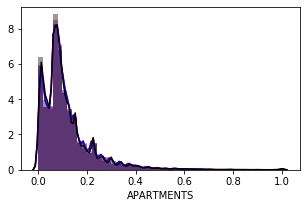

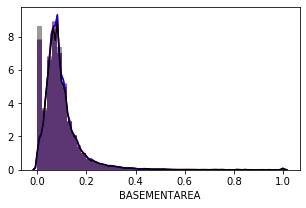

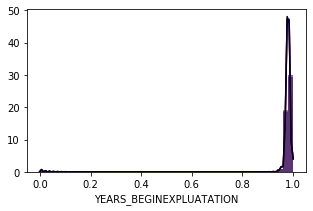

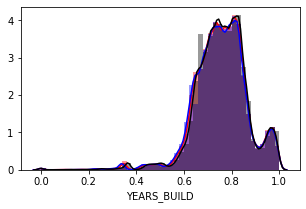

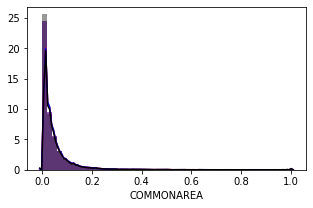

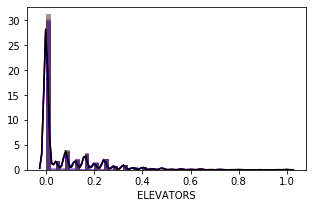

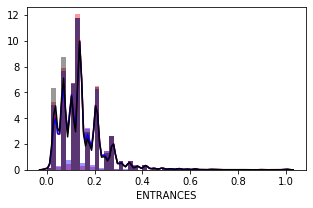

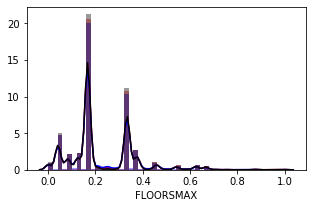

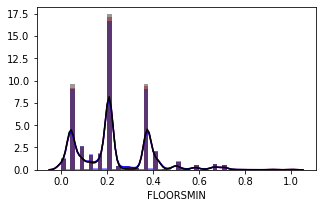

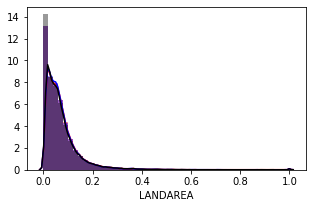

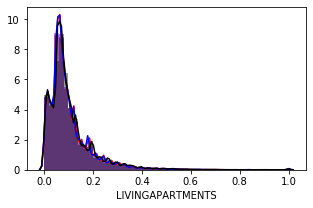

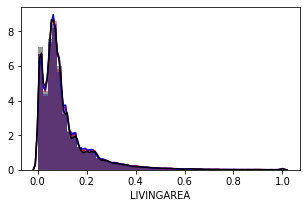

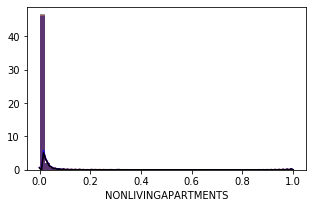

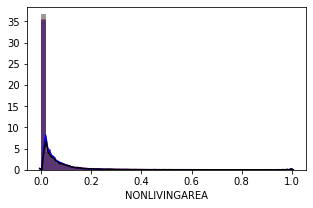

In [46]:
# Y-a-t-il une redondance d'information entre ces variables ?

# Les 3 tableaux ont les mêmes colonnes aux mêmes indices (à l'exception de TOTALAREA_MODE)
for index, col in enumerate(medi_df.columns):
    plt.figure(figsize=(5,3))
    sns.distplot(medi_df[col], color='r')
    sns.distplot(avg_df[avg_df.columns[index]], color='b')
    sns.distplot(mode_df[mode_df.columns[index]], color='k')
    plt.xlabel(col[:-5])

**Analyse:**<br/>
Les distributions sont identiques pour les trois types de variables: AVG, MODE et MEDI. On ne va garder que les colonnes "average" car la moyenne est une valeur plus facile à communiquer. On ne garde pour l'instant que la variable TOTALAREA_MODE en plus des variables AVG.

In [47]:
colonnes_a_supprimer = list(medi_df.columns) + list(mode_df.columns[:-1])

# Suppression des variables _MEDI et _MODE dans df2
df2 = df2.drop(colonnes_a_supprimer, axis=1)

**Traiter les variables de type AVG.**<br/>
Les variables de type "AVG" sont des variables très précises qui donnent des informations sur l'endroit où le client vit. La précision de ces informations ne sera surement pas nécesaire pour la prédiction de la cible. On va plutôt chercher parmi ces variables celle qui les résume le mieux. 

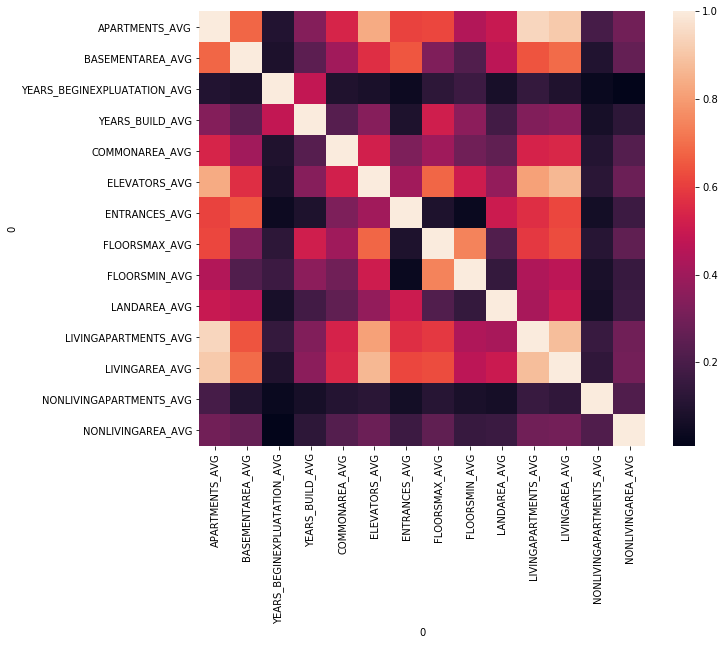

In [48]:
# Clustermap des variables de type AVG
corr = avg_df.corr().dropna(axis=0)

plt.figure(figsize=(10,8))
sns.heatmap(corr)

**Pour synthétiser ces variables**:<br/>
- On peut garder la variable LIVINGAREA seule.
- Cette variable est celle qui a les coefficients de corrélations les plus élevés avec les autres variables (ligne la plus claires sur la heatmap).
- On pourra étudier l'évolution de la variable target en fonction de cette variable ou inversement.

In [49]:
# Sélection des variables à supprimer (on enlève LIVINGAREA)
colonnes_a_supprimer = list(avg_df.columns[:-3]) + list(avg_df.columns[-2:])

In [50]:
# Suppression des variables AVG sauf "LIVINGAREA"
df2 = df2.drop(colonnes_a_supprimer, axis=1)

In [51]:
# Dimensions finales de df2
df2.shape

(307511, 57)

**Colonnes AVG, MEDI et MODE:**
- 3 types de colonnes qui avaient toutes la même distribution (à l'exception d'une variable).
- Seule la variable TOTALAREA_MODE était en présente en plus des autres.
- On a gardé les variables TOTALAREA_MODE et LIVINGAREA_AVG
- On a gardé les 4 variables de type "object".

**Le df2:**
- Possède 57 colonnes dont la variable créée "nombre_doc_fournis".
- Aucune colonne n'a été ajoutée par rapport à df1.

---
**Enregistrement de df1 et df2**

In [52]:
import pickle

with open('df1', 'wb') as fichier:
    df1_pickler = pickle.Pickler(fichier)
    df1_pickler.dump(df1)
    
with open('df2', 'wb') as fichier:
    df2_pickler = pickle.Pickler(fichier)
    df2_pickler.dump(df2)

---

### AMT, CNT & SCORES

**Type AMT**

In [53]:
# Copie de df2
df3 = df2.copy()

In [54]:
# Affichage des colonnes
montant_df.columns

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', name=0)

**Constat:**


Deux catégories de colonnes se distinguent parmi les colonnes de type "AMT" :
- les quantités d'argent,
- "la quantité" de demandes de demandes de prêts 

**Nombre de demandes de prêt**

In [55]:
# On ne garde que les variables qui correspondent à des demandes de prêt
demande_pret_df = montant_df.loc[:, montant_df.columns[4:]]

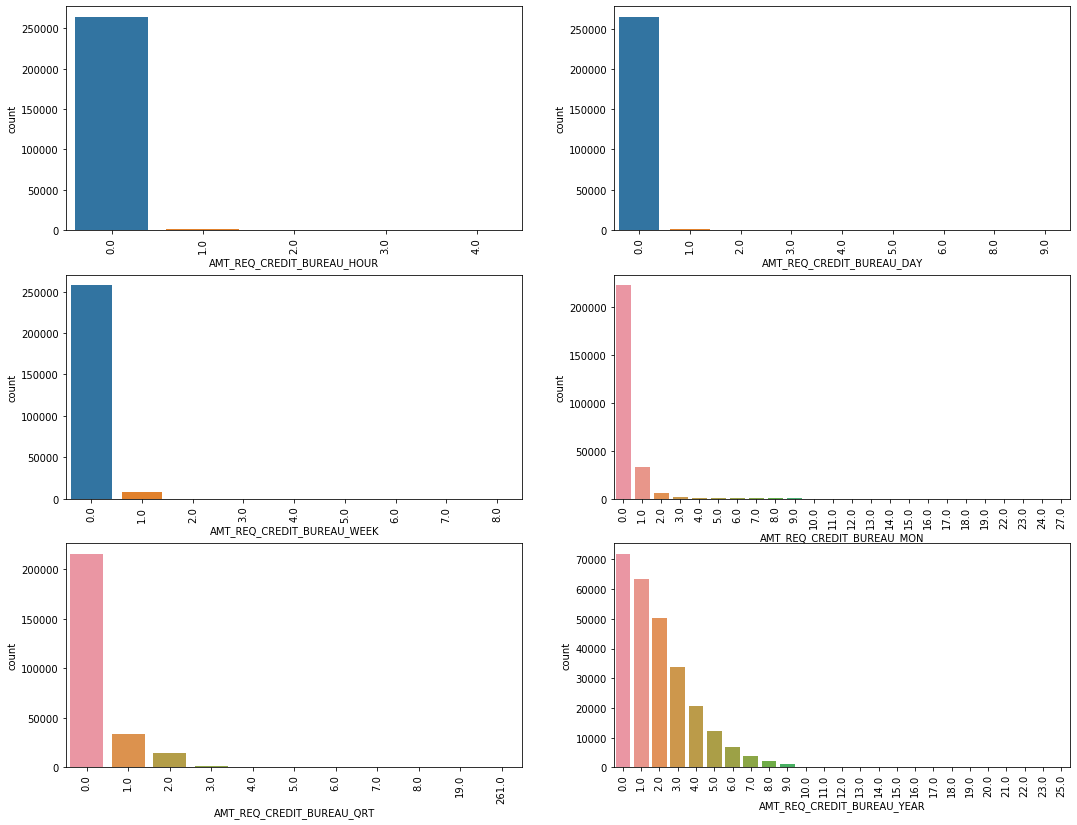

In [58]:
# Distributions des variables "demandes de prêt"
plt.figure(figsize=(18,14))
for index, col in enumerate(demande_pret_df.columns):
    plt.subplot(3,2,index+1)
    sns.countplot(x=demande_pret_df[col], data=demande_pret_df)
    plt.xticks(rotation=90)

**Analyse:**
- On constate que plus l'échelle de temps augmente plus il y a de modalités. Certaines personnes ont fait jusqu'à 25 demandes de crédits dans l'année. 
- On peut synthétiser ces variables en ne gardant qu'une échelle de temps par exemple en ne gardant que la plus grande puisqu'elle est censée contenir l'information des échelles plus petites.
- Cette variable va être utile pour définir un profil de client à qui il sera plus "dangereux" d'accorder un crédit car ils risquent de ne pas le rembourser: **cas de faux-négatif dangereux**. On peut faire une variable qui indique si le client fait partie de 10% à avoir fait plus de x demandes de prêts dans l'année. On appellera cette variable **demandeur récurrent**.
- Il y un outlier pour la variable _QRT avec 261 demandes mais on va supprimer cett variable donc ça n'a pas d'importance.
- On étudiera les potentielles relations entre AMT_REQ_CREDIT_BUREAU_YEAR et la TARGET.

In [59]:
# On ne garde que la variable AMT_REQ_CREDIT_BUREAU_YEAR
variables_a_supprimer = demande_pret_df.columns[:-1]
df3 = df3.drop(variables_a_supprimer, axis=1)

In [60]:
# Tableau qui indique la fréquence de chaque modalité et les fréquence cumulée.
tab_demande_pret = pd.DataFrame()
tab_demande_pret["Nb demandes année"] = demande_pret_df["AMT_REQ_CREDIT_BUREAU_YEAR"].value_counts().index
tab_demande_pret["Freq"] = np.around(demande_pret_df["AMT_REQ_CREDIT_BUREAU_YEAR"].value_counts().values / demande_pret_df["AMT_REQ_CREDIT_BUREAU_YEAR"].value_counts().sum(axis=0), 3)*100
tab_demande_pret["Freq cumulées"] = tab_demande_pret["Freq"].cumsum()
tab_demande_pret

,Nb demandes année,Freq,Freq cumulées
0,0.0,27.0,27.0
1,1.0,23.8,50.8
2,2.0,18.9,69.7
3,3.0,12.6,82.3
4,4.0,7.8,90.1
5,5.0,4.5,94.6
6,6.0,2.6,97.2
7,7.0,1.5,98.7
8,8.0,0.8,99.5
9,9.0,0.4,99.9


On constate que **90%** des individus ont fait **au maximum 4 demandes** de crédits dans l'année. On fait donc la variable demandeur récurrent qui indique si la personne a fait 4 demandes de prêt dans l'année ou plus.

In [61]:
# Fonction qui indique si la personne a fait au moins 4 demandes de prêt dans l'année
def demandes_recurrentes(df):
    """1 = demandeur récurrent
        0 = RAS """
    if df['AMT_REQ_CREDIT_BUREAU_YEAR'] >= 4:
        return 1
    else:
        return 0

In [62]:
# Variable qui indique si la personne a fait au moins 4 demandes de prêt dans l'année
df3['demandeur_recurrent'] = df3.apply(demandes_recurrentes, axis=1)

**Revenus, montant du crédit, montant des biens achetés grâce au crédit & annuité**

In [63]:
# On sélectionne ces colonnes
quantite_argent_df = montant_df.drop(montant_df.columns[4:], axis=1) 

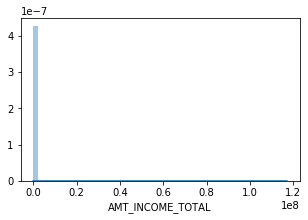

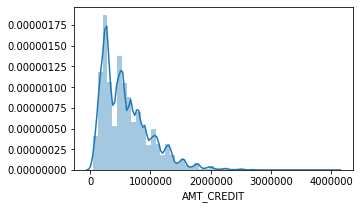

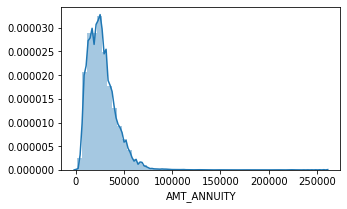

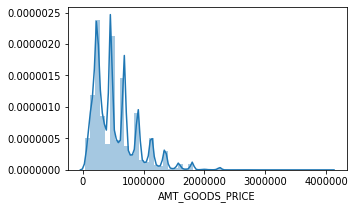

In [64]:
# On affiche la distribution de ces colonnes
for col in quantite_argent_df.columns:
    plt.figure(figsize=(5,3))
    sns.distplot(quantite_argent_df[col])

**Analyse:**
- Il y a surement des outliers avec la variable AMT_INCOME_TOTAL.
- Les 4 autres variables sont très importantes et ne semblent pas, à première vue, pouvoir être synthétisées. 
- AMT_CREDIT = somme prêtée.
- AMT_ANNUITY = somme à rembourser annuellement.
- AMT_GOODS_PRICE = montant des biens qui sont censés être achetés avec le crédit.

In [65]:
# Description de la colonne AMT_INCOME_TOTAL
quantite_argent_df["AMT_INCOME_TOTAL"].describe()

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

Le revenu des individus faisant la demande de prêt va de **25 600** dollars à **117 000 000** dollars par an.

In [66]:
k = quantite_argent_df["AMT_INCOME_TOTAL"].quantile(q=0.95)
print("5% des individus gagne {}$ ou plus par an.".format(int(k)))
print("La variable AMT_INCOME_TOTAL a {} modalités.".format(len(quantite_argent_df["AMT_INCOME_TOTAL"].unique())))

5% des individus gagne 337500$ ou plus par an.
La variable AMT_INCOME_TOTAL a 2548 modalités.


In [87]:
# La personne ayant les plus gros revenus, a-t-elle fait défaut ?
df3[(df3["AMT_INCOME_TOTAL"] == 117000000)&(df3["TARGET"]==1)]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_YEAR,nombre_doc_fournis,demandeur_recurrent
12841,114967,1,Cash loans,F,0,1,1,117000000.0,562491.0,26194.5,...,No,0.0,0.0,0.0,0.0,0.0,1,1.0,1,0


In [88]:
# On calcule la valeur à partir de laquelle on considèrera les outliers.
IQ = quantite_argent_df["AMT_INCOME_TOTAL"].quantile(q=0.75) - quantite_argent_df["AMT_INCOME_TOTAL"].quantile(q=0.25)
Q3 = quantite_argent_df["AMT_INCOME_TOTAL"].quantile(q=0.75)
borne_outliers = Q3 + 1.5*IQ
print("Au dessus de {}, les valeurs sont considérées comme des outliers.".format(int(borne_outliers)))

Au dessus de 337500, les valeurs sont considérées comme des outliers.


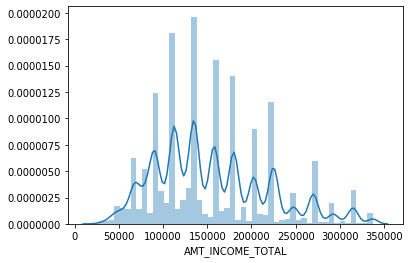

In [89]:
# Distribution de AMT_INCOME_TOTAL
mask = quantite_argent_df["AMT_INCOME_TOTAL"] <= borne_outliers
sns.distplot(quantite_argent_df.loc[mask, "AMT_INCOME_TOTAL"])

**Analyse:**

- On va faire une colonne qui indique si oui ou non l'individu gagne plus de 337 500 dollars par an.
- Pour la suite on ne gardera que la colonne initiale normalisée sans outliers ainsi que la colonne qui indique si la personne fait partie des 5% les plus aisés.

In [90]:
# Fonction qui indique si la personne gagne plus de 337 500$ annuellement
def high_incomes(df):
    """1 = Gagne plus de 337 500$ annuellement
        0 = Autre cas  """
    if df['AMT_INCOME_TOTAL'] >= borne_outliers:
        return 1
    else:
        return 0

In [91]:
# Variable qui indique si la personne gagne plus de 337 500$ annuellement
df3['high_incomes'] = df3.apply(high_incomes, axis=1)

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text yticklabel objects>)

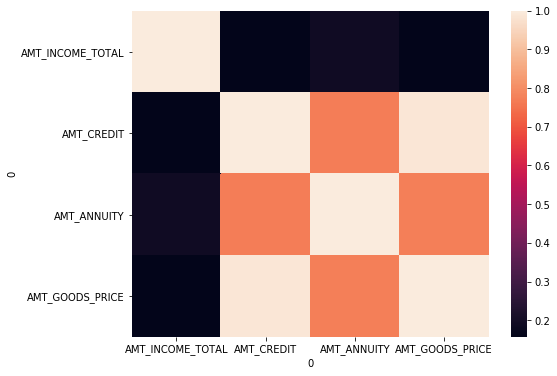

In [92]:
# Corrélations entre ces 3 variables
corr = quantite_argent_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr)
plt.yticks(rotation=0)

**Analyse:**<br/>
- Montant du crédit et montant des biens censés être achetés avec le crédit **r = 0.95**. 
- Annuité et  montant des biens censés être achetés avec le crédit **r = 0.8**. 
- Annuité et montant du crédit **r = 0.8**.
- Pour synthétiser ces variables on pourra garder AMT_CREDIT et AMT_ANNUITY.

In [93]:
# On supprime AMT_GOODS_PRICE
df3 = df3.drop("AMT_GOODS_PRICE", axis=1)

In [94]:
# Dimensions finales de df3
df3.shape

(307511, 53)

**Demandes de prêt:**<br/>
- Une variable demandeur récurrent a été faite.
- La variable AMT_REQ_CREDIT_BUREAU_YEAR est à étudier avec la target pour savoir si les demandeurs de prêts remboursent leur crédit en fonction du nombre de crédits qu'ils ont demandés dans l'année.

**Quantité d'argent:**<br/>
- 3 variables à normaliser.
- Ces 3 variables sont à étudier avec la target. 
- Il se peut que ce soient les variables qui résument le mieux notre jeu de données.

**df3:**
- possède 53 colonnes,
- ne possède que le nombre de demandes de prêts à l'année (contrairement à df2),
- ne possède pas la colonne AMT_GOODS_PRICE,
- possède la colonne demandeur récurrent,
- possède la colonne high incomes,
- possède la colonne AMT_INCOME_TOTAL avec outliers.

---
**Enregistrement de df3**

In [95]:
import pickle

with open('df3', 'wb') as fichier:
    df3_pickler = pickle.Pickler(fichier)
    df3_pickler.dump(df3)

---

**Type CNT**

**Cercle social et défaut de paiement.**

In [96]:
# Copie de df3
df4 = df3.copy()

In [97]:
# Affichage des premières colonnes
nombre_df.head()

,CNT_CHILDREN,CNT_FAM_MEMBERS,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE
1,0,1.0,2.0,2.0,2.0,2.0
2,0,2.0,1.0,0.0,1.0,0.0
3,0,1.0,0.0,0.0,0.0,0.0
4,0,2.0,2.0,0.0,2.0,0.0
5,0,1.0,0.0,0.0,0.0,0.0


**Analyse:**<br/>

- Les colonnes OBS et DEF correspondent au nombre de personnes dans l'entourage du client qui ont des dettes. Ces colonnes vont être importantes pour définir quelqu'un qui pourrait faire perdre beaucoup d'argent en cas de défaut de paiement. En effet, il faut que l'individu ait des garants qui soient en mesure de rembourser le prêt en cas de défaut.
- Vérifions que les deux colonnes OBS et DEF ne contiennent pas la même information ou presque.

In [98]:
print('Pourcentage de correspondance entre les deux colonnes OBS: ', np.around(((np.sum(nombre_df["OBS_30_CNT_SOCIAL_CIRCLE"] == nombre_df["OBS_60_CNT_SOCIAL_CIRCLE"], axis=0) / len(nombre_df["OBS_60_CNT_SOCIAL_CIRCLE"]))*100), 3),'%.')
print('Pourcentage de correspondance entre les deux colonnes DEF: ', np.around(((np.sum(nombre_df["DEF_30_CNT_SOCIAL_CIRCLE"] == nombre_df["DEF_60_CNT_SOCIAL_CIRCLE"], axis=0) / len(nombre_df["DEF_60_CNT_SOCIAL_CIRCLE"]))*100), 3),'%.')

Pourcentage de correspondance entre les deux colonnes OBS:  98.028 %.
Pourcentage de correspondance entre les deux colonnes DEF:  95.799 %.


On ne garde à chaque fois que la colonne qui correspond à l'échelle de temps la plus grande. On ne garde que la colonne DEF qui correspond aux membres de l'entourage ayant fait "défaut".

In [99]:
# Suppression des échelles de temps les plus faibles
df4 = df4.drop(["OBS_30_CNT_SOCIAL_CIRCLE","DEF_30_CNT_SOCIAL_CIRCLE","OBS_60_CNT_SOCIAL_CIRCLE"], axis=1)

**Nombre d'enfant et membres de la famille.**

Pour ces deux variables, on ne va garder que le nombre de membres dans la famille qui contient normalement l'information du nombre d'enfants. Le nombre de membre de la famille est une garantie indirecte. On se tournera vers la famille si un individu ne rembourse pas son prêt.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

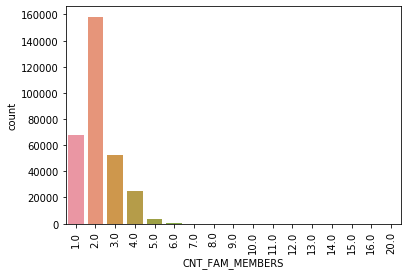

In [100]:
# Distribution de la variable CNT_FAM_MEMBERS
sns.countplot(nombre_df["CNT_FAM_MEMBERS"], data=nombre_df)
plt.xticks(rotation=90)

In [101]:
# Dimensions de df4 finales
df4.shape

(307511, 50)

**df4:**<br/>
- possède 50 colonnes,
- ne possède que les observations de type de DEF du cercle social sur une échelle de temps de 60 jours,
- ne possède que le nombre de membres de la famille et pas le nombre d'enfant de l'individu.

---
**Enregistrement de df4**

In [102]:
import pickle

with open('df4', 'wb') as fichier:
    df4_pickler = pickle.Pickler(fichier)
    df4_pickler.dump(df4)

---

**Type SCORE**

L'objectif ici est de comprendre un peu mieux ces 3 colonnes qui sont des scores de sources extérieures. Nous allons voir s'ils sont corrélés ou non à certaines variables de notre dataset. S'ils ne le sont pas, il y a de fortes chances pour que ces scores apportent des informations supplémentaires et donc, qu'ils soient très utiles pour notre modèle de machine learning.

In [104]:
# Corrélations 

import scipy.stats as st

for scores in score_df.columns:
    
    df4_sans_nan = df4.dropna(axis=0)
    
    mask = (df4_sans_nan.dtypes == 'float64')|(df4_sans_nan.dtypes == 'int64')
    numerical_columns = df4_sans_nan.columns[mask]

    for col in numerical_columns:
        if (st.pearsonr(np.array(df4_sans_nan[scores]), np.array(df4_sans_nan[col]))[0] > 0.3):
            print("{} & {}: r = {}".format(scores,col,st.pearsonr(np.array(df4_sans_nan[scores]), np.array(df4_sans_nan[col]))[0]))

EXT_SOURCE_1 & EXT_SOURCE_1: r = 1.0
EXT_SOURCE_2 & EXT_SOURCE_2: r = 1.0
EXT_SOURCE_3 & EXT_SOURCE_3: r = 1.0


In [105]:
# Anticorrélations

for scores in score_df.columns:
    
    df4_sans_nan = df4.dropna(axis=0)
    
    mask = (df4_sans_nan.dtypes == 'float64')|(df4_sans_nan.dtypes == 'int64')
    numerical_columns = df4_sans_nan.columns[mask]

    for col in numerical_columns:
        if (st.pearsonr(np.array(df4_sans_nan[scores]), np.array(df4_sans_nan[col]))[0] < -0.75):
            print("{} & {}: r = {}".format(scores,col,st.pearsonr(np.array(df4_sans_nan[scores]), np.array(df4_sans_nan[col]))[0]))

Aucune corrélation ou anti-corrélation linéaire notable entre un de ces scores et une variable du dataset. On va donc garder ces 3 variables de scores.

### NAME & autres variables

In [106]:
# Copie de df4
df5 = df4.copy()

In [107]:
# Affichage des premières lignes
nom_df.head()

,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE
1,Cash loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment
2,Cash loans,Family,State servant,Higher education,Married,House / apartment
3,Revolving loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment
4,Cash loans,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment
5,Cash loans,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment


In [108]:
# Modalités des variables de type NAME
for col in nom_df.columns:
    print('\n {} :\n{} '.format(col, nom_df[col].unique()))


 NAME_CONTRACT_TYPE :
['Cash loans' 'Revolving loans'] 

 NAME_TYPE_SUITE :
['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people'] 

 NAME_INCOME_TYPE :
['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave'] 

 NAME_EDUCATION_TYPE :
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree'] 

 NAME_FAMILY_STATUS :
['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown'] 

 NAME_HOUSING_TYPE :
['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment'] 


On va supprimer la colonne qui correspond aux personnes (s'il y en avait) qui accompagnaient le demandeur de prêt (NAME_TYPE_SUITE). Cette variable est inutile pour la prédiction de la target.

In [109]:
# Suppression de NAME_TYPE_SUITE
df5 = df5.drop('NAME_TYPE_SUITE', axis=1)

In [110]:
# Autres variables (sans ID et la TARGET)
autres_variables_df = autres_variables_df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
list(autres_variables_df.columns)

['CODE_GENDER',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'DAYS_LAST_PHONE_CHANGE']

**Analyse:**<br/>
Grâce à la description des colonnes, on peut éliminer les variables qui sont redondandes ou inutiles parmis ces variables. On va supprimer:
- REGION_POPULATION_RELATIVE
- WEEKDAY_APPR_PROCESS_START
- HOUR_APPR_PROCESS_START
- DAYS_LAST_PHONE_CHANGE

On va ensuite voir si on ne peut pas synthétiser les groupes de colonnes suivants:
- REGION_RATING_W_CITY & REGION_RATING_CLIENT 
- DAYS_REGISTRATION & DAYS_ID_PUBLISH 
- REG_REGION_NOT_LIVE_REGION & REG_REGION_NOT_WORK_REGION & LIVE_REGION_NOT_WORK_REGION 
- REG_CITY_NOT_WORK_CITY & LIVE_CITY_NOT_WORK_CITY 
- REG_CITY_NOT_LIVE_CITY & REG_CITY_NOT_WORK_CITY

On constate grâce à la description des colonnes que la variable "âge de la personne" (DAYS_BIRTH) est sous forme de jours négatifs. Pour que cette variable soit plus compréhensible, on va la mettre sous forme d'années. Idem pour DAYS_EMPLOYED.

In [111]:
# Suppression des variables mentionnées au-dessus
df5 = df5.drop(["REGION_POPULATION_RELATIVE", "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE"], axis=1)

In [112]:
# REGION_RATING_W_CITY & REGION_RATING_CLIENT
print('Pourcentage de correspondance entre les deux colonnes RATING: ', np.around(((np.sum(autres_variables_df["REGION_RATING_CLIENT_W_CITY"] == autres_variables_df["REGION_RATING_CLIENT"], axis=0) / len(autres_variables_df["REGION_RATING_CLIENT"]))*100), 3),'%.')

Pourcentage de correspondance entre les deux colonnes RATING:  98.141 %.


In [113]:
# DAYS_REGISTRATION & DAYS_ID_PUBLISH
print('Pourcentage de correspondance entre les deux colonnes DAYS: ', np.around(((np.sum(autres_variables_df["DAYS_REGISTRATION"] == autres_variables_df["DAYS_ID_PUBLISH"], axis=0) / len(autres_variables_df["DAYS_ID_PUBLISH"]))*100), 3),'%.')

Pourcentage de correspondance entre les deux colonnes DAYS:  1.053 %.


In [114]:
# REG_REGION_NOT_LIVE_REGION & REG_REGION_NOT_WORK_REGION & LIVE_REGION_NOT_WORK_REGION
print('Pourcentage de correspondance entre les deux colonnes REGION: ', 
      np.around(((np.sum(((autres_variables_df["REG_REGION_NOT_LIVE_REGION"] == autres_variables_df["REG_REGION_NOT_WORK_REGION"]) & (autres_variables_df["REG_REGION_NOT_WORK_REGION"] == autres_variables_df["LIVE_REGION_NOT_WORK_REGION"])) , axis=0) / len(autres_variables_df["LIVE_REGION_NOT_WORK_REGION"]))*100), 3),
      '%.')

Pourcentage de correspondance entre les deux colonnes REGION:  94.841 %.


In [115]:
# REG_CITY_NOT_WORK_CITY & LIVE_CITY_NOT_WORK_CITY
print('Pourcentage de correspondance entre les deux colonnes WORK_LIVE: ', 
      np.around(((np.sum(((autres_variables_df["REG_CITY_NOT_WORK_CITY"] == autres_variables_df["LIVE_CITY_NOT_WORK_CITY"])) , axis=0) / len(autres_variables_df["LIVE_CITY_NOT_WORK_CITY"]))*100), 3),
      '%.')

Pourcentage de correspondance entre les deux colonnes WORK_LIVE:  93.963 %.


In [116]:
# REG_CITY_NOT_LIVE_CITY & REG_CITY_NOT_WORK_CITY
print('Pourcentage de correspondance entre les deux colonnes WORK_LIVE: ', 
      np.around(((np.sum(((autres_variables_df["REG_CITY_NOT_LIVE_CITY"] == autres_variables_df["REG_CITY_NOT_WORK_CITY"])) , axis=0) / len(autres_variables_df["REG_CITY_NOT_WORK_CITY"]))*100), 3),
      '%.')

Pourcentage de correspondance entre les deux colonnes WORK_LIVE:  82.698 %.


**Conclusion:**<br/>
- REGION_RATING_W_CITY & REGION_RATING_CLIENT **SEMBLABLES**
    - On garde REGION_RATING_CLIENT.
        
    
- DAYS_REGISTRATION & DAYS_ID_PUBLISH **DIFFERENTES**
    - On garde les deux.
    
     
- REG_REGION_NOT_LIVE_REGION & REG_REGION_NOT_WORK_REGION & LIVE_REGION_NOT_WORK_REGION **SEMBLABLES**
    - On garde REG_REGION_NOT_LIVE_REGION.
    
    
- REG_CITY_NOT_WORK_CITY & LIVE_CITY_NOT_WORK_CITY **SEMBLABLES**
    - On garde REG_CITY_NOT_WORK_CITY.
    
    
- REG_CITY_NOT_LIVE_CITY & REG_CITY_NOT_WORK_CITY **LEGEREMENT DIFFERENTES**
    - On garde REG_CITY_NOT_LIVE_CITY.

In [117]:
# Suppression des colonnes mentionnées ci-dessus
df5 = df5.drop(["REGION_RATING_CLIENT_W_CITY",
                        "REG_REGION_NOT_WORK_REGION",
                        "LIVE_REGION_NOT_WORK_REGION",
                        "LIVE_CITY_NOT_WORK_CITY"],
                        axis=1)

Il reste à mettre les variables de type DAYS sous forme plus compréhensible autrement dit, transformer les jours en mois ou en années.

In [118]:
# DAYS_BIRTH
df5['DAYS_BIRTH'] = df5['DAYS_BIRTH'] / (-365)
df5['DAYS_BIRTH'].head()

1    25.920548
2    45.931507
3    52.180822
4    52.068493
5    54.608219
Name: DAYS_BIRTH, dtype: float64

In [119]:
# Y-a-t-il des outliers ?
df5['DAYS_BIRTH'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Il n'y a pas de outliers pour la variable DAYS_BIRTH.

In [120]:
# DAYS_EMPLOYED
df5['DAYS_EMPLOYED'] = df5['DAYS_EMPLOYED'] / (-365)
df5['DAYS_EMPLOYED'].head()

1    1.745205
2    3.254795
3    0.616438
4    8.326027
5    8.323288
Name: DAYS_EMPLOYED, dtype: float64

In [121]:
# Y-a-t-il des outliers ?
df5['DAYS_EMPLOYED'].describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

Il y a des outliers pour la variable DAYS_EMPLOYED puisqu'on a un minimum à -1000 ans ... On va enlever toutes les valeurs négatives.

In [122]:
# On enlève les valeurs négatives pour la variable DAYS_EMPLOYED
df5["DAYS_EMPLOYED"] = ex.sans_outliers(df5, 'DAYS_EMPLOYED', borne_inf=False, borne_sup=False, nouvelle_borne_sup=df5['DAYS_EMPLOYED'].max())

In [123]:
# Vérification
df5['DAYS_EMPLOYED'].describe()

count    252137.000000
mean          6.531971
std           6.406466
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [124]:
# DAYS_ID_PUBLISH
df5['DAYS_ID_PUBLISH'] = df5['DAYS_ID_PUBLISH'] / (-365)
df5['DAYS_ID_PUBLISH'].head()

1    5.808219
2    0.797260
3    6.934247
4    6.676712
5    9.473973
Name: DAYS_ID_PUBLISH, dtype: float64

In [125]:
# Y-a-t-il des outliers ?
df5['DAYS_ID_PUBLISH'].describe()

count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64

Il n'y a pas d'outliers pour DAYS_ID_PUBLISH.

In [126]:
# DAYS_REGISTRATION
df5['DAYS_REGISTRATION'] = df5['DAYS_REGISTRATION'] / (-365)
df5['DAYS_REGISTRATION'].head()

1     9.994521
2     3.249315
3    11.671233
4    26.939726
5    11.810959
Name: DAYS_REGISTRATION, dtype: float64

In [127]:
# Y-a-t-il des outliers ?
df5['DAYS_REGISTRATION'].describe()

count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64

Il n'y a pas d'outliers pour DAYS_REGISTRATION.

In [128]:
# Dimensions finales de df5
df5.shape

(307511, 41)

**df5:**<br/>
- possède 41 colonnes,
- possède les colonnes DAYS_BIRTH, DAYS_REGISTRATION, DAYS_ID_PUBLISH & DAYS_EMPLOYED sous forme d'années et sans outliers
- nous servira à faire notre analyse de fond un peu plus poussée.

---
**Enregistrement de df5**

In [129]:
with open('df5', 'wb') as fichier:
    df5_pickler = pickle.Pickler(fichier)
    df5_pickler.dump(df5)

---

## I. C. Variables principales et TARGET

Dans cette partie, on va analyser les relations qu'il y a entre les variables sélectionnées de notre dataset et notre target.

In [130]:
# Tableau qui va nous servir à faire l'analyse
df_eda = df5.copy()

### Variables quantitatives, variables binaires & TARGET.

In [131]:
# Liste des variables binaires
variables_binaires = []
for col in df_eda.columns:
    if len(df_eda[col].unique())==2:
        variables_binaires.append(col)

In [132]:
# Différenciation des variables binaires qualitatives et quantitatives
binaires_quantitatives = []
binaires_qualitatives = []
for var in variables_binaires:
    if df_eda[var].dtypes == 'object':
        binaires_qualitatives.append(var)
    else:
        binaires_quantitatives.append(var)

In [133]:
# Binaires qualitatives 
for var in binaires_qualitatives:
    print("\n {} : \n {}".format(var, df_eda[var].unique()))


 NAME_CONTRACT_TYPE : 
 ['Cash loans' 'Revolving loans']


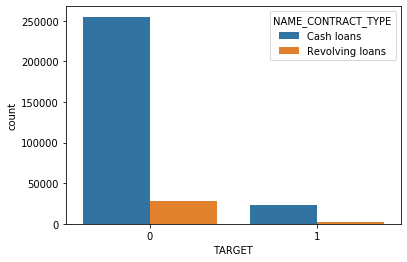

In [134]:
# Type de contrat X Target
plt.figure(figsize=(6,4))
sns.countplot(x='TARGET', hue='NAME_CONTRACT_TYPE', data=df_eda)

**Analyse:**<br/>
On constate qu'il y a proportionnellement le même nombre de personnes ayant fait défaut avec un "Cash loans" et avec un "Revolving loans". Le type de prêt ne semble pas avoir d'influence sur la target.

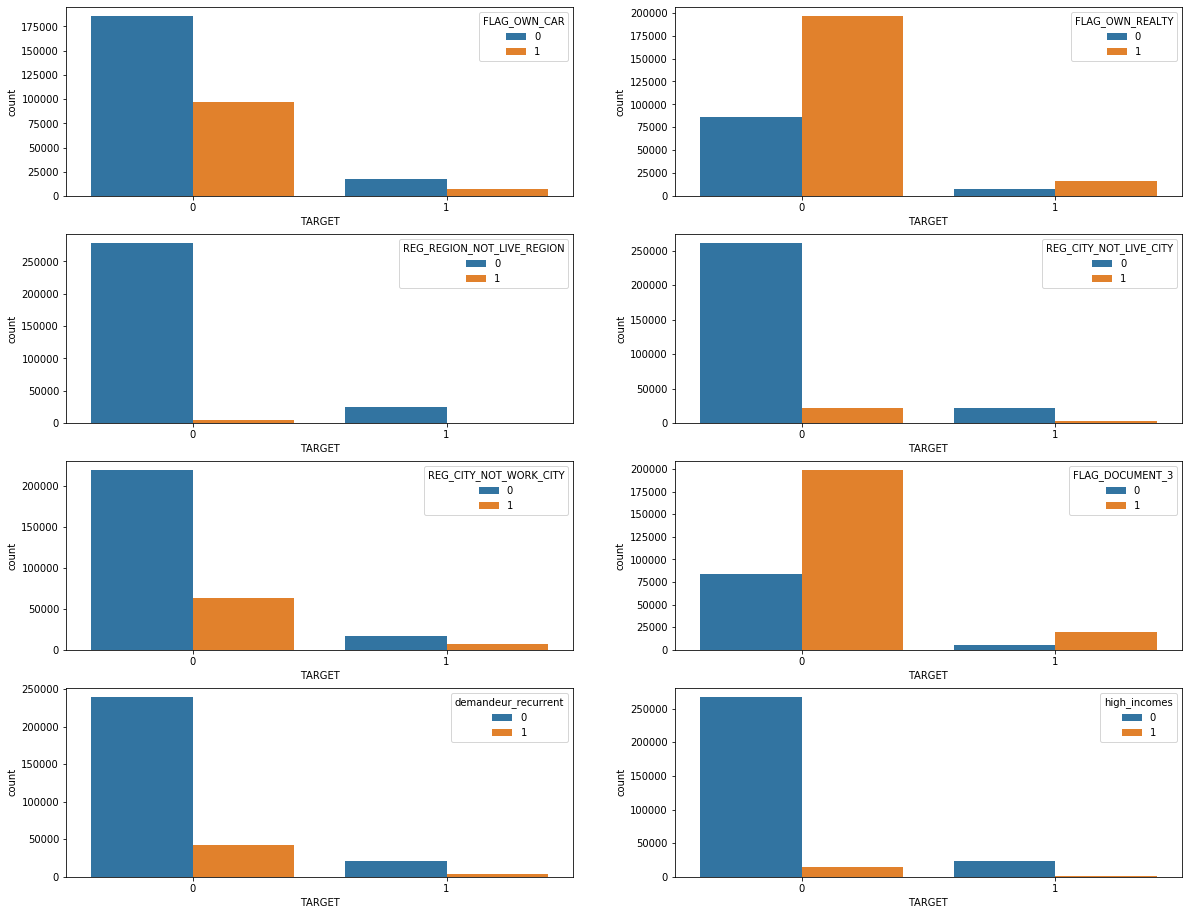

In [135]:
# Binaires quantitatives
plt.figure(figsize=(20,16))
for index, var in enumerate(binaires_quantitatives[1:]):
    plt.subplot(4,2,index+1)
    sns.countplot(x='TARGET', hue=var, data=df_eda)

**Analyse:**<br/>
On fait le même constat pour toutes les variables: aucune ne semble avoir d'influence sur la target à l'exception de FLAG_OWN_REALTY. En effet, à chaque fois on constate des proportions égales dans les deux colonnes pour la couleur orange et pour la couleur bleue sauf pour la colonne qui indique si le personne est propriétaire.

In [136]:
# Liste des variables quantitatives et qualitatives
variables_qualitatives = []
variables_quantitatives = []
for col in df_eda.columns:
    if df_eda[col].dtypes=='object':
        if len(df_eda[col].unique())>=3:
            variables_qualitatives.append(col)
    elif len(df_eda[col].unique())>=3:
        variables_quantitatives.append(col)

In [137]:
# Nombre de modalités prises par les variables quantitatives
quantitatives_discretes = []
quantitatives_continues = []
for var in variables_quantitatives:
    if len(df_eda[var].unique())<=63:
        quantitatives_discretes.append(var)
    else:
        quantitatives_continues.append(var)

In [138]:
# On enlève OWN_CAR_AGE qu'on traitera seule
quantitatives_discretes = [quantitatives_discretes[0]] + quantitatives_discretes[2:]
quantitatives_discretes

['CNT_CHILDREN',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'nombre_doc_fournis']

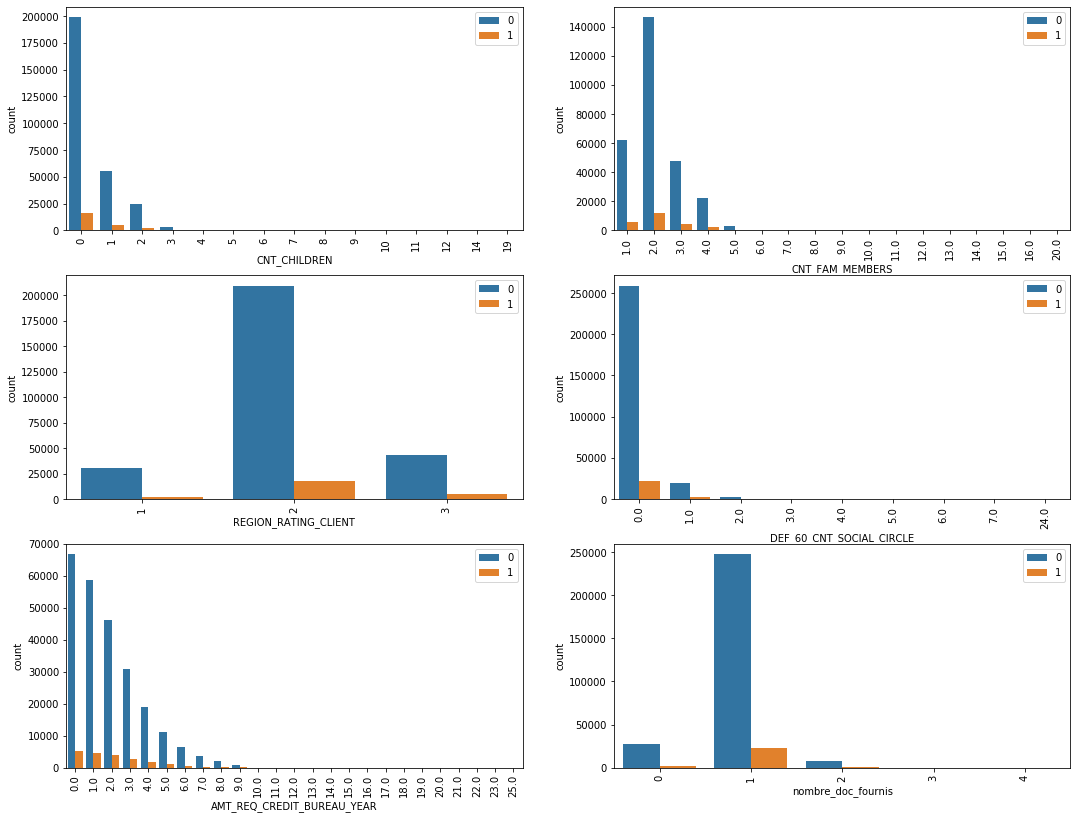

In [139]:
# Variables quantitatives discrètes X Target
plt.figure(figsize=(18, 14))
for index, var in enumerate(quantitatives_discretes):
    plt.subplot(3,2,index+1)
    sns.countplot(x=var, hue='TARGET', data=df_eda)
    plt.legend(loc=1)
    plt.xticks(rotation=90)

**Analyse:**<br/>
On constate qu'aucune variable exceptées  AMT_REQ_CREDIT_BUREAU_YEAR et REGION_RATING_CLIENT ne semble avoir d'influence sur la target. En ce qui concerne AMT_REQ_CREDIT_BUREAU_YEAR il semblerait que le nombre de personnes qui font défaut décroit moins vite avec le nombre de demandes de prêts que le nombre de personne qui arrivent à rembourser leur prêt.

In [140]:
# Dataframe avec que les gens qui ont fait défaut
defaut_df = df_eda[df_eda['TARGET']==1].copy()

# Dataframe avec que les gens qui ont remboursés leur crédit
ras_df = df_eda[df_eda['TARGET']==0].copy()

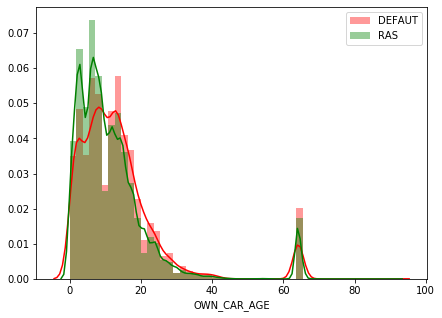

In [141]:
# OWN_CAR_AGE X Target
plt.figure(figsize=(7,5))
sns.distplot(defaut_df["OWN_CAR_AGE"], color='r', label="DEFAUT")
sns.distplot(ras_df["OWN_CAR_AGE"], color='g', label="RAS")
plt.legend()

**Analyse:**<br/>
Très légère différence de distribution entre les personnes ayant fait défaut et les autres.

In [142]:
# On calcule la valeur à partir de laquelle on considèrera les outliers.
IQ = df_eda["AMT_INCOME_TOTAL"].quantile(q=0.75) - df_eda["AMT_INCOME_TOTAL"].quantile(q=0.25)
Q3 = df_eda["AMT_INCOME_TOTAL"].quantile(q=0.75)
borne_outliers = Q3 + 1.5*IQ

# On enlève les outliers pour AMT_INCOME_TOTAL
defaut_df["AMT_INCOME_TOTAL"] = defaut_df[defaut_df["AMT_INCOME_TOTAL"] <= borne_outliers]
ras_df["AMT_INCOME_TOTAL"] =  ras_df[ras_df["AMT_INCOME_TOTAL"] <= borne_outliers]

In [143]:
# On enlève les outliers pour AMT_INCOME_TOTAL dans df_eda et dans df5
df_eda["AMT_INCOME_TOTAL"] = ex.sans_outliers(df_eda, "AMT_INCOME_TOTAL", borne_inf=False)
df5["AMT_INCOME_TOTAL"] = ex.sans_outliers(df5, "AMT_INCOME_TOTAL", borne_inf=False)

In [144]:
quantitatives_continues

['SK_ID_CURR',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'LIVINGAREA_AVG',
 'TOTALAREA_MODE']

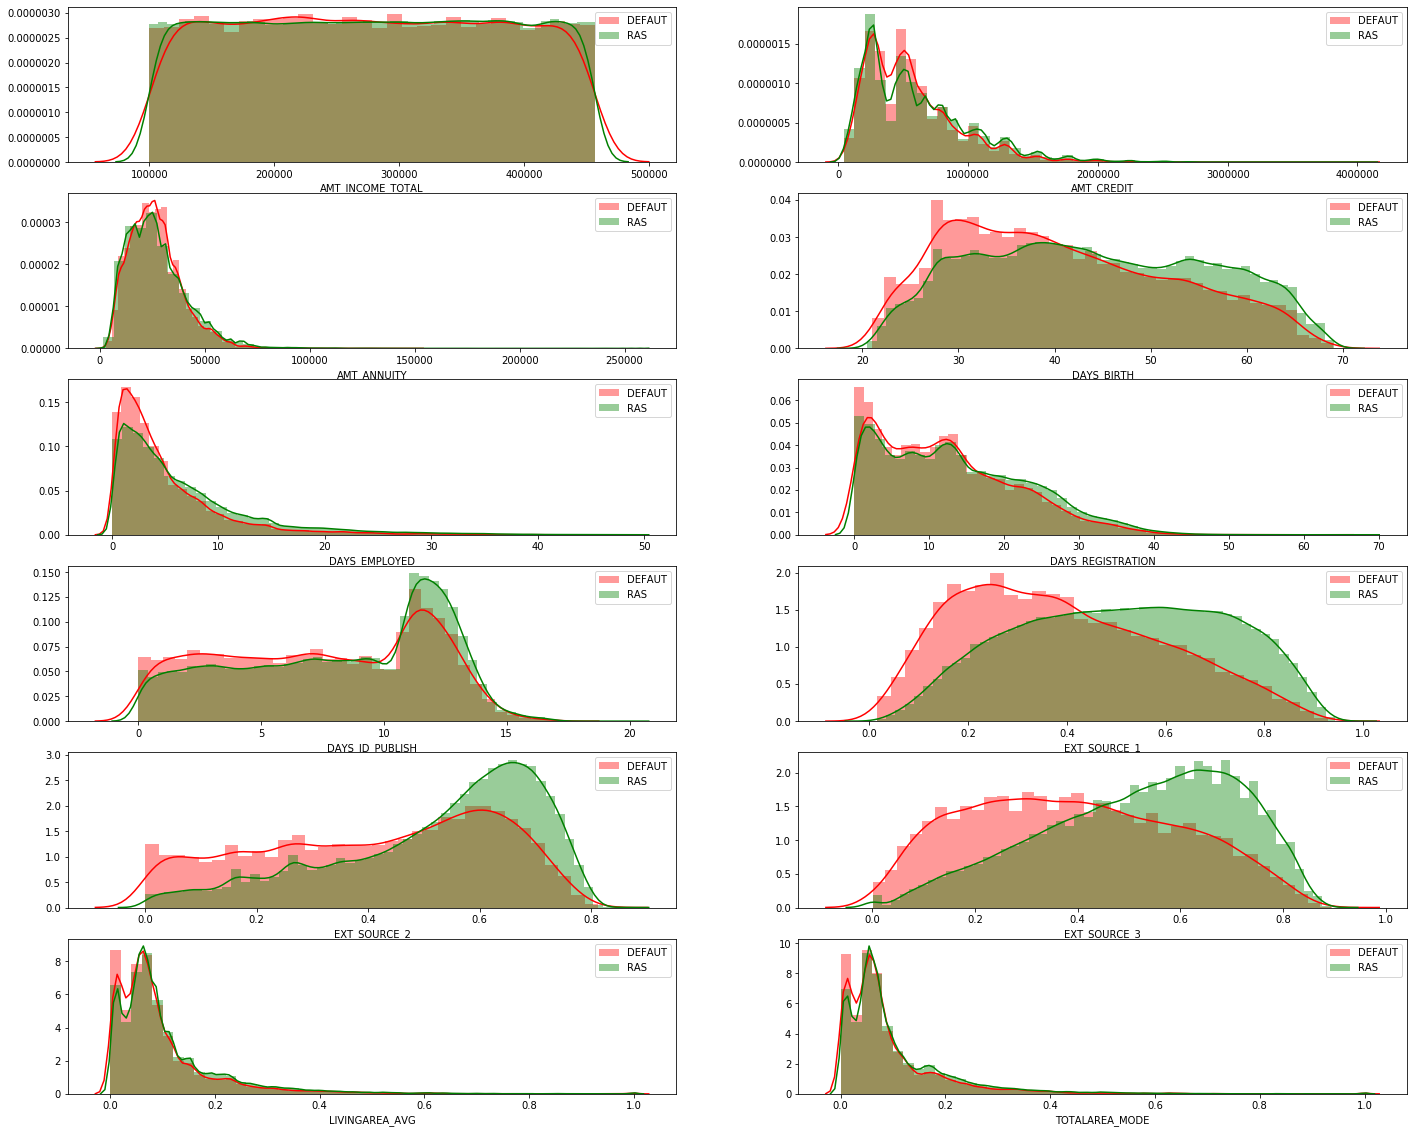

In [145]:
# Variables quantitatives continues X target
plt.figure(figsize=(24, 20))
for index, var in enumerate(quantitatives_continues[1:]):
    plt.subplot(6,2,index+1)
    sns.distplot(defaut_df[var],color='r', label="DEFAUT")
    sns.distplot(ras_df[var], color='g', label="RAS")
    plt.legend()

**Analyse:**<br/>
Les trois variables de scores présentent des distributions différentes selon si l'individu a fait défaut ou non. Pour toutes les autres variables, les distributions sont similaires.

### Variables qualitatives & TARGET

In [146]:
# Modalités prises par les variables qualitatives
for var in variables_qualitatives:
    print("\n {} : {} ".format(var, len(df_eda[var].unique())))


 CODE_GENDER : 3 

 NAME_INCOME_TYPE : 8 

 NAME_EDUCATION_TYPE : 5 

 NAME_FAMILY_STATUS : 6 

 NAME_HOUSING_TYPE : 6 

 OCCUPATION_TYPE : 19 

 ORGANIZATION_TYPE : 58 

 FONDKAPREMONT_MODE : 5 

 HOUSETYPE_MODE : 4 

 WALLSMATERIAL_MODE : 8 

 EMERGENCYSTATE_MODE : 3 


In [147]:
# On traite ORGANISATION_TYPE de manière isolée
variables_qualitatives = variables_qualitatives[0:6] + variables_qualitatives[7:]

<div id=qualitativesXtarget>Variables qualitatives & Target</div>

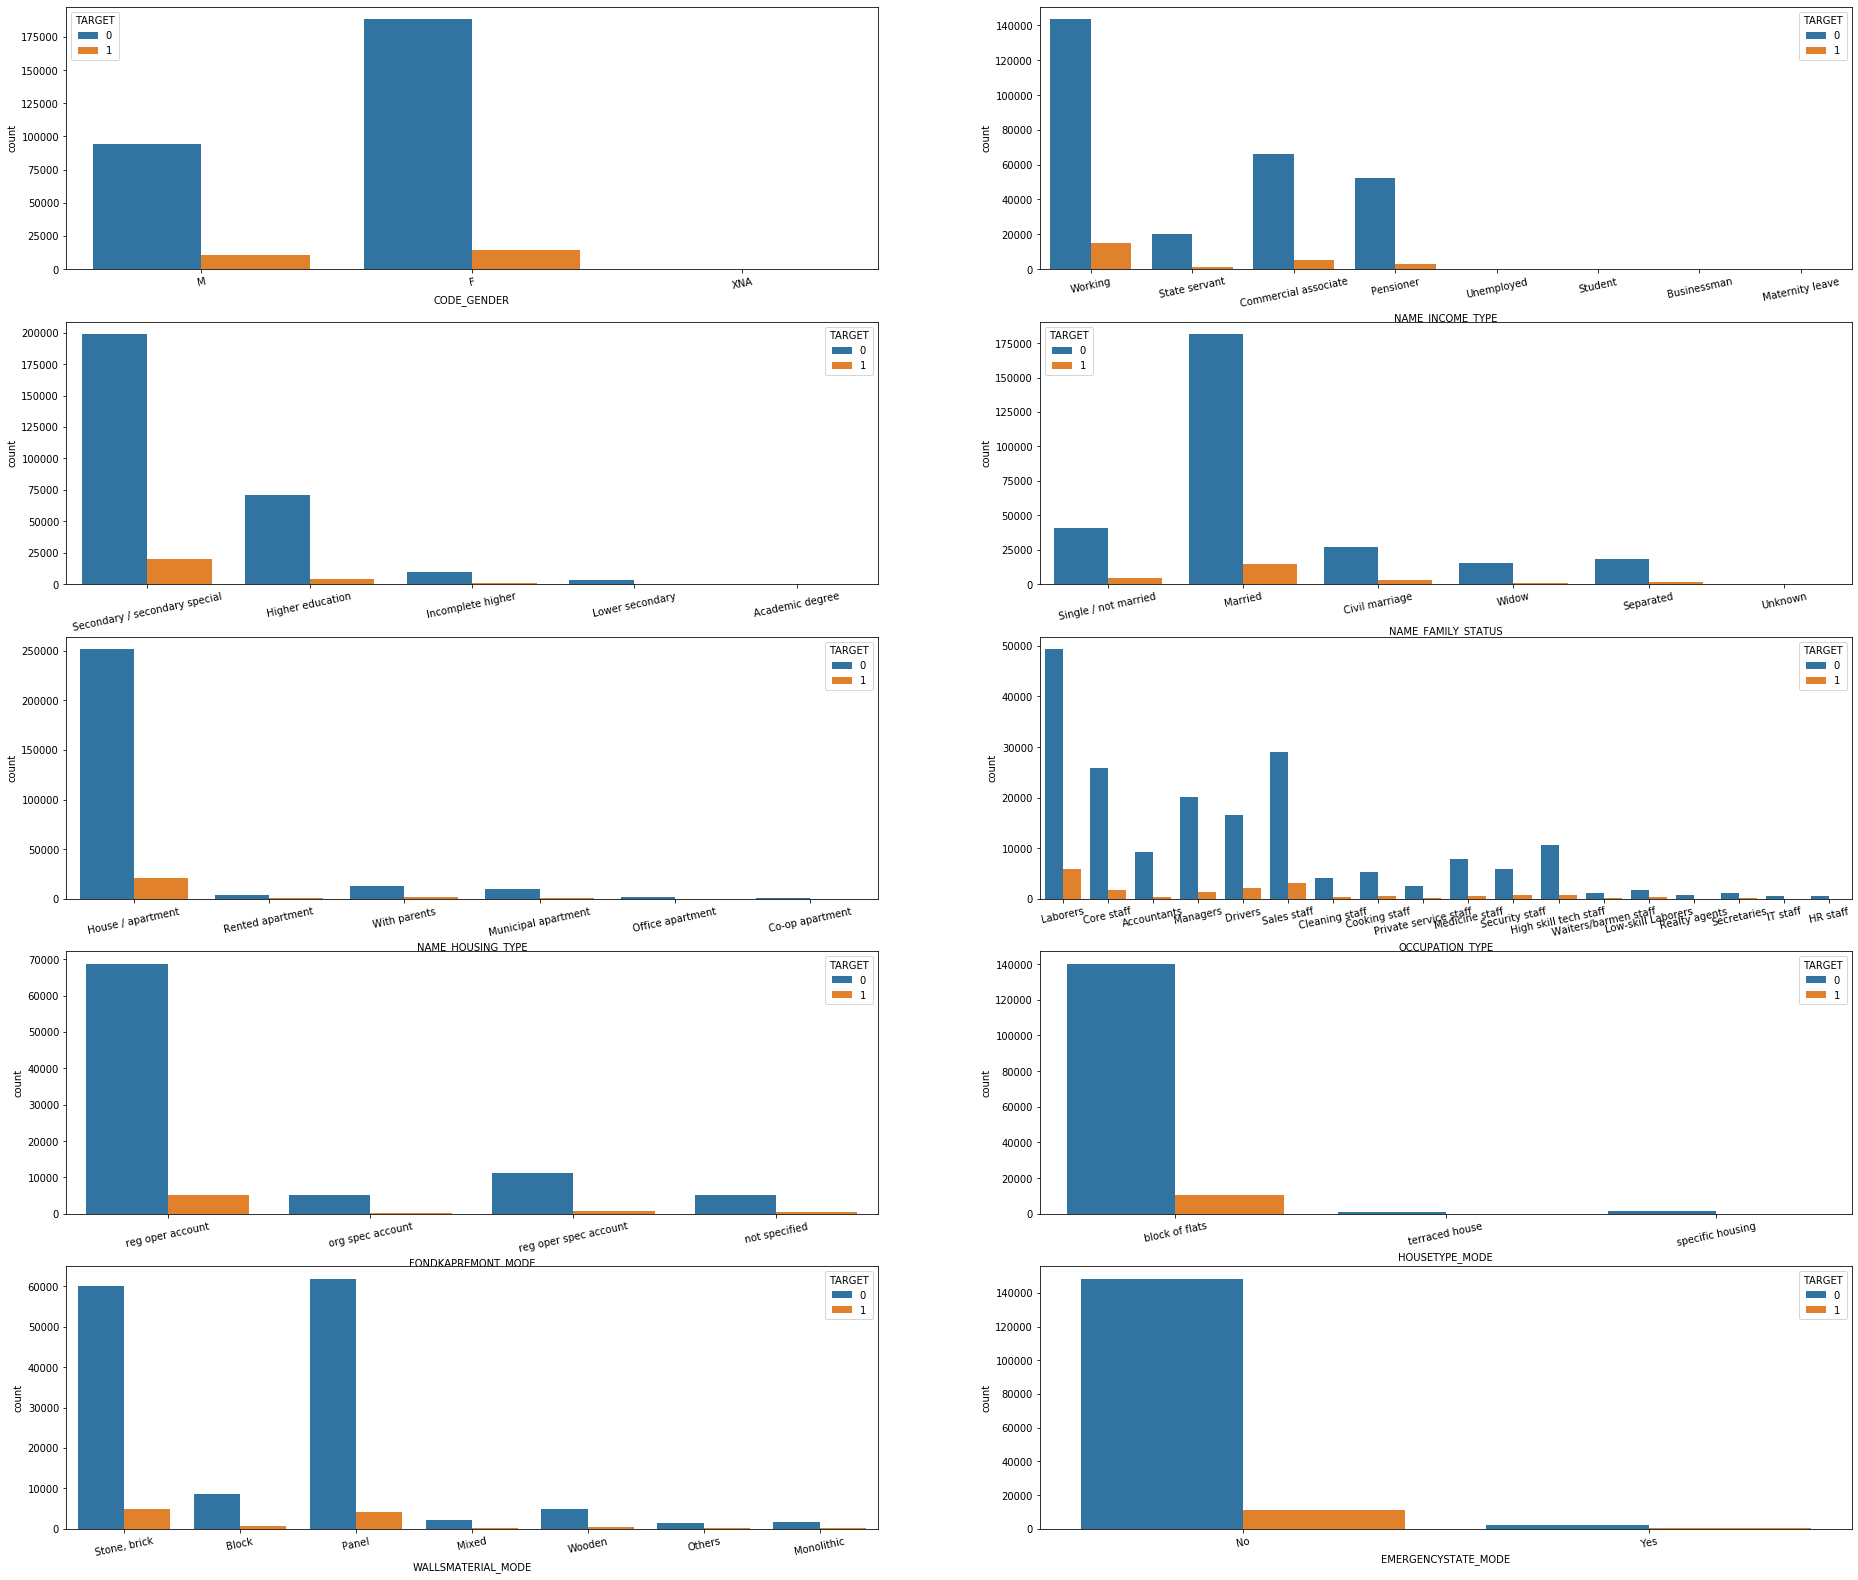

In [148]:
# Variables qualitatives X Target
plt.figure(figsize=(32, 28))
for index, var in enumerate(variables_qualitatives):
    plt.subplot(5,2,index+1)
    sns.countplot(x=var, hue='TARGET', data=df_eda)
    plt.xticks(rotation=12)

**Analyse:**
- Il y a le même nombre d'hommes qui ont fait défaut que de femmes ayant fait défaut. Cependant, il y a beaucoup plus de femme qui ont fait de demandes de prêt. 
- On constate sur ces graphiques que la pluspart de ces variables qualitatives présentent au moins une modalité en très faible portion. Cette information devra être prise en compte au moment de l'encodage de ces variables.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57]),
 <a list of 58 Text xticklabel objects>)

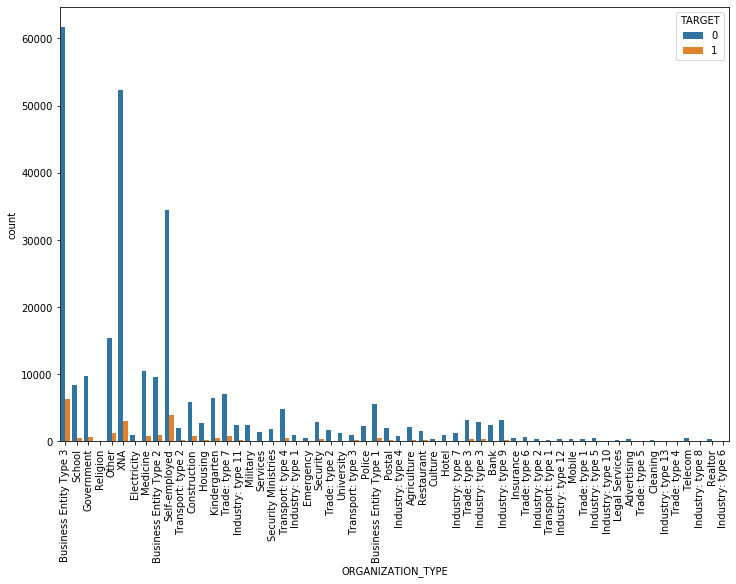

In [149]:
# ORGANISATION_TYPE X Target
plt.figure(figsize=(12, 8))
sns.countplot(x="ORGANIZATION_TYPE", hue="TARGET", data=df_eda)
plt.xticks(rotation=90)

**Analyse:**<br/>
Il semblerait qu'il y ait une proportion plus élevée de défaut de paiement chez les auto-entrepreneurs.

In [151]:
# Dimensions finales de df5
df5.shape

(307511, 41)

In [152]:
# Dimensions de df_eda
df_eda.shape

(307511, 41)

---
**Enregistrement des variables (df5 et df_eda sans outliers pour AMT_INCOME)**

In [150]:
with open('df_eda', 'wb') as fichier:
    df_eda_pickler = pickle.Pickler(fichier)
    df_eda_pickler.dump(df_eda)
    
with open('variables_quantitatives', 'wb') as fichier:
    variables_quantitatives_pickler = pickle.Pickler(fichier)
    variables_quantitatives_pickler.dump(variables_quantitatives)
    
with open('variables_qualitatives', 'wb') as fichier:
    variables_qualitatives_pickler = pickle.Pickler(fichier)
    variables_qualitatives_pickler.dump(variables_qualitatives)

with open('binaires_quantitatives', 'wb') as fichier:
    binaires_quantitatives_pickler = pickle.Pickler(fichier)
    binaires_quantitatives_pickler.dump(binaires_quantitatives)

with open('binaires_qualitatives', 'wb') as fichier:
    binaires_qualitatives_pickler = pickle.Pickler(fichier)
    binaires_qualitatives_pickler.dump(binaires_qualitatives)

with open('ras_df', 'wb') as fichier:
    ras_df_pickler = pickle.Pickler(fichier)
    ras_df_pickler.dump(ras_df)
    
with open('defaut_df', 'wb') as fichier:
    defaut_df_pickler = pickle.Pickler(fichier)
    defaut_df_pickler.dump(defaut_df)

---

### Corrélations entre toutes les variables

---
**Récupération des variables**

In [154]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle  


# Récupération de df
with open('df', 'rb') as fichier:
    df_depickler = pickle.Unpickler(fichier)
    df = df_depickler.load()

# Montants
montant_df = ex.selection_variables(df, ['AMT_'])

# Nombres
nombre_df = ex.selection_variables(df, ['CNT_'])

# Signalé.e
flag_df = ex.selection_variables(df, ['FLAG_'])

# Numerical informations
num_information_df = ex.selection_variables(df, ['_MEDI', '_MODE','_AVG'])

# Noms
nom_df = ex.selection_variables(df, ['NAME_'])

# Scores
score_df = ex.selection_variables(df, ['EXT_SOURCE_'])

# Autres variables
variables_a_supprimer = list(montant_df.columns)  + list(nombre_df.columns) + list(flag_df.columns) + list(num_information_df.columns) + list(nom_df.columns) + list(score_df.columns)
autres_variables_df = df.drop(variables_a_supprimer, axis=1)


# Récupération de df1
with open('df1','rb') as fichier:
    df1_depickler = pickle.Unpickler(fichier)
    df1 = df1_depickler.load()
    
# Récupération de df2
with open('df2','rb') as fichier:
    df2_depickler = pickle.Unpickler(fichier)
    df2 = df2_depickler.load()
    
    
# Récupération de df3
with open('df3','rb') as fichier:
    df3_depickler = pickle.Unpickler(fichier)
    df3 = df3_depickler.load()
    
    
# Récupération de df4
with open('df4','rb') as fichier:
    df4_depickler = pickle.Unpickler(fichier)
    df4 = df4_depickler.load()
    
# Récupération de df5
with open('df5','rb') as fichier:
    df5_depickler = pickle.Unpickler(fichier)
    df5 = df5_depickler.load()

# Récupération de df_eda
with open('df_eda','rb') as fichier:
    df_eda_depickler = pickle.Unpickler(fichier)
    df_eda = df_eda_depickler.load()

# Récupération de defaut_df
with open('defaut_df','rb') as fichier:
    defaut_df_depickler = pickle.Unpickler(fichier)
    defaut_df = defaut_df_depickler.load()
    
# Récupération de ras_df
with open('ras_df','rb') as fichier:
    ras_df_depickler = pickle.Unpickler(fichier)
    ras_df = ras_df_depickler.load()
    
# Récupération de variables_quantitatives
with open('variables_quantitatives','rb') as fichier:
    variables_quantitatives_depickler = pickle.Unpickler(fichier)
    variables_quantitatives = variables_quantitatives_depickler.load()
    
# Récupération de variables_qualitatives
with open('variables_qualitatives','rb') as fichier:
    variables_qualitatives_depickler = pickle.Unpickler(fichier)
    variables_qualitatives = variables_qualitatives_depickler.load()
    
# Récupération de variables_qualitatives
with open('binaires_quantitatives','rb') as fichier:
    binaires_quantitatives_depickler = pickle.Unpickler(fichier)
    binaires_quantitatives = binaires_quantitatives_depickler.load()
    
# Récupération de variables_qualitatives
with open('binaires_qualitatives','rb') as fichier:
    binaires_qualitatives_depickler = pickle.Unpickler(fichier)
    binaires_qualitatives = binaires_qualitatives_depickler.load()    

---

On a analysé les relations entre les variables principales et la TARGET. Maintenant, on va analyser les relations entre toutes les variables principales. Pour avoir une vue d'ensemble, on va afficher la matrice des corrélations sous forme de heatmap.

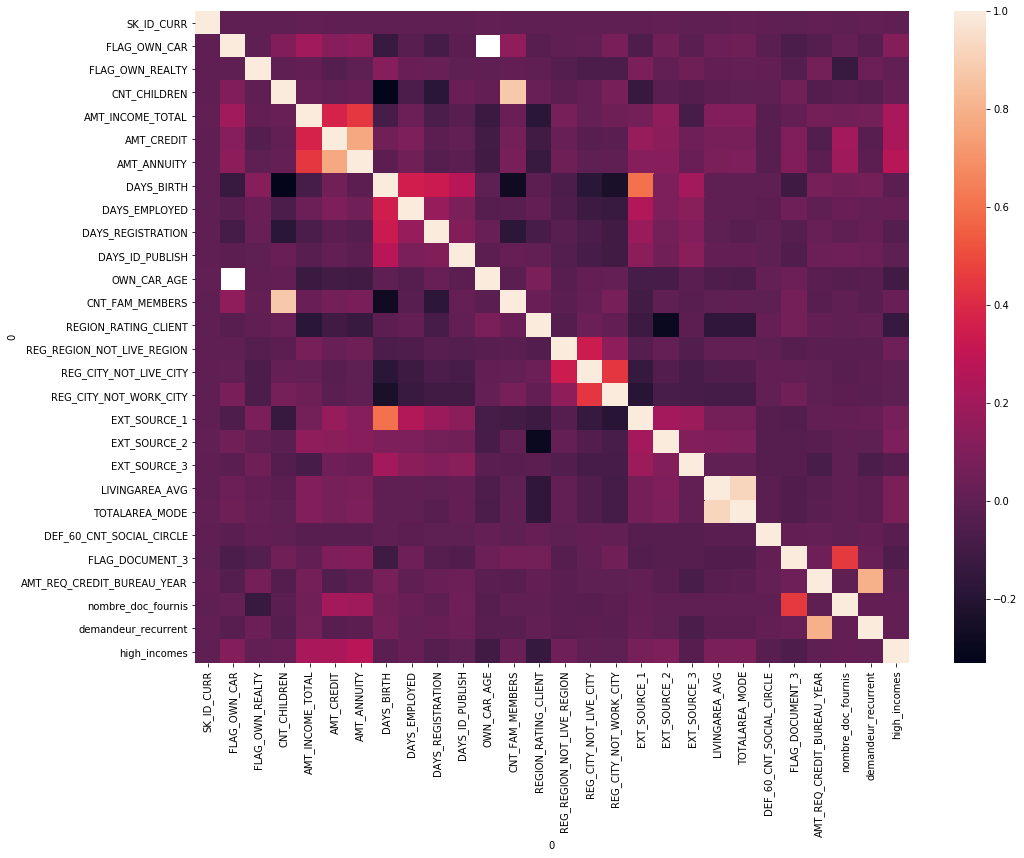

In [155]:
# Heatmap des corrélations
plt.figure(figsize=(16,12))
sns.heatmap(df_eda.drop("TARGET", axis=1).corr())

**Analyse des r > 0.7:**
- On compte 4 points représentant des coefficients de corrélation supérieurs ou égaux à 0.7.
- Le premier est CNT_FAMILY_MEMBER et CNT_CHILDREN. Le nombre de personnes dans la famille est lié au nombre d'enfants. Afin de réduire la redondance d'information on ne va garder que CNT_FAMILY_MEMBER.
- Le deuxième point est AMT_ANNUITY et AMT_CREDIT. On avait déjà mis en évidence cette corrélation entre les deux variables. La variable ANNUITY va nous permettre de faire la variable INCOME/ANNUITY en pourcentage. Ainsi on saura à quel pourcentage du salaire correspond le remboursement du prêt. Pour l'instant, on garde donc le montant total du prêt et la variable AMT_CREDIT.
- Le troisième point est entre TOTALAREA_MODE et LIVINGAREA_AVG. On va superposer leur distribution pour voir si ces deux variables contiennent la même information.
- Le 4ème point est entre demandeur_récurrent et AMT_REQ_CREDIT_YEAR ce qui est normal puisque nous avons créer la première à partir de la seconde. On testera d'abord notre modèle avec la variable originale puis avec la nouvelle. On comparera ensuite les performances.
- On note également un coefficent de corrélation linéaire égal à 0.6 entre le score 1 et l'âge du demandeur de prêt. On ne peut rien conclure quant à la corrélation entre ces deux variables, le coefficient est trop faible.

In [156]:
# On supprime CNT_CHILDREN
df_eda = df_eda.drop("CNT_CHILDREN", axis=1)
df5 = df5.drop("CNT_CHILDREN", axis=1)

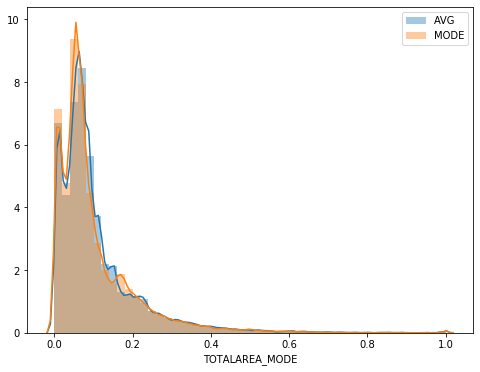

In [157]:
# Comparaison des distributions de TOTALAREA_MODE & LIVINGAREA_AVG
plt.figure(figsize=(8,6))
sns.distplot(df_eda["LIVINGAREA_AVG"], label="AVG")
sns.distplot(df_eda["TOTALAREA_MODE"], label="MODE")
plt.legend()

Les deux colonnes sont presque identiques on va donc en garder une seule: LIVINGAREA_AVG qui est plus facile à interpréter.

In [158]:
# Suppression de TOTALAREA_MODE dans df_eda et df5
df_eda = df_eda.drop("TOTALAREA_MODE",axis=1)
df5 = df5.drop("TOTALAREA_MODE",axis=1)

**Pourcentage du salaire payé pour le remboursement du prêt**

In [159]:
# Création de la variable % du salaire
df_eda["pourcentage_salaire"] = np.around((df_eda["AMT_ANNUITY"] / df_eda["AMT_INCOME_TOTAL"])*100,1)

In [160]:
# Description de la variable pourcentage_salaire
df_eda["pourcentage_salaire"].describe()

count    293464.000000
mean         18.464865
std           9.458308
min           0.900000
25%          11.900000
50%          16.700000
75%          23.300000
max         187.600000
Name: pourcentage_salaire, dtype: float64

In [161]:
print("Il y a {} individus qui doivent rembourser plus que ce qu'ils ne gagnent.".format(np.sum(df_eda["pourcentage_salaire"] >=100, axis=0)))

Il y a 34 individus qui doivent rembourser plus que ce qu'ils ne gagnent.


Quelle proportion de ces individus a fait défaut (TARGET = 1) ?

In [162]:
p = np.sum((df_eda["pourcentage_salaire"] >=100)&(df_eda["TARGET"]==1), axis=0)
n = np.sum((df_eda["pourcentage_salaire"] >=100), axis=0)
print("Parmi les individus qui doivent rembourser plus que ce qu'ils ne gagnent, {}% ont fait défaut.".format(np.around((p/n)*100,1)))
print("Pour rappel, {}% du total des individus de notre dataset ont fait défaut.".format(np.around((np.sum(df_eda["TARGET"]==1,axis=0) / len(df_eda))*100,1)))

Parmi les individus qui doivent rembourser plus que ce qu'ils ne gagnent, 14.7% ont fait défaut.
Pour rappel, 8.1% du total des individus de notre dataset ont fait défaut.


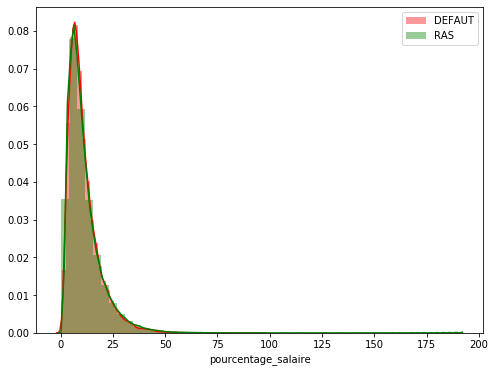

In [163]:
# Création de pourcentage_salaire pour les datasets ras_df et defaut_df
ras_df["pourcentage_salaire"] = (ras_df["AMT_ANNUITY"]/ras_df["AMT_INCOME_TOTAL"])*100
defaut_df["pourcentage_salaire"] = (defaut_df["AMT_ANNUITY"] / defaut_df["AMT_INCOME_TOTAL"])*100


# Visualisation de la variable pourcentage_salaire
plt.figure(figsize=(8,6))
sns.distplot(defaut_df["pourcentage_salaire"], label="DEFAUT", color='r')
sns.distplot(ras_df["pourcentage_salaire"], label="RAS", color='g')
plt.legend()

**Analyse:**<br/>
Aucune différence de distribution entre les individus ayant fait défaut et les autres.

In [38]:
# Dimensions de df_eda
df_eda.shape

(307511, 40)

In [164]:
# Dimensions de df5 (il n'y a pas pourcentage salaire)
df5.shape

(307511, 39)

---
**Enregistrement de df_eda et df5**

In [165]:
with open('df_eda', 'wb') as fichier:
    df_eda_pickler = pickle.Pickler(fichier)
    df_eda_pickler.dump(df_eda)
    
with open('df5', 'wb') as fichier:
    df5_pickler = pickle.Pickler(fichier)
    df5_pickler.dump(df5)

---

# II. Pré-Traitement des données

---
**Récupération des données**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle  


# Récupération de df
with open('df', 'rb') as fichier:
    df_depickler = pickle.Unpickler(fichier)
    df = df_depickler.load()

# Montants
montant_df = ex.selection_variables(df, ['AMT_'])

# Nombres
nombre_df = ex.selection_variables(df, ['CNT_'])

# Signalé.e
flag_df = ex.selection_variables(df, ['FLAG_'])

# Numerical informations
num_information_df = ex.selection_variables(df, ['_MEDI', '_MODE','_AVG'])

# Noms
nom_df = ex.selection_variables(df, ['NAME_'])

# Scores
score_df = ex.selection_variables(df, ['EXT_SOURCE_'])

# Autres variables
variables_a_supprimer = list(montant_df.columns)  + list(nombre_df.columns) + list(flag_df.columns) + list(num_information_df.columns) + list(nom_df.columns) + list(score_df.columns)
autres_variables_df = df.drop(variables_a_supprimer, axis=1)


# Récupération de df_eda
with open('df_eda','rb') as fichier:
    df_eda_depickler = pickle.Unpickler(fichier)
    df_eda = df_eda_depickler.load()

---

## II.A. Encodage & Selection des variables qualitatives.
<div id=selection_var_qualitatives></div>

**Stratégie d'encodage et de sélection des variables qualitatives:**


Durant l'analyse exploratoire on a vu que certaines modalités des variables qualitatives présentaient des proportions différentes d'individus ayant fait défaut ou non par rapport à la proportion totale (8% de défaut) du dataset. C'est le cas, par exemple, pour la modalité self-employed de la variable ORGANIZATION_TYPE qui présente une proportion plus élevée de positifs (donc personnes ayant fait défaut) que la proportion totale sur le dataset. Pour encoder les variables qualitatives, on va utiliser le **one hot encoding** avec la fonction de pandas **get_dummies**. La difficulté avec cette technique et qu'il va en résulter beaucoup de nouvelles variables dans notre dataset (autant que de le nombre totale de modlités de l'ensemble des variables qualitatives du dataset). Pour réduire la dimension de l'ensemble des variables encodées, on ne gardera que les variables qui ont une relation de dépendance significative avec la TARGET. Relation de dépendance que l'on mesurera grâce à des tests de **chi2** avec facteur phi normalisant. Tout sera détaillé.

**Remarque 1**: Pourquoi ne pas utiliser une analyse en composantes multiples (ACM) sur nos variables qualitatives directement afin de sélectionner les axes qui capturent le plus d'inertie ? La réponse est visible <a href=#qualitativesXtarget>ici</a>: toutes nos variables qualitatives possèdent au moins une modalité rare ce à quoi l'ACM est peu robuste (à l'instar de l'ACP avec les outliers). De plus certaines de nos variables qualitatives possèdent un grand nombre de modalités ce qui biaise également le résultat de l'ACM. Nous préférons donc utiliser des tests de chi2 sur les variables encodées binaires en adaptant notre test en fonction de la rareté de la modalité (i.e le nombre de "1" qu'il y a dans la colonne).

**Remarque 2:** Pour un test de chi2 dans le cas de deux variables binaires, la valeur phi (chi2 normalisé) est égale au coefficient de corrélation linéaire r.

**Remarque 3**: Dans notre dataset il n'y a pas de variable qualitatives nominale.

In [2]:
# On copie le dataframe df5 (pp= pre-processing)
df_pp = df_eda.copy()

In [3]:
# Sauvegarde des colonnes ajoutées lors de l'eda
variables_pertinentes_eda = df_pp[["TARGET", 
                                  "SK_ID_CURR", 
                                  "nombre_doc_fournis", 
                                  "demandeur_recurrent",
                                  "high_incomes", 
                                  "pourcentage_salaire"]].copy()

# Sauvegarde des variables pertinentes crées lors de l'eda
with open('variables_pertinentes_eda', 'wb') as fichier:
    variables_pertinentes_eda_pickler = pickle.Pickler(fichier)
    variables_pertinentes_eda_pickler.dump(variables_pertinentes_eda)

# On supprime les variables ajoutées lors de l'eda dans df_pp
df_pp = df_pp.drop(["nombre_doc_fournis", "demandeur_recurrent","high_incomes","pourcentage_salaire"], axis=1).copy()

In [4]:
def encoding_one_hot(df):
    """Prend en paramètre un dataframe: df.
        Retourne: 
            1. df sans les variables qualitatives non encodées 
            2. une liste des nouvelles variables du tableau: modalites_var_qualitatives"""
    
    print("###ENCODAGE###")
    
    # Nombre de colonnes avant le one hot
    Col_Before_Onehot = df.shape[1]

    # Dimensions du tableau AVANT le one hot encoding
    print("\nAVANT l'encodage one hot les dimensions du tableau sont : ",df.shape)

    # Encodage OneHot
    df = pd.get_dummies(df)

    # Dimensions du tableau APRES le one hot encoding
    print("APRES l'encodage one hot les dimensions du tableau sont : ",df.shape)

    # Nombre de colonnes après le one hot
    Col_After_Onehot = df.shape[1]

    # Nombre de variables ajoutées
    print(Col_After_Onehot-Col_Before_Onehot ," colonnes ont été ajoutées.")


    # Création de la liste qui contient les variables "modalités" binaires ajoutées
    modalites_var_qualitatives = []
    for col in df.columns:
        if len(df[col].unique())==2:
            if col!="TARGET":
                modalites_var_qualitatives.append(col)
        
    return df, modalites_var_qualitatives

In [5]:
def contribution_chi2(cont, chi2, X):
    """cont est un tableau de contingence 2x2 sous forme array.
        Cette fonction n'est utile que lorsque la liaison entre les deux variables du tableau de contingence est significative.
        Retourne un rapport sur la contribution des modalités à la dépendance des variables."""
    
    print("\n","\t\t","###CONTRIBUTION###")
    
    # Effectif total
    n=cont[2,2] 
    
    # Coefficients du tableau de contingence
    a, b, c, d = cont[0,0], cont[0,1], cont[1,0], cont[1,1]
    
    # Effectifs théoriques utils pour calculer l'attraction ou la répulsion entre deux variables
    e00, e01, e10, e11  = (cont[0,2]*cont[2,0])/n, (cont[0,2]*cont[2,1])/n, (cont[1,2]*cont[2,0])/n, (cont[1,2]*cont[2,1])/n
    
    # Contribution moyenne de chaque case
    contribution_moyenne = 0.25
    
    # Dictionnaire des effectifs observés et théoriques
    OBSERVE_THEORIQUE = {a:[e00,"TARGET = 0 & X = 0"], 
                         b:[e01,"TARGET = 1 & X = 0"], 
                         c:[e10,"TARGET = 0 & X = 1"], 
                         d:[e11,"TARGET = 1 & X = 1"]}
    
    for o,th in OBSERVE_THEORIQUE.items():
        e = th[0]
        ctr = (((o-e)**2)/e)/chi2
        if ctr>contribution_moyenne:
            if o-e<0:
                print("\n","\t\t","X = ",X)
                print("\t\t","Contribution absolue : {} > Contribution moyenne {}".format(ctr,contribution_moyenne))
                print("\t\t","La contribution de REPULSION {} participe majoritairement à la liaison entre les variables deux variables.".format(th[1]))
            else:
                print("\n","\t\t","X = ",X)
                print("\t\t","Contribution absolue : {} > Contribution moyenne {}".format(ctr,contribution_moyenne))
                print("\t\t","La contribution d'ATTRACTION {} participe majoritairement à la liaison entre les variables deux variables.".format(th[1]))

In [6]:
def chi2_test(df,Y="TARGET"):
    """df est un dataframe non encodé.
        Performe le test de chi2 entre la target binaire et chaque "colonne modalité" des variables qualitatives encodées en OneHot.
        Chaque test effectué est donc établi à partir d'un tableau 2x2.
        Le niveau de test est alpha = 1%.
        Affiche un rapport détaillé des tests et de leur conclusion.
        Retourne:
            1. Le data frame encodé
            2. La liste des modalités significatives
            3. La liste des valeurs phi des modalités significatives
            4. La liste des modalités qui sont sans intéret pour le modèle
            5. La liste des variables à étudier au cas par cas."""
    
    df, modalites_var_qualitatives = encoding_one_hot(df)
    
    print("\n\n","###TESTS SUCCESSIFS###")
    
    # Quantile d'ordre 1-alpha=0.99 de la loi du chi2 à 1ddl
    valeur_seuil_chi2_ddl1 = 6.6349
    
    # Les modalités significatives & les valeurs de phi
    modalites_significatives = []
    phi_values = []
    
    # Les modalités qui ne présentent pas d'intéret
    modalites_sans_interet = []
    
    # Les modalités à étudier au cas par cas (celles pour lesqulles le test ne peut pas s'appliquer)
    a_etudier = []
    
    
    for i in range(len(modalites_var_qualitatives)):

        # Variables Y \ X du tableau de contingence
        X = modalites_var_qualitatives[i]
        Y = Y
        # Tableau de contingence, margin = affichage des effectifs marginaux
        cont = df.loc[:,[X,Y]].pivot_table(index=X, columns=Y,aggfunc=len,margins=True,margins_name="Total")
        cont = cont.to_numpy()
        # Effectifs total
        n=cont[2,2]
        # Coefficients du tableau de contingence, effectifs observés
        a, b, c, d = cont[0,0], cont[0,1], cont[1,0], cont[1,1]
        # Effectifs théoriques
        e_a, e_b, e_c, e_d = (cont[0,2]*cont[2,0]/n), (cont[0,2]*cont[2,1]/n), (cont[1,2]*cont[2,0]/n), (cont[1,2]*cont[2,1]/n)
        
        
        # Si un effectif est trop faible on n'effectue pas le test du chi2.
        if a<=5:
            a_etudier.append(X)
            print("\n\n#####")
            print("La modalité {} = 0 et TARGET = 0 présente un effectif trop faible pour que le test de chi2 soit pertinent.".format(X))
        elif b<=5:
            a_etudier.append(X)
            print("\n\n#####")
            print("La modalité {} = 1 et TARGET = 0 présente un effectif trop faible pour que le test de chi2 soit pertinent.".format(X))
        elif c<=5:
            a_etudier.append(X)
            print("\n\n#####")
            print("La modalité {} = 0 et TARGET = 1 présente un effectif trop faible pour que le test de chi2 soit pertinent.".format(X))
        elif d<=5:
            a_etudier.append(X)
            print("\n\n#####")
            print("La modalité {} = 1 et TARGET = 1 présente un effectif trop faible pour que le test de chi2 soit pertinent.".format(X))
            
        # Effectifs très élevés
        elif (min(a,b,c,d)>=1000):
            nb_tirage = int(0.1*min(a,b,c,d))
            nb_ind_paquet = int(n/nb_tirage)  #Nombre d'individus par paquets
            nb_rejet=0
            for j in range(nb_tirage):
                tab = df.loc[j*nb_ind_paquet:(j+1)*nb_ind_paquet,[X,Y]]
                cont1 = tab.pivot_table(index=X, columns=Y,aggfunc=len,margins=True,margins_name="Total")
                cont1 = cont1.to_numpy()
                # Effectifs total
                n1=cont1[2,2]
                # Coefficients du tableau de contingence, effectifs observés
                o1, o2, o3, o4 = cont1[0,0], cont1[0,1], cont1[1,0], cont1[1,1]
                # Effectifs théoriques
                e1, e2, e3, e4 = (cont1[0,2]*cont1[2,0]/n1), (cont1[0,2]*cont1[2,1]/n1), (cont1[1,2]*cont1[2,0]/n1), (cont1[1,2]*cont1[2,1]/n1)
                # Statistique du chi2
                chi2_1 = ((o1-e1)**2)/e1 + ((o2-e2)**2)/e2 + ((o3-e3)**2)/e3 + ((o4-e4)**2)/e4
                # Statistique du chi2 normalisée
                phi_1 = np.sqrt(chi2_1/n1)
                # Test du chi2
                if phi_1>np.sqrt(valeur_seuil_chi2_ddl1/n1):
                    nb_rejet+=1
            if nb_rejet/nb_tirage>=0.99:
                # Statistique du chi2
                chi2 = ((a-e_a)**2)/e_a + ((b-e_b)**2)/e_b + ((c-e_c)**2)/e_c + ((d-e_d)**2)/e_d
                # Statistique du chi2 normalisée
                phi = np.sqrt(chi2/n)
                phi_values.append(phi)
                print("\n\n#####")
                print("La modalité {} présente une liaison significative avec la TARGET".format(X))
                # On ajoute la modalité à la liste des variables qu'on sélectionnera
                modalites_significatives.append(X)
                # On affiche un tableau récapitulatif
                d = {'Statistiques':["Chi2","Phi"], 'valeur min':[0,0], 'valeur max':['infini',1], 'valeur calculée':[chi2,phi]}
                print("Modalité : ",X,"\n\n", pd.DataFrame(data=d))
                contribution_chi2(cont, chi2, X)
            else:
                modalites_sans_interet.append(X)
            
        else: 
            # Statistique du chi2
            chi2 = ((a-e_a)**2)/e_a + ((b-e_b)**2)/e_b + ((c-e_c)**2)/e_c + ((d-e_d)**2)/e_d
            # Statistique du chi2 normalisée
            phi = np.sqrt(chi2/n)
            # Test du chi2
            if phi>np.sqrt(valeur_seuil_chi2_ddl1/n):
                phi_values.append(phi)
                print("\n\n#####")
                print("La modalité {} présente une liaison significative avec la TARGET".format(X))
                # On ajoute la modalité à la liste des variables qu'on sélectionnera
                modalites_significatives.append(X)
                # On affiche un tableau récapitulatif
                d = {'Statistiques':["Chi2","Phi"], 'valeur min':[0,0], 'valeur max':['infini',1], 'valeur calculée':[chi2,phi]}
                print("Modalité : ",X,"\n\n", pd.DataFrame(data=d))
                contribution_chi2(cont, chi2, X)
            else:
                modalites_sans_interet.append(X)

    
    print("\n###  FIN  ###")
    return df, modalites_significatives, phi_values, modalites_sans_interet, a_etudier

In [7]:
#import warnings
#warnings.filterwarnings("ignore", category=RuntimeWarning) 

df_pp, modalites_significatives, phi_values, modalites_sans_interet, a_etudier = chi2_test(df_pp)

#warnings.filterwarnings("always", category=RuntimeWarning) 

###ENCODAGE###

AVANT l'encodage one hot les dimensions du tableau sont :  (307511, 36)
APRES l'encodage one hot les dimensions du tableau sont :  (307511, 146)
110  colonnes ont été ajoutées.


 ###TESTS SUCCESSIFS###


#####
La modalité REG_REGION_NOT_LIVE_REGION présente une liaison significative avec la TARGET
Modalité :  REG_REGION_NOT_LIVE_REGION 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini         9.560873
1          Phi           0          1         0.005576

 		 ###CONTRIBUTION###

 		 X =  REG_REGION_NOT_LIVE_REGION
		 Contribution absolue : 0.9053495781035817 > Contribution moyenne 0.25
		 La contribution d'ATTRACTION TARGET = 1 & X = 1 participe majoritairement à la liaison entre les variables deux variables.


#####
La modalité CODE_GENDER_XNA = 0 et TARGET = 1 présente un effectif trop faible pour que le test de chi2 soit pertinent.


#####
La modalité NAME_INCOME_TYPE_Maternity leave = 0 et TARGET = 1 présente un effect



#####
La modalité OCCUPATION_TYPE_Security staff présente une liaison significative avec la TARGET
Modalité :  OCCUPATION_TYPE_Security staff 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini        65.984297
1          Phi           0          1         0.014648

 		 ###CONTRIBUTION###

 		 X =  OCCUPATION_TYPE_Security staff
		 Contribution absolue : 0.8991794712890582 > Contribution moyenne 0.25
		 La contribution d'ATTRACTION TARGET = 1 & X = 1 participe majoritairement à la liaison entre les variables deux variables.


#####
La modalité OCCUPATION_TYPE_Waiters/barmen staff présente une liaison significative avec la TARGET
Modalité :  OCCUPATION_TYPE_Waiters/barmen staff 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini        18.718103
1          Phi           0          1         0.007802

 		 ###CONTRIBUTION###

 		 X =  OCCUPATION_TYPE_Waiters/barmen staff
		 Contribution absolue : 0.9



#####
La modalité ORGANIZATION_TYPE_Religion = 1 et TARGET = 1 présente un effectif trop faible pour que le test de chi2 soit pertinent.


#####
La modalité ORGANIZATION_TYPE_Restaurant présente une liaison significative avec la TARGET
Modalité :  ORGANIZATION_TYPE_Restaurant 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini        32.406172
1          Phi           0          1         0.010266

 		 ###CONTRIBUTION###

 		 X =  ORGANIZATION_TYPE_Restaurant
		 Contribution absolue : 0.9138573901162445 > Contribution moyenne 0.25
		 La contribution d'ATTRACTION TARGET = 1 & X = 1 participe majoritairement à la liaison entre les variables deux variables.


#####
La modalité ORGANIZATION_TYPE_School présente une liaison significative avec la TARGET
Modalité :  ORGANIZATION_TYPE_School 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini        57.473931
1          Phi           0          1         



#####
La modalité WALLSMATERIAL_MODE_Monolithic présente une liaison significative avec la TARGET
Modalité :  WALLSMATERIAL_MODE_Monolithic 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini        27.077311
1          Phi           0          1         0.009384

 		 ###CONTRIBUTION###

 		 X =  WALLSMATERIAL_MODE_Monolithic
		 Contribution absolue : 0.9139530506870125 > Contribution moyenne 0.25
		 La contribution de REPULSION TARGET = 1 & X = 1 participe majoritairement à la liaison entre les variables deux variables.


#####
La modalité WALLSMATERIAL_MODE_Wooden présente une liaison significative avec la TARGET
Modalité :  WALLSMATERIAL_MODE_Wooden 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini        19.417643
1          Phi           0          1         0.007946

 		 ###CONTRIBUTION###

 		 X =  WALLSMATERIAL_MODE_Wooden
		 Contribution absolue : 0.9032420561538541 > Contribution moyen

In [8]:
# Enregistrement de df_pp avec les variables encodées
with open('df_pp', 'wb') as fichier:
    df_pp_pickler = pickle.Pickler(fichier)
    df_pp_pickler.dump(df_pp)

In [9]:
# Dataframe contenant les valeurs de phi des modalités les plus significatives
phi_values_df = pd.DataFrame()
phi_values_df["Modalités"] = modalites_significatives
phi_values_df["Valeurs de phi"] = phi_values
phi_values_df.sort_values(by=["Valeurs de phi"], ascending=False, inplace=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 <a list of 44 Text xticklabel objects>)

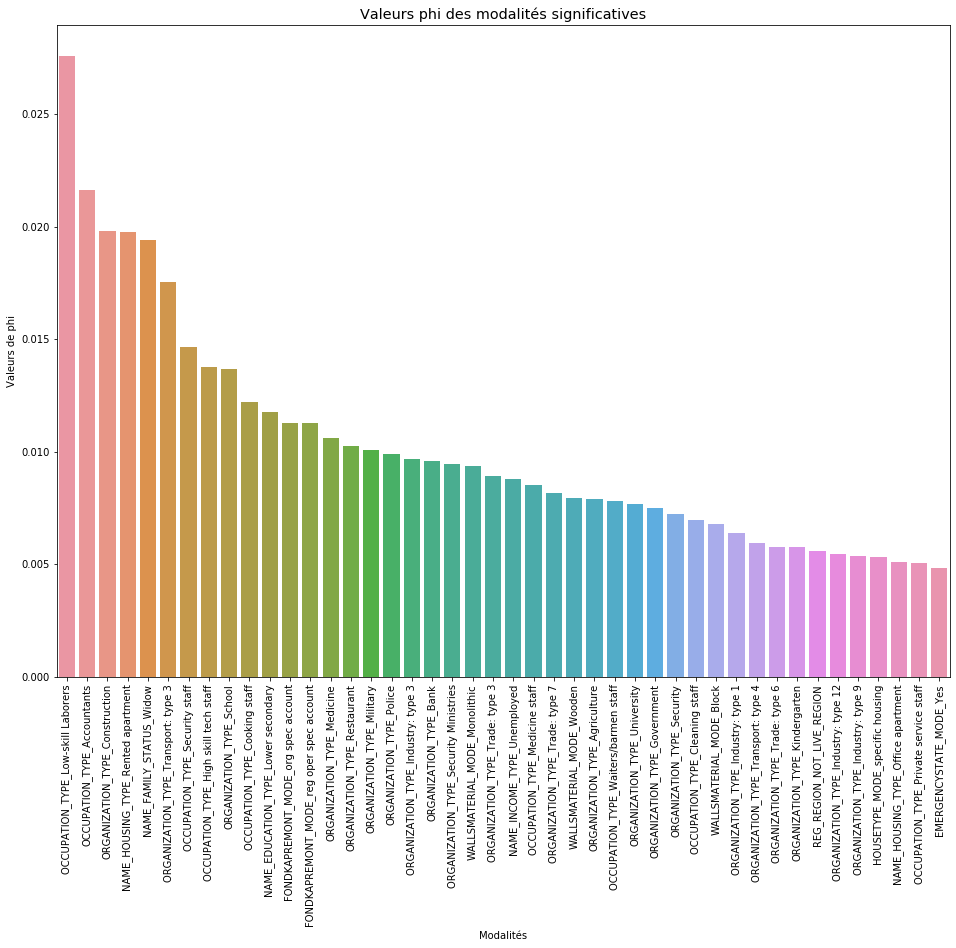

In [10]:
# Affichage des valeurs phi des modalités significatives
plt.figure(figsize=(16,12))
sns.barplot(x="Modalités",y="Valeurs de phi", data=phi_values_df)
#plt.axhline(y=0.01,linewidth=3, color='r')
plt.title("Valeurs phi des modalités significatives", fontsize='x-large')
plt.xticks(rotation=90)

**Analyse des 5 variables ayant les liaisons les plus fortes avec la TARGET:**

- La  modalité "Low_skill_Laborers" de la variable OCCUPATION_TYPE est significativement lié à la variable TARGET. En analysant les contributions, on remarque que cette liaison significative est notamment dûe à la forte **attraction** entre le fait de ne pas rembourser son crédit et d'avoir un travail qui ne nécessite pas de compétence particulière.


- La  modalité "Accountants" de la variable OCCUPATION_TYPE est significativement lié à la variable TARGET. En analysant les contributions, on remarque que cette liaison significative est notamment dûe à la forte **répulsion** entre le fait de ne pas rembourser son crédit et de travailler en tant que comptable.


- La  modalité "Transport: type 3" de la variable ORGANIZATION_TYPE est significativement lié à la variable TARGET. En analysant les contributions, on remarque que cette liaison significative est notamment dûe à la forte **attraction** entre le fait de ne pas rembourser son crédit et de travailler dans le secteur des transports de type 3.


- La  modalité "Rented apartment" de la variable NAME_HOUSING_TYPE est significativement lié à la variable TARGET. En analysant les contributions, on remarque que cette liaison significative est notamment dûe à la forte **attraction** entre le fait de ne pas rembourser son crédit et de vivre dans un appartement de location.


- La  modalité "Widow" de la variable NAME_FAMILY_STATUS est significativement lié à la variable TARGET. En analysant les contributions, on remarque que cette liaison significative est notamment dûe à la forte **répulsion** entre le fait de ne pas rembourser son crédit et d'être veuve/veuf.


- La  modalité "Construction" de la variable ORGANIZATION_TYPE est significativement lié à la variable TARGET. En analysant les contributions, on remarque que cette liaison significative est notamment dûe à la forte **attraction** entre le fait de ne pas rembourser son crédit et de travailler dans le secteur de la construction.

**Analyse des variables qui ont des effectifs "1" trop faibles**
- Nous allons voir si ces modalités présentent des effectifs "TARGET=1" différents de la proportion générales du dataset qui est de 8%.

In [11]:
# Tableaux croisés TARGET & modalités à étudier
for mod in a_etudier:
    tab = df_pp.groupby(["TARGET"]).sum()[mod]
    freq = np.around((tab[1]/(tab[0]+tab[1]))*100, 2)
    print("Pour {}, il y a une proportion de TARGET=1 de {}% .\n".format(mod,freq))

Pour CODE_GENDER_XNA, il y a une proportion de TARGET=1 de 0.0% .

Pour NAME_INCOME_TYPE_Maternity leave, il y a une proportion de TARGET=1 de 40.0% .

Pour NAME_EDUCATION_TYPE_Academic degree, il y a une proportion de TARGET=1 de 1.83% .

Pour NAME_FAMILY_STATUS_Unknown, il y a une proportion de TARGET=1 de 0.0% .

Pour ORGANIZATION_TYPE_Industry: type 8, il y a une proportion de TARGET=1 de 12.5% .

Pour ORGANIZATION_TYPE_Religion, il y a une proportion de TARGET=1 de 5.88% .

Pour ORGANIZATION_TYPE_Trade: type 4, il y a une proportion de TARGET=1 de 3.12% .

Pour ORGANIZATION_TYPE_Trade: type 5, il y a une proportion de TARGET=1 de 6.12% .



**Résultats:**
- On peut supprimer directement NAME_FAMILY_STATUS_Unknown, CODE_GENDER_XNA qui n'apportent aucune information.
- Il intéressant de constater que pour XNA nous n'avons aucune information. Cela pourait être pris en compte dans le biais intrinsèque au dataset.
- Pour les autres variables, on va faire un test de comparaison de proportion pour savoir si ces dernières sont significativement différentes de la proportion TARGET=1 du dataset. **Voir ci-dessous**

In [13]:
# Pourcentage d'individus ayant fait défaut dans le dataset initial
print("{}% des individus de dataset initial ont fait défaut.".format(np.around((np.sum(df["TARGET"]==1,axis=0) / len(df))*100,1)))

8.1% des individus de dataset initial ont fait défaut.


In [14]:
# Effectifs mis en jeu
for mod in a_etudier:
    if (mod !="NAME_FAMILY_STATUS_Unknown")&(mod !="CODE_GENDER_XNA"):
        tab = df_pp.groupby(["TARGET"]).sum()[mod]
        effectif = tab[0]+tab[1]
        print("Effectifs de {} : {} .\n".format(mod,effectif))

Effectifs de NAME_INCOME_TYPE_Maternity leave : 5.0 .

Effectifs de NAME_EDUCATION_TYPE_Academic degree : 164.0 .

Effectifs de ORGANIZATION_TYPE_Industry: type 8 : 24.0 .

Effectifs de ORGANIZATION_TYPE_Religion : 85.0 .

Effectifs de ORGANIZATION_TYPE_Trade: type 4 : 64.0 .

Effectifs de ORGANIZATION_TYPE_Trade: type 5 : 49.0 .



**Description des tests:**

Nous disposons de 6 échantillons d'effectifs respectifs: 
- $n_1 = 5$,
- $n_2 = 164$,
- $n_3 = 24$,
- $n_4 = 85$,
- $n_5 = 64$,
- $n_6 = 49$.

Nous souhaitons savoir si la proportion des individus ayant fait défaut est la même dans les sous populations étudiées que dans le dataset. On va donc confronter les hypothèses suivantes:
$$\text{Pour i} \in \text{{1,2,3,4,5,6}} \\
H_i =
\begin{cases}
H_0 : p_i = p \\
H_1 : p_i \neq{p}
\end{cases}
$$

Un estimateur sans biais de $p$ est $f$, la fréquence du caractère étudié dans la population. On forme donc la statistique suivante:
$$D = f - f_i$$

**Statistique de test:**

Sous $H_0$ et à condition que $n$ et $n_i$ soient suffisamment élevés ( >30), la statistique du test, $U$, suit une loi normale centrée réduite:
$$
U = \frac{D}{\hat{\sigma}_D} = \frac{f - f_i}{\sqrt{f(1-f)(\frac{1}{n}+\frac{1}{n_i})}}
$$

**Région critique:**

Pour un test bilatéral au niveau $\alpha=0.05$, $H_0$ est rejetée lorsque: 
$$
\text{Région critique} : |U| \ge u_{1-\frac{0.05}{2}} = 1.96
$$


**Remarque 1:** L'effectif total $n$ intervient dans la formule de la statistique de test $U$. Etant donné que $n$ est très grand nous allons procéder de la manière suivante: pour chaque sous population nous allons tirer aléatoirement $n = n_i$ individus dans la variables TARGET un nombre de fois élevé (ex: 250 tirages) et effectuer le test statistique autant de fois en notant à chaque fois si on rejète $H_0$ ou non. Les tirages aléatoires sont effectués avec la fonction sample(). Au cours des 5 tests successifs, au maximum $250*164 = 41000$ valeurs vont être tirées aléatoirement parmi $310000$ valeurs soit environ $13$%. On peut donc ignorer les effets liés aux valeurs qui seront tirées plusieurs fois.

**Remarque 2:** Nous n'effectuerons pas le test pour les variables "ORGANIZATION_TYPE_Industry: type 8" & "NAME_INCOME_TYPE_Maternity leave" car les faibles effectifs rendent l'hypothèse de normalité hasardeuse. Pour les autres variables les effectifs sont assez élevés pour que l'hypothèse de normalité soit acceptable.

In [15]:
def test_proportion(echantillon1, echantillon2):
    """
    Les échantillons sont des colonnes ou des sous-échantillons de colonnes binaires (variables binaire 0 ou 1).
    Le caractère étudié est 1.
    Ce test est effectué pour un niveau alpha = 5%.
    """
    if (len(echantillon1)!=0)&(len(echantillon2)!=0):
        n1 = len(echantillon1)
        n2 = len(echantillon2)

        f1 = np.sum(echantillon1, axis=0)/n1
        f2 = np.sum(echantillon2, axis=0)/n2

        D = f1-f2
        sigma = np.sqrt(f1*(1-f1)*((1/n1)+(1/n2)))
        if sigma!=0:
            U = (D/sigma)

            if abs(U)>=1.96:
                return 1
            else:
                return 0
        else:
            return 0
    else:
        return 0

In [16]:
def five_percent_game(sample1,sample2):
    """
    Les samples sont des pd.Series dans lesquelles on prend les paquets pour faire tests successifs, ils ne doivent pas avoir de NaN.
    Par défaut, 250 tirages sont effectués.
    """
    nb_ind_paquet = min(len(sample1),len(sample2)) # Nombre d'individus par paquet
    print("Le nombre d'individus par paquet est : {}.".format(nb_ind_paquet))
    
    nb_tirage = 250 # Nombre de tirages par défaut
    nb_rejet = 0 # Compteur du nombre de rejet de H0
    
    for i in range(250):
        echantillon1 = sample1.sample(nb_ind_paquet)
        echantillon2 = sample2.sample(nb_ind_paquet)
        nb_rejet += test_proportion(echantillon1,echantillon2)
    

    print("La proportion de rejet de H0 est: {}%.".format(np.around(100*(nb_rejet/nb_tirage),2)))

In [17]:
# Tests 1: NAME_EDUCATION_TYPE_Academic degree

sample1 = df_pp.loc[:,"TARGET"].dropna()
sample2 = df_pp.loc[df_pp["NAME_EDUCATION_TYPE_Academic degree"]==1, "TARGET"].dropna()

five_percent_game(sample1,sample2)

Le nombre d'individus par paquet est : 164.
La proportion de rejet de H0 est: 53.2%.


In [18]:
# Tests 2: ORGANIZATION_TYPE_Religion

sample1 = df_pp.loc[:,"TARGET"].dropna()
sample2 = df_pp.loc[df_pp["ORGANIZATION_TYPE_Religion"]==1, "TARGET"].dropna()

five_percent_game(sample1,sample2)

Le nombre d'individus par paquet est : 85.
La proportion de rejet de H0 est: 0.4%.


In [19]:
# Tests 3: ORGANIZATION_TYPE_Trade: type 4

sample1 = df_pp.loc[:,"TARGET"].dropna()
sample2 = df_pp.loc[df_pp["ORGANIZATION_TYPE_Trade: type 4"]==1, "TARGET"].dropna()

five_percent_game(sample1,sample2)

Le nombre d'individus par paquet est : 64.
La proportion de rejet de H0 est: 1.2%.


In [20]:
# Tests 4: ORGANIZATION_TYPE_Trade: type 5

sample1 = df_pp.loc[:,"TARGET"].dropna()
sample2 = df_pp.loc[df_pp["ORGANIZATION_TYPE_Trade: type 5"]==1, "TARGET"].dropna()

five_percent_game(sample1,sample2)

Le nombre d'individus par paquet est : 49.
La proportion de rejet de H0 est: 0.0%.


**Conclusion:**
- Nous ne gardons aucune de ces variables pour l'entrainement du modèle car aucun test n'a rejeté l'hypothse nulle assez de fois sur les 250 tirages.

In [22]:
# Toutes les modalités sans intéret
modalites_sans_interet = modalites_sans_interet + ["NAME_EDUCATION_TYPE_Academic degree","ORGANIZATION_TYPE_Religion","ORGANIZATION_TYPE_Trade: type 4","ORGANIZATION_TYPE_Trade: type 5","ORGANIZATION_TYPE_Industry: type 8","NAME_INCOME_TYPE_Maternity leave"] + ["NAME_FAMILY_STATUS_Unknown","CODE_GENDER_XNA"] 

---
**Enregistrement de phi_values_df & modalites_sans_interet**

In [23]:
with open('phi_values_df', 'wb') as fichier:
    phi_values_df_pickler = pickle.Pickler(fichier)
    phi_values_df_pickler.dump(phi_values_df)
    
with open('modalites_sans_interet', 'wb') as fichier:
    modalites_sans_interet_pickler = pickle.Pickler(fichier)
    modalites_sans_interet_pickler.dump(modalites_sans_interet)

---

## II.B. Sélection des variables quantitatives.

Dans cette partie, nous allons sélectionner les variables quantitatives qui présentent une relation de dépendance avec la target. Nous allons traiter les variables discrètes et les variables continues séparemment. 

**Démarche pour les variables quantitatives continues:**

Pour chaque variable continue nous allons effectuer le  test de student suivant:

$$
\begin{cases}
H_0 : \mu_0 = \mu_1 \text{avec }\mu_i \text{ la moyenne du sous-échantillon de la variable quantitatives continue pour TARGET=i} \\
H_1 : \mu_0 \neq \mu_1
\end{cases}
$$

**Démarche pour les variables quantitatives discrètes:**

Pour chaque variable discrète, nous allons effectuer un test de chi2 adapté aux tables de grande taille. On utilisera la statistique V de Cramer (indépendante de la taille de la table mais également de $n$, la taille de l'échantillon) définie comme suit:

$$
V = \sqrt{\frac{\chi^2}{n*min(L-1,C-1)}}
$$

In [24]:
variables_quantitatives = list(df_pp.columns[df_pp.dtypes=="float64"])

In [25]:
for var in variables_quantitatives:
    print("{} nombre de valeurs prises: {} .".format(var, len(df_pp[var].unique())))

AMT_INCOME_TOTAL nombre de valeurs prises: 2211 .
AMT_CREDIT nombre de valeurs prises: 5603 .
AMT_ANNUITY nombre de valeurs prises: 13673 .
DAYS_BIRTH nombre de valeurs prises: 17460 .
DAYS_EMPLOYED nombre de valeurs prises: 12574 .
DAYS_REGISTRATION nombre de valeurs prises: 15688 .
DAYS_ID_PUBLISH nombre de valeurs prises: 6168 .
OWN_CAR_AGE nombre de valeurs prises: 63 .
CNT_FAM_MEMBERS nombre de valeurs prises: 18 .
EXT_SOURCE_1 nombre de valeurs prises: 114585 .
EXT_SOURCE_2 nombre de valeurs prises: 119832 .
EXT_SOURCE_3 nombre de valeurs prises: 815 .
LIVINGAREA_AVG nombre de valeurs prises: 5200 .
DEF_60_CNT_SOCIAL_CIRCLE nombre de valeurs prises: 10 .
AMT_REQ_CREDIT_BUREAU_YEAR nombre de valeurs prises: 26 .


In [26]:
quantitatives_continues = []
quantitatives_discretes = []

for var in variables_quantitatives:
    if  len(df_pp[var].unique())<=100:
        quantitatives_discretes.append(var)
    else:
        quantitatives_continues.append(var)

**Test de student: variables quantitatives.**

In [27]:
from scipy.stats import ttest_ind

In [28]:
def ttest(sample1, sample2, nb_individus_paquet, alpha):
    """
    sample1 et sample2 sont les pd.Series dans lesquelles on prend les paquets pour faire 
    les ttest_ind successifs, elles ne doivent pas avoir de NaN.
    """
    nb_1 = len(sample1)/nb_individus_paquet
    nb_2 = len(sample2)/nb_individus_paquet
    nb_paquets = int(min([nb_1,nb_2])) # Nombre de paquets à faire
    nb_rejet = 0 # Nombre de rejet de H0
    for i in range(nb_paquets):
        p_valeur = ttest_ind(sample1[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1],
                  sample2[i*nb_individus_paquet:(i+1)*nb_individus_paquet+1]).pvalue
        if p_valeur<=alpha:
            nb_rejet+=1
    print(nb_paquets," paquets ont été testés.")
    print("La proportion de rejet de H0 est: {}".format(np.around(nb_rejet/nb_paquets, 3)))
    return nb_rejet/nb_paquets

In [29]:
continues_sans_interet = []

# Tests successifs
for var in quantitatives_continues:
    sample1 = df_pp.loc[df_pp["TARGET"]==0, var].dropna()
    sample2 = df_pp.loc[df_pp["TARGET"]==1, var].dropna()
    print("\n\nOn teste la variable: {} .".format(var))
    proportion_rejet = ttest(sample1, sample2, 300, 0.05)
    if (proportion_rejet<0.5):
        continues_sans_interet.append(var)



On teste la variable: AMT_INCOME_TOTAL .
80  paquets ont été testés.
La proportion de rejet de H0 est: 0.1


On teste la variable: AMT_CREDIT .
82  paquets ont été testés.
La proportion de rejet de H0 est: 0.305


On teste la variable: AMT_ANNUITY .
82  paquets ont été testés.
La proportion de rejet de H0 est: 0.073


On teste la variable: DAYS_BIRTH .
82  paquets ont été testés.
La proportion de rejet de H0 est: 0.927


On teste la variable: DAYS_EMPLOYED .
72  paquets ont été testés.
La proportion de rejet de H0 est: 0.944


On teste la variable: DAYS_REGISTRATION .
82  paquets ont été testés.
La proportion de rejet de H0 est: 0.463


On teste la variable: DAYS_ID_PUBLISH .
82  paquets ont été testés.
La proportion de rejet de H0 est: 0.622


On teste la variable: EXT_SOURCE_1 .
33  paquets ont été testés.
La proportion de rejet de H0 est: 1.0


On teste la variable: EXT_SOURCE_2 .
82  paquets ont été testés.
La proportion de rejet de H0 est: 1.0


On teste la variable: EXT_SOURCE_

**Conclusion:**

- On garde les variables EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, DAYS_EMPLOYED & DAYS_BIRTH.
- On garde également DAYS_ID_PUBLISH dont on a rejeté H0 dans plus de 60% des cas.
- On pourra, à partir de ces variables, créer des variables polynomiales.

In [30]:
# On ajoute les variables continues sans intéret à l'ensemble des variables sans interet
modalites_sans_interet = modalites_sans_interet + continues_sans_interet

**Test de chi2 avec V de Cramer.**

In [31]:
from scipy.stats import chi2_contingency

In [32]:
def V_cramer_test(df, variables_quant_disc, Y="TARGET"):
    """
    df est un dataframe.
    variables_quant_disc est la liste des variables quantitatives discrètes à tester.
    Performe le test de chi2 avec la statistique V entre la target binaire et chaque colonne quantitative discrète.
    Chaque test effectué est donc établi à partir d'un tableau 2x(Nombre de modalités de la variables)
    Le niveau de test est alpha = 1%.
    Affiche un rapport détaillé des tests et de leur conclusion.
    Retourne:
        1. La liste des variables significativement dépendantes de la TARGET.
        2. La liste des valeurs V des variables significatives.
        3. La liste des variables qui sont sans intéret pour le modèle.
        4. La liste des variables à étudier au cas par cas."""
    
    print("###TESTS SUCCESSIFS###")
    
    # Les modalités significatives & les valeurs de V
    modalites_significatives = []
    V_values = []
    
       
    for i in range(len(variables_quant_disc)):
        
        # Tableau de contingence
        X = variables_quant_disc[i]
        Y = "TARGET"
        cont_df = df.loc[:,[X,Y]].pivot_table(index=X, columns=Y,aggfunc=len,margins=True,margins_name="Total").dropna(axis=0)

        # Degré de liberté
        L = len(cont_df)-1
        C = 2
        ddl = L-1
        
        # Seuil correspondant au degré de liberté pour alpha = 1%
        print("\n\n#####")
        print("ddl = ", ddl)
        print("Entrez la valeur du seuil correspondant au ddl avec alpha=1%:")
        seuil = float(input())

        # Conversion en tableau numpy
        cont = cont_df.to_numpy()
        
        # Effectifs totaux
        n=cont[L,2]
        
        # Calcul de la statistique de chi2
        chi2 = chi2_contingency(cont)[0]
    
        # Calcul de la statistique V
        V = np.sqrt(chi2/(n*min(L-1,C-1)))
        
        # Test
        if (V>=np.sqrt(seuil/(n*min(L-1,C-1)))):
            V_values.append(V)
            print("\n\nLa modalité {} présente une liaison significative avec la TARGET".format(X))
            # On ajoute la modalité à la liste des variables qu'on sélectionnera
            modalites_significatives.append(X)
            # On affiche un tableau récapitulatif
            d = {'Statistiques':["Chi2","V"], 'valeur min':[0,0], 'valeur max':['infini',1], 'valeur calculée':[chi2,V]}
            print("Variable : ",X,"\n\n", pd.DataFrame(data=d))
        else:
            modalites_sans_interet.append(X)
        
    return modalites_significatives, V_values, modalites_sans_interet

In [33]:
modalites_significatives, V_values, modalites_sans_interet = V_cramer_test(df_pp,quantitatives_discretes)

###TESTS SUCCESSIFS###


#####
ddl =  47
Entrez la valeur du seuil correspondant au ddl avec alpha=1%:
76


La modalité OWN_CAR_AGE présente une liaison significative avec la TARGET
Variable :  OWN_CAR_AGE 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini       406.017278
1            V           0          1         0.062308


#####
ddl =  8
Entrez la valeur du seuil correspondant au ddl avec alpha=1%:
20


La modalité CNT_FAM_MEMBERS présente une liaison significative avec la TARGET
Variable :  CNT_FAM_MEMBERS 

   Statistiques  valeur min valeur max  valeur calculée
0         Chi2           0     infini       143.347545
1            V           0          1         0.021591


#####
ddl =  5
Entrez la valeur du seuil correspondant au ddl avec alpha=1%:
15.1


La modalité DEF_60_CNT_SOCIAL_CIRCLE présente une liaison significative avec la TARGET
Variable :  DEF_60_CNT_SOCIAL_CIRCLE 

   Statistiques  valeur min valeur max  valeur calculée


In [34]:
# Dataframe contenant les valeurs de V des variables les plus significativement dépendantes de la TARGET
V_values_df = pd.DataFrame()
V_values_df["Variables"] = modalites_significatives
V_values_df["Valeurs de V"] = V_values
V_values_df.sort_values(by=["Valeurs de V"], ascending=False, inplace=True)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

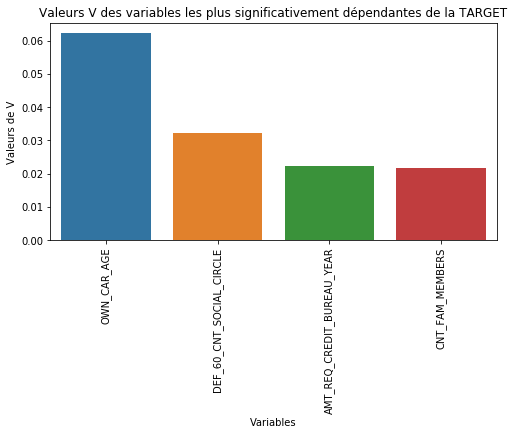

In [35]:
# Affichage des valeurs V des variables les plus significativement dépendantes de la TARGET
plt.figure(figsize=(8,4))
sns.barplot(x="Variables",y="Valeurs de V", data=V_values_df)
#plt.axhline(y=0.01,linewidth=3, color='r')
plt.title("Valeurs V des variables les plus significativement dépendantes de la TARGET", fontsize='large')
plt.xticks(rotation=90)

In [36]:
# On ajoute les variables qui on un V inférieur à 5% aux variables sans intéret
variables_sans_interet = list(modalites_sans_interet) + ["DEF_60_CNT_SOCIAL_CIRCLE","AMT_REQ_CREDIT_BUREAU_YEAR","CNT_FAM_MEMBERS"]

---
**Enregistrement de variables_sans_intéret et V_values_df**

In [37]:
with open('variables_sans_interet', 'wb') as fichier:
    variables_sans_interet_pickler = pickle.Pickler(fichier)
    variables_sans_interet_pickler.dump(variables_sans_interet)
    
with open('V_values_df', 'wb') as fichier:
    V_values_df_pickler = pickle.Pickler(fichier)
    V_values_df_pickler.dump(V_values_df)

---

## II.C. Baseline et premiers modèles

### Baseline et premier modèle

On va dans cette partie établir un modèle de base qui nous servira de point de comparaison pour nos futurs algorithmes. **Comment établir ce modèle ?**

Notre objectif est de prédire si un individu va ou ne va pas rembourser son prêt à la banque. Dans cette optique, on aimerait limiter le taux de faux-négatifs  (i.e. le taux personnes à qui on accorde un prêt alors qu'elles vont faire défaut) car ce sont ces individus qui feront perdre le plus d'argent. C'est la situation que l'on veut éviter en premier lieu. Pour cette raison, on va faire une baseline qui indique tout le monde "positif" (1 = la personne a fait défaut), de cette manière, on n'aura aucun faux-négatif. En revanche, les prédictions ne seront pas précises car il y aura un taux très élevé de faux-positifs  (i.e. le taux de personnes à qui on n'accorde pas un prêt alors qu'elles l'auraient remboursé). On comparera donc nos futurs modèles à ce modèle de référence. **Nos futurs modèles devront avoir un meilleur score que la baseline.** Justement quel score choisir ?

Quand on veut "améliorer le score", il faut s'assurer d'avoir choisi le bon score, celui qui rendra le mieux compte de la performance réel de notre algorithme. Dans notre cas, on a une variable cible binaire qui présente des effectifs déséquilibrés: 92% de "0" & 8% de "1". Un algorithme comme notre baseline aura un recall maximal. Si on ne se fondait que sur cette valeur, nous ignorerons qu'en réalité notre algorithme fait une mauvaise prédiction dans 92% des cas... C'est pour cette raison qu'il est nécessaire d'utiliser un score adapté à notre problématique. Dans notre cas, on choisit le score F1 qui est une bonne synthèse de la précision et du recall. On affichera également les valeurs de *Area Under The ROC Curve* (AUC ROC) mais ce n'est pas ce score qu'on cherchera à améliorer en priorité car il a tendance à être optimiste quant à la performance réelle du modèle.

- Score : **F1**
- Baseline: **Classification naïve qui ne retourne que des valeurs positives**

Calculons le score F1 de notre baseline:
$$F1 = 2*\frac{Précision*Rappel}{Présicion+Rappel }$$
où 
$$Présicion = \frac{TP}{TP + FP} = \frac{0.08}{0.08 + 0.92} = 8\%$$
&
$$Rappel = \frac{TP}{TP + FN} = \frac{0.08}{0.08 + 0} = 100\%$$
donc
$$F1 = 2*\frac{0.08*1}{0.08+ 1} = 15\%$$

Nos futurs modèles devront donc avoir un meilleur score F1 que 15%.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle  

# Récupération de df_eda
with open('df_eda','rb') as fichier:
    df_eda_depickler = pickle.Unpickler(fichier)
    df_eda = df_eda_depickler.load()
    
# Récupération de variables_sans_interet
with open('variables_sans_interet','rb') as fichier:
    variables_sans_interet_depickler = pickle.Unpickler(fichier)
    variables_sans_interet = variables_sans_interet_depickler.load()

# Récupération de df_pp
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()

# On supprime les variables sans intéret
df_pp = df_pp.drop(variables_sans_interet,axis=1)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

In [3]:
# Split train / test
train, test = train_test_split(df_pp, test_size=0.2, random_state=0)

In [4]:
baseline_y_train = train["TARGET"]
baseline_train = train.drop(["TARGET"], axis=1).copy()

baseline_y_test = test["TARGET"]
baseline_test = test.drop(["TARGET"], axis=1).copy()

In [5]:
# Modèle de base 
baseline_model = DummyClassifier(strategy="constant", constant=1)

In [6]:
print(baseline_train.shape)
print(baseline_test.shape)

(246008, 53)
(61503, 53)


In [7]:
baseline_model.fit(baseline_train, baseline_y_train)

DummyClassifier(constant=1, random_state=None, strategy='constant')

In [8]:
baseline_prediction = baseline_model.predict(baseline_test)

print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(baseline_y_test, baseline_prediction))
print("\n\n\n\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(baseline_y_test, baseline_prediction, zero_division=0))

### MATRICE DE CONFUSION ### 

[[    0 56648]
 [    0  4855]]




 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56648
           1       0.08      1.00      0.15      4855

    accuracy                           0.08     61503
   macro avg       0.04      0.50      0.07     61503
weighted avg       0.01      0.08      0.01     61503



On a exactement les résultats auxquels on s'attendait **F1 = 15%**.

Text(0, 0.5, 'Sensibilité')

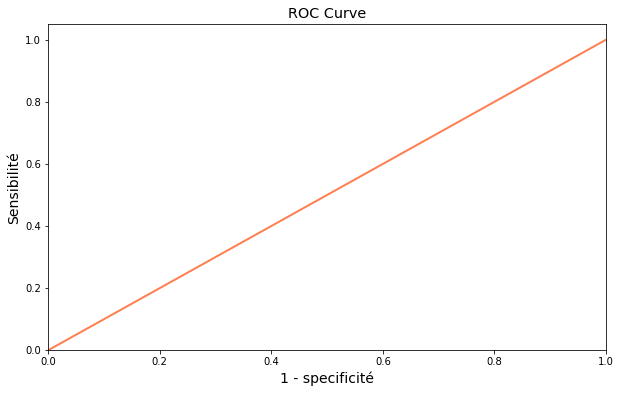

In [9]:
# Affichage de la ROC curve

baseline_proba_pred = baseline_model.predict_proba(baseline_test)[:,1]

# False Positive rates, True Positive rates & Threshold
[fpr, tpr, thr] = roc_curve(baseline_y_test, baseline_proba_pred)

# Affichage
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve", fontsize="x-large")
plt.xlabel('1 - specificité', fontsize=14)
plt.ylabel('Sensibilité', fontsize=14)

In [10]:
print("Les valeurs de seuil sont: ", thr,".")

Les valeurs de seuil sont:  [2. 1.] .


**Analyse de la roc curve:**

Résultat tout à fait cohérent avec ce qui est attendu de notre baseline. En effet, pour le point en (0,0) qui correspond à un seuil strictement supérieur à un, il n'y a aucun point ayant un score strictement supérieur à 1 donc TPR = 0 et FPR = 0. En revanche, toutes les prédictions seront comprises pour chaque valeurs de seuil inférieure ou égal à 1. Donc, pour tout seuil inférieur ou égal à 1, on a TPR = 1 et FPR =1 ce qui correspond au point en (1,1).

In [11]:
# Split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Evaluation des modèles
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

In [12]:
# Colonnes utile pour aller chercher de nouvelles variables dans les autres dataset
ID_feature = df_pp["SK_ID_CURR"].copy()

# Suppression dans df_pp
df_pp = df_pp.drop(["SK_ID_CURR"], axis=1).copy()

In [13]:
# Séparation des variables qualitatives continues et des variables qualitatives discrètes

numerical_features = []
categorical_features = []

for col in df_pp.columns:
    if df_pp[col].dtypes=='float64':
        numerical_features.append(col)
    else:
        if col!="TARGET":
            categorical_features.append(col)

In [14]:
# Split Train / Test
train, test = train_test_split(df_pp, test_size=0.2, random_state=0)

In [15]:
# Séparation de la target pour le trainset
y_train = train["TARGET"]
X_train = train.drop(["TARGET"], axis=1).copy()

# Séparation de la target pour le trainset
y_test = test["TARGET"]
X_test = test.drop(["TARGET"], axis=1).copy()

# Affichage des dimensions
print("Dimension de X_train : {} .".format(X_train.shape))
print("Dimension de X_test : {} .".format(X_test.shape))

Dimension de X_train : (246008, 52) .
Dimension de X_test : (61503, 52) .


In [16]:
# Pipeline pour RandomForest (RF) et GradientBoosting

categorical_pipeline_RF = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline_RF = make_pipeline(SimpleImputer(strategy='median'))

preprocessor_RF = make_column_transformer((numerical_pipeline_RF, numerical_features),
                                                                    (categorical_pipeline_RF, categorical_features))

random_forest_clf = make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 0))
gradient_boosting_clf =  make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 0))

In [17]:
random_forest_clf.fit(X_train,y_train)
gradient_boosting_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [18]:
print("\n\n\n\n### RANDOM FOREST CLASSIFIER ###\n")

# Matrice de confusion et rapport
clf_prediction = random_forest_clf.predict(X_test)

print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, clf_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, clf_prediction, zero_division=0))



print("\n\n\n\n### GRADIENT BOOSTING CLASSIFIER ###\n")

# Matrice de confusion et rapport
gradient_prediction = gradient_boosting_clf.predict(X_test)

print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, gradient_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, gradient_prediction, zero_division=0))





### RANDOM FOREST CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[56574    74]
 [ 4796    59]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.44      0.01      0.02      4855

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503





### GRADIENT BOOSTING CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[56574    74]
 [ 4796    59]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56648
           1       0.44      0.01      0.02      4855

    accuracy                           0.92     61503
   macro avg       0.68      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 <a list of 52 Text xticklabel objects>)

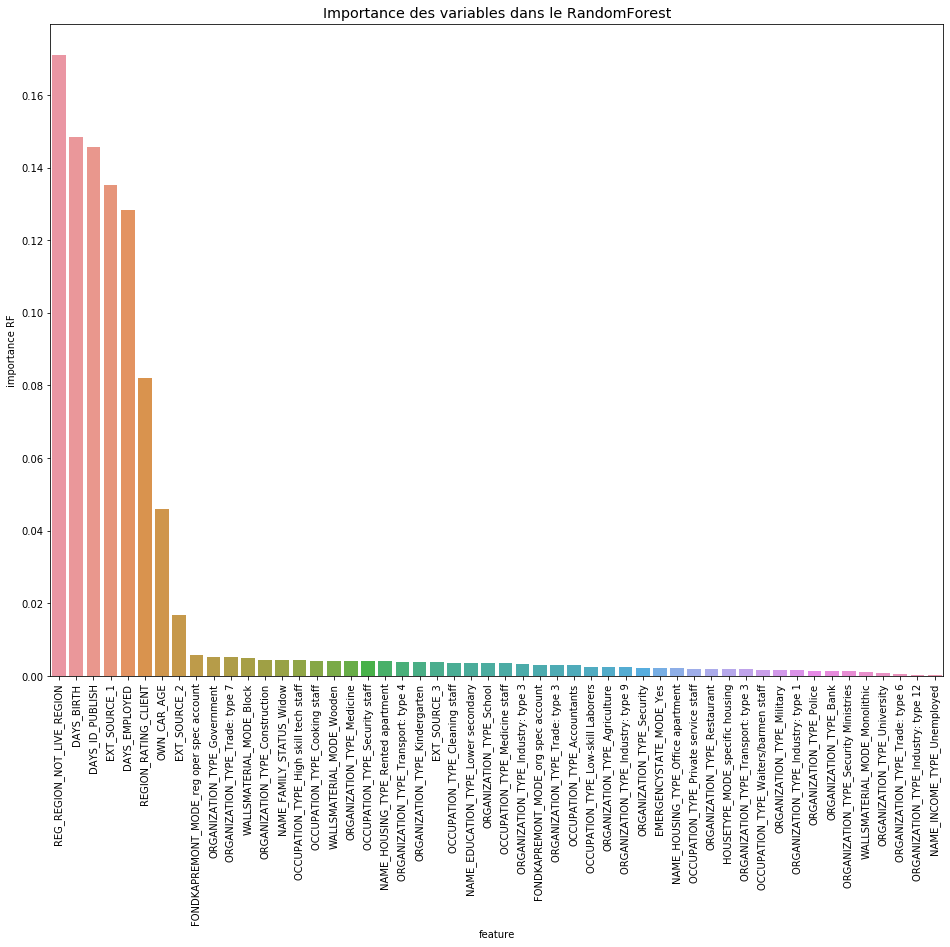

In [19]:
# Importance des variables Random Forest (RF)
feature_importance_values_RF = random_forest_clf[1].feature_importances_
feature_importance_RF_df = pd.DataFrame({'feature': X_train.columns, 'importance RF': feature_importance_values_RF})

feature_importance_RF_df.sort_values(by=["importance RF"], ascending=False, inplace=True)

plt.figure(figsize=(16,12))
sns.barplot(x="feature",y="importance RF", data=feature_importance_RF_df)
#plt.axhline(y=0.01,linewidth=3, color='r')
plt.title("Importance des variables dans le RandomForest", fontsize='x-large')
plt.xticks(rotation=90)

**Analyse des premiers résultats**

- RandomForest et GradientBoosting donnent exactement les mêmes résultats.
- Le score F1 obtenu est extrèmement faible: 2%.
- Le modèle n'a casiment pris en compte que 8 variables (dont une qui a jusqu'à 40 fois plus d'importance). 

**Première solution**:

- Avant de resampler notre trainset, nous allons tenter quelques modifications.
- Nous n'allons entrainer qu'un RandomForestClassifier pour que l'entrainement se fasse plus rapidement.
- Nous allons ajouter les variables crées à partir de l'eda et nous allons garder toutes les variables qualitatives retenues à l'issue des tests de chi2.
- On va ajouter dans la pipeline un selecteur de variables: pour les variables catégorielles, la sélection sera fondée sur un test de chi2 et pour les variables numériques, la sélection sera fondée sur un test de ANOVA.

In [24]:
# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# On réinitialise df_pp et on supprime de nouveau les variables sans intéret 
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

In [25]:
# Split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler

# Modèle
from sklearn.ensemble import RandomForestClassifier

# Selection variables
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold

# Feature engineering 
from sklearn.preprocessing import PolynomialFeatures

# Evaluation du modèle
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

# On supprime la colonne TARGET de variables_pertinentes_eda
variables_pertinentes_eda = variables_pertinentes_eda.drop(["TARGET"], axis=1)

# Jointure des variables pertinentes de l'eda et de df_pp
df_domain_features = df_pp.merge(variables_pertinentes_eda, on = 'SK_ID_CURR', how = 'left')

# Suppression de SK_ID_CURR
df_domain_features = df_domain_features.drop(["SK_ID_CURR"], axis=1)


### Séparation des variables qualitatives continues et des variables qualitatives discrètes ###
numerical_features = []
categorical_features = []

for col in df_domain_features.columns:
    if df_domain_features[col].dtypes=='float64':
        numerical_features.append(col)
    else:
        if col!="TARGET":
            categorical_features.append(col)
            
            
# Split Train / Test
train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)       

# Séparation de la target pour le trainset
y_train = train["TARGET"]
X_train = train.drop(["TARGET"], axis=1).copy()

# Séparation de la target pour le trainset
y_test = test["TARGET"]
X_test = test.drop(["TARGET"], axis=1).copy()

# Affichage des dimensions
print("Dimensions de X_train : {} .".format(X_train.shape))
print("Dimensions de X_test : {} .".format(X_test.shape))

Dimensions de X_train : (246008, 56) .
Dimensions de X_test : (61503, 56) .


In [26]:
# Pipeline pour RandomForest
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), SelectKBest(chi2, k=2))
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler(), SelectKBest(f_classif, k=2))

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                                                    (categorical_pipeline, categorical_features))

random_forest_clf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators = 100, random_state = 0))

In [27]:
random_forest_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [28]:
# Matrice de confusion et rapport
clf_prediction = random_forest_clf.predict(X_test)

print("### RANDOM FOREST CLASSIFIER ###\n")

print("### MATRICE DE CONFUSION ###","\n")

print(confusion_matrix(y_test, clf_prediction))

print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")

print(classification_report(y_test, clf_prediction, zero_division=0))

### RANDOM FOREST CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[54452  2196]
 [ 4493   362]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     56648
           1       0.14      0.07      0.10      4855

    accuracy                           0.89     61503
   macro avg       0.53      0.52      0.52     61503
weighted avg       0.86      0.89      0.88     61503



**Analyse du modèle:**
- On a amélioré le score F1 (10%) mais il reste inférieur à la baseline.
- Le modèle a fourni les meilleurs résultats avec uniquement 4 variables. 
- Nous n'allons pas continuer dans cette direction et tenter d'améliorer ce modèle, nous allons recommencer en échantillonnant différemment notre trainset.

### Diagnostique du premier modèle.


**Echantillonnage:**
- Nous allons utiliser une technique simple d'échantillonnage: **Random Undersampling**.
- On peut faire de l'undersampling car nos données nous le permettent: en effet, notre dataset (resp. notre trainset) contient 8,1% de TARGET=1 ce qui correspond à environ 20 000 individus (en ayant mis de coté 20% du dataset dans le testset). En prenant un sous-échantillon du trainset avec 50% de positifs et 50% de négatifs, on aura donc un nouveau trainset contenant environ 40 000 individus ce qui est largement assez pour faire du MachineLearning.

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle  

# Récupération de df
with open('df', 'rb') as fichier:
    df_depickler = pickle.Unpickler(fichier)
    df = df_depickler.load()

# Récupération de df_eda
with open('df_eda','rb') as fichier:
    df_eda_depickler = pickle.Unpickler(fichier)
    df_eda = df_eda_depickler.load()
    
# Récupération de df_pp et on supprime les variables sans intéret
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

In [30]:
# Split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler

# Modèles
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


# Evaluation des modèles
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

# Colonnes utile pour aller chercher de nouvelles variables dans les autres dataset
ID_feature = df_pp["SK_ID_CURR"].copy()
            
# Split Train / Test
train, test = train_test_split(df_pp, test_size=0.2, random_state=0)

In [31]:
# On prend toutes les valeurs positives de target qu'on met dans individus_positifs_df
individus_positifs_df = train.loc[train["TARGET"]==1,:].copy()
n_positifs = individus_positifs_df.shape[0]
print("Dimensions du sous-échantillon ne contenant que des individus positifs : {} .".format(individus_positifs_df.shape))

Dimensions du sous-échantillon ne contenant que des individus positifs : (19970, 54) .


In [32]:
# On prend (de manière aléatoire dans le trainset) autant de négatifs que de positifs 
individus_negatifs_df = train.loc[train["TARGET"]==0,:].sample(n_positifs, random_state=0)
print("Dimensions du sous-échantillon ne contenant que des individus négatifs : {} .".format(individus_negatifs_df.shape))

Dimensions du sous-échantillon ne contenant que des individus négatifs : (19970, 54) .


In [33]:
# On regroupe les deux sous-echantillons pour former le subtrain 50/50
subtrain = pd.concat([individus_positifs_df,individus_negatifs_df])
print("Dimensions de subtrain : {} .".format(subtrain.shape))

Dimensions de subtrain : (39940, 54) .


In [34]:
# On "mélange" les positis et les négatifs dans le dataset
subtrain.sort_values(by=["SK_ID_CURR"], ascending=True, inplace=True)

In [35]:
# On supprime la colonne SK_ID_CURR
subtrain = subtrain.drop(["SK_ID_CURR"], axis=1)
test = test.drop(["SK_ID_CURR"], axis=1)

In [36]:
# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []

for col in subtrain.columns:
    if subtrain[col].dtypes=='float64':
        numerical_features.append(col)
    else:
        if col!="TARGET":
            categorical_features.append(col)

In [37]:
# Séparation de la target pour le trainset
y_train = subtrain["TARGET"]
X_train = subtrain.drop(["TARGET"], axis=1).copy()

# Séparation de la target pour le trainset
y_test = test["TARGET"]
X_test = test.drop(["TARGET"], axis=1).copy()

# Affichage des dimensions
print("Dimensions de X_train : {} .".format(X_train.shape))
print("Dimensions de X_test : {} .".format(X_test.shape))

Dimensions de X_train : (39940, 52) .
Dimensions de X_test : (61503, 52) .


In [38]:
# Pipeline pour RandomForest (RF) et GradientBoosting

categorical_pipeline_RF = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline_RF = make_pipeline(SimpleImputer(strategy='median'))

preprocessor_RF = make_column_transformer((numerical_pipeline_RF, numerical_features),
                                                                    (categorical_pipeline_RF, categorical_features))

random_forest_clf = make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 0))
gradient_boosting_clf =  make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 0))

In [39]:
random_forest_clf.fit(X_train,y_train)
gradient_boosting_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [40]:
print("\n\n\n\n### RANDOM FOREST CLASSIFIER ###\n")

# Matrice de confusion et rapport
clf_prediction = random_forest_clf.predict(X_test)

print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, clf_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, clf_prediction, zero_division=0))



print("\n\n\n\n### GRADIENT BOOSTING CLASSIFIER ###\n")

# Matrice de confusion et rapport
gradient_prediction = gradient_boosting_clf.predict(X_test)

print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, gradient_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, gradient_prediction, zero_division=0))





### RANDOM FOREST CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[37931 18717]
 [ 1656  3199]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56648
           1       0.15      0.66      0.24      4855

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.74     61503





### GRADIENT BOOSTING CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[37931 18717]
 [ 1656  3199]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56648
           1       0.15      0.66      0.24      4855

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.74     61503



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 <a list of 52 Text xticklabel objects>)

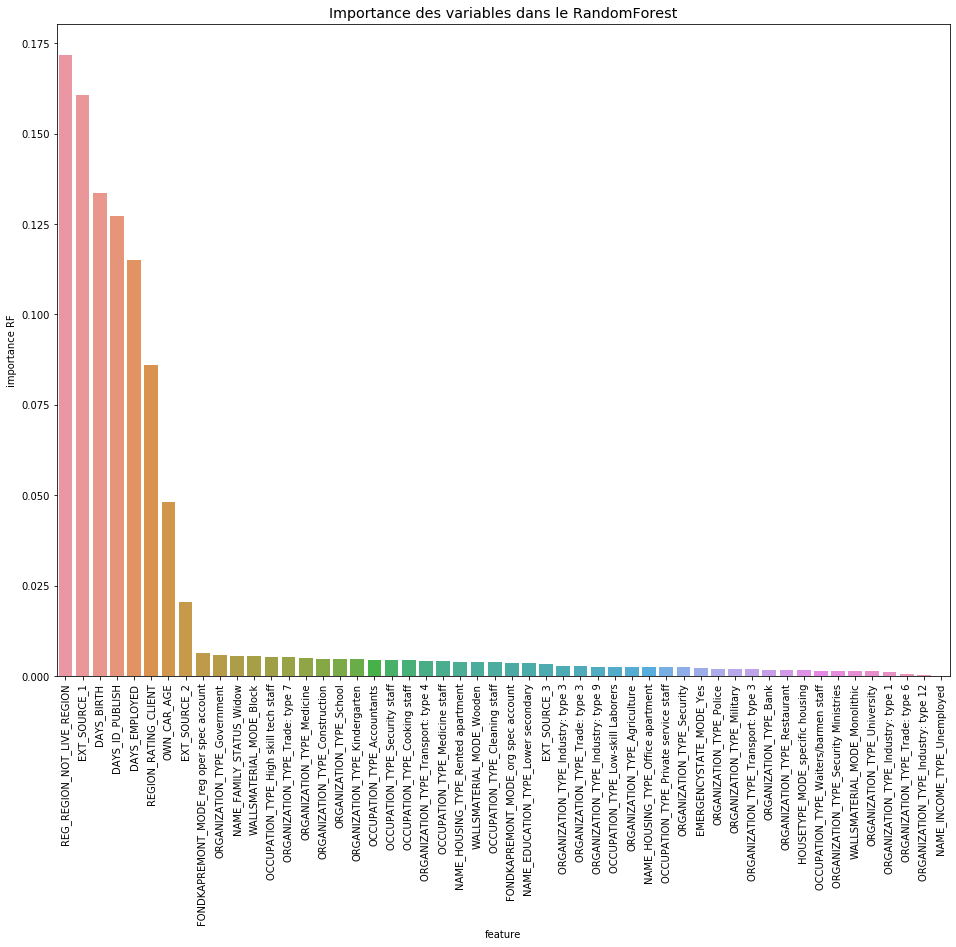

In [41]:
# Importance des variables Random Forest (RF)
feature_importance_values_RF = random_forest_clf[1].feature_importances_
feature_importance_RF_df = pd.DataFrame({'feature': X_train.columns, 'importance RF': feature_importance_values_RF})

feature_importance_RF_df.sort_values(by=["importance RF"], ascending=False, inplace=True)

plt.figure(figsize=(16,12))
sns.barplot(x="feature",y="importance RF", data=feature_importance_RF_df)
#plt.axhline(y=0.005,linewidth=1, color='r')
plt.title("Importance des variables dans le RandomForest", fontsize='x-large')
plt.xticks(rotation=90)



### Aire sous la ROC curve : 0.72 ###




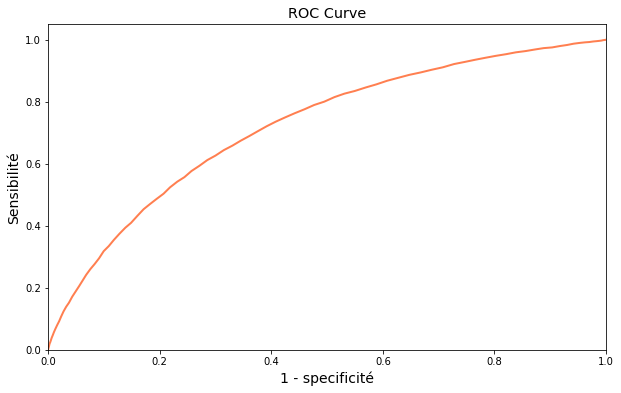

In [42]:
from sklearn.metrics import roc_curve

# Affichage de la ROC curve
random_forest_pred = random_forest_clf.predict_proba(X_test)[:,1]
# False Positive rates, True Positive rates & Threshold
[fpr, tpr, thr] = roc_curve(y_test, random_forest_pred)
# Affichage
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve", fontsize="x-large")
plt.xlabel('1 - specificité', fontsize=14)
plt.ylabel('Sensibilité', fontsize=14)

# Area Under The roc curve
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, random_forest_pred)
print("\n\n### Aire sous la ROC curve : {} ###\n\n".format(np.around(score,2)))

**Analyse des résultats:**
- GradientBoosting et RandomForest donnent les mêmes résultats.
- On obtient un score F1 de 24% ce qui est mieux que la baseline (et mieux que le modèle précédent).
- On obtient une aire sous la courbe ROC de 0.72 ce qui est bien mieux que la baseline.
- On constate qu'une grande partie des variables n'ont aucune importance dans le modèle, on aimerait voir si en réduisant le nombre de variables utilisées on ne pourrait pas obtenir le mêmes résultats ou même mieux.

### Sélection de variables

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle  


# Récupération de df
with open('df', 'rb') as fichier:
    df_depickler = pickle.Unpickler(fichier)
    df = df_depickler.load()

# Récupération de df_pp
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

In [44]:
# Split
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler

# Modèles
from sklearn.ensemble import RandomForestClassifier

# Evaluation des modèles
from sklearn.metrics import roc_curve, confusion_matrix, classification_report

# Colonnes utile pour aller chercher de nouvelles variables dans les autres dataset
ID_feature = df_pp["SK_ID_CURR"].copy()
            
# Split Train / Test
train, test = train_test_split(df_pp, test_size=0.2, random_state=0)

In [45]:
variables_retenues = ["SK_ID_CURR",
                      "TARGET",
                      "OCCUPATION_TYPE_Low-skill Laborers",
                      "OCCUPATION_TYPE_Accountants",
                      "ORGANIZATION_TYPE_Transport: type 3",
                      "NAME_HOUSING_TYPE_Rented apartment",
                      "NAME_FAMILY_STATUS_Widow",
                      "ORGANIZATION_TYPE_Construction",
                      "EXT_SOURCE_1",
                      "EXT_SOURCE_2",
                      "EXT_SOURCE_3",
                      "DAYS_EMPLOYED",
                      "DAYS_BIRTH",
                      "OWN_CAR_AGE",
                      "DAYS_ID_PUBLISH"]

In [46]:
# On ne garde que les variabes retenues lors des tests statistiques
train = train[variables_retenues].copy()
test = test[variables_retenues].copy()

# On prend toutes les valeurs positives de target qu'on met dans individus_positifs_df
individus_positifs_df = train.loc[train["TARGET"]==1,:].copy()
n_positifs = individus_positifs_df.shape[0]

# On prend (de manière aléatoire dans le trainset) autant de négatifs que de positifs 
individus_negatifs_df = train.loc[train["TARGET"]==0,:].sample(n_positifs, random_state=0)

# On regroupe les deux sous-echantillons pour former le subtrain 50/50
subtrain = pd.concat([individus_positifs_df,individus_negatifs_df])

# On "mélange" les positis et les négatifs dans le dataset
subtrain.sort_values(by=["SK_ID_CURR"], ascending=True, inplace=True)

# On supprime la colonne SK_ID_CURR
subtrain = subtrain.drop(["SK_ID_CURR"], axis=1)
test = test.drop(["SK_ID_CURR"], axis=1)

# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []
for col in subtrain.columns:
    if subtrain[col].dtypes=='float64':
        numerical_features.append(col)
    else:
        if col!="TARGET":
            categorical_features.append(col)
            
# Séparation de la target pour le trainset
y_train = subtrain["TARGET"]
X_train = subtrain.drop(["TARGET"], axis=1).copy()

# Séparation de la target pour le trainset
y_test = test["TARGET"]
X_test = test.drop(["TARGET"], axis=1).copy()

# Affichage des dimensions
print("Dimensions de X_train : {} .".format(X_train.shape))
print("Dimensions de X_test : {} .".format(X_test.shape))

Dimensions de X_train : (39940, 13) .
Dimensions de X_test : (61503, 13) .


In [47]:
# Pipeline pour RandomForest (RF)

categorical_pipeline_RF = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline_RF = make_pipeline(SimpleImputer(strategy='median'))

preprocessor_RF = make_column_transformer((numerical_pipeline_RF, numerical_features),
                                                                    (categorical_pipeline_RF, categorical_features))

random_forest_clf = make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 10))

In [48]:
random_forest_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('pipeline-1',
                                                  Pipeline(memory=None,
                                                           steps=[('simpleimputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                           

In [49]:
print("\n\n\n\n### RANDOM FOREST CLASSIFIER ###\n")

# Matrice de confusion et rapport
clf_prediction = random_forest_clf.predict(X_test)

print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, clf_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, clf_prediction, zero_division=0))





### RANDOM FOREST CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[38110 18538]
 [ 1711  3144]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56648
           1       0.15      0.65      0.24      4855

    accuracy                           0.67     61503
   macro avg       0.55      0.66      0.51     61503
weighted avg       0.89      0.67      0.75     61503



**Analyse:**
- Avec seulement 13 variables sélectionnées, on obtient le même résultat qu'avec les 55 variables, on obtient un recall inférieur de 1%. Si ajouter des variables à notre modèle n'améliore pas la performance, on preferera travailler avec moins de variables.
- On a un bon recall mais une précision très mauvaise, on aimerait améliorer cette précision en gardant un recall au moins aussi bon.
- Avant de travailler sur nos 13 variables, nous allons voir si les variables que nous avons créées à lors de l'eda, celles qui sont en accord avec le domain étudié, permettent d'améliorer le modèle.

In [58]:
# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# Récupération de df_pp
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

In [59]:
for var in variables_pertinentes_eda.columns[2:]:

    # Jointure des variables pertinentes de l'eda et de df_pp PUIS suppression de SK_ID_CURR
    df_domain_features = df_pp.merge(variables_pertinentes_eda[["SK_ID_CURR",var]], on = 'SK_ID_CURR', how = 'left')
    #df_domain_features = df_domain_features.drop(["SK_ID_CURR"],axis=1)

    # Split Train / Test
    train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)

    # On prend toutes les valeurs positives de target qu'on met dans individus_positifs_df
    individus_positifs_df = train.loc[train["TARGET"]==1,:].copy()
    n_positifs = individus_positifs_df.shape[0]

    # On prend (de manière aléatoire dans le trainset) autant de négatifs que de positifs 
    individus_negatifs_df = train.loc[train["TARGET"]==0,:].sample(n_positifs, random_state=0)

    # On regroupe les deux sous-echantillons pour former le subtrain 50/50
    subtrain = pd.concat([individus_positifs_df,individus_negatifs_df])

    # On "mélange" les positis et les négatifs dans le dataset
    subtrain.sort_values(by=["SK_ID_CURR"], ascending=True, inplace=True)

    # On supprime la colonne SK_ID_CURR
    subtrain = subtrain.drop(["SK_ID_CURR"], axis=1)
    test = test.drop(["SK_ID_CURR"], axis=1)

    # Séparation des variables qualitatives continues et des variables qualitatives discrètes
    numerical_features = []
    categorical_features = []
    for col in subtrain.columns:
        if subtrain[col].dtypes=='float64':
            numerical_features.append(col)
        else:
            if col!="TARGET":
                categorical_features.append(col)

    # Séparation de la target pour le trainset
    y_train = subtrain["TARGET"]
    X_train = subtrain.drop(["TARGET"], axis=1).copy()

    # Séparation de la target pour le trainset
    y_test = test["TARGET"]
    X_test = test.drop(["TARGET"], axis=1).copy()

    # Pipeline pour RandomForest (RF)
    categorical_pipeline_RF = make_pipeline(SimpleImputer(strategy='most_frequent'))
    numerical_pipeline_RF = make_pipeline(SimpleImputer(strategy='median'))
    preprocessor_RF = make_column_transformer((numerical_pipeline_RF, numerical_features),
                                                                        (categorical_pipeline_RF, categorical_features))
    random_forest_clf = make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 10))
    
    # Entrainement du modèle
    random_forest_clf.fit(X_train,y_train)
    
    # Rapport de classification
    print("\n\n\n# {} #\n".format(var))
    clf_prediction = random_forest_clf.predict(X_test)
    print("### RAPPORT DE CLASSIFICATION ###","\n")
    print(classification_report(y_test, clf_prediction, zero_division=0))




# nombre_doc_fournis #

### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56648
           1       0.15      0.66      0.24      4855

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503




# demandeur_recurrent #

### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56648
           1       0.15      0.66      0.24      4855

    accuracy                           0.67     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.89      0.67      0.75     61503




# high_incomes #

### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.67      0.79     56648
           1       0.15      0.65      0.24      4855

**Analyse:**
- Sur 4 variables, 3 améliorent le recall de 1% sans diminuer la précision.
- On entrainer un modèle avec, cette fois-ci, les 3 variables: "pourcentage_salaire", "demandeur_recurrent", "nombre_doc_fournis"

In [50]:
# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# Récupération de df_pp
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

In [51]:
# On ne garde que les variables qui ont augmenté le recall
variables_pertinentes_eda = variables_pertinentes_eda.drop(["TARGET","high_incomes"], axis=1)

# Jointure des variables pertinentes de l'eda et de df_pp PUIS suppression de SK_ID_CURR
df_domain_features = df_pp.merge(variables_pertinentes_eda, on = 'SK_ID_CURR', how = 'left')

 # Split Train / Test
train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)


variables_retenues = ["SK_ID_CURR",
                      "TARGET",
                      "OCCUPATION_TYPE_Low-skill Laborers",
                      "OCCUPATION_TYPE_Accountants",
                      "ORGANIZATION_TYPE_Transport: type 3",
                      "NAME_HOUSING_TYPE_Rented apartment",
                      "NAME_FAMILY_STATUS_Widow",
                      "ORGANIZATION_TYPE_Construction",
                      "EXT_SOURCE_1",
                      "EXT_SOURCE_2",
                      "EXT_SOURCE_3",
                      "DAYS_EMPLOYED",
                      "DAYS_BIRTH",
                      "OWN_CAR_AGE",
                      "DAYS_ID_PUBLISH",
                      "pourcentage_salaire",
                      "nombre_doc_fournis"]

# On ne garde que les variabes retenues lors des tests statistiques
train = train[variables_retenues].copy()
test = test[variables_retenues].copy()

# On prend toutes les valeurs positives de target qu'on met dans individus_positifs_df
individus_positifs_df = train.loc[train["TARGET"]==1,:].copy()
n_positifs = individus_positifs_df.shape[0]

# On prend (de manière aléatoire dans le trainset) autant de négatifs que de positifs 
individus_negatifs_df = train.loc[train["TARGET"]==0,:].sample(n_positifs, random_state=0)

# On regroupe les deux sous-echantillons pour former le subtrain 50/50
subtrain = pd.concat([individus_positifs_df,individus_negatifs_df])

# On "mélange" les positis et les négatifs dans le dataset
subtrain.sort_values(by=["SK_ID_CURR"], ascending=True, inplace=True)

# On supprime la colonne SK_ID_CURR
subtrain = subtrain.drop(["SK_ID_CURR"], axis=1)
test = test.drop(["SK_ID_CURR"], axis=1)

# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []
for col in subtrain.columns:
    if subtrain[col].dtypes=='float64':
        numerical_features.append(col)
    else:
        if col!="TARGET":
            categorical_features.append(col)

# Séparation de la target pour le trainset
y_train = subtrain["TARGET"]
X_train = subtrain.drop(["TARGET"], axis=1).copy()

# Séparation de la target pour le trainset
y_test = test["TARGET"]
X_test = test.drop(["TARGET"], axis=1).copy()

# Pipeline pour RandomForest (RF)
categorical_pipeline_RF = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline_RF = make_pipeline(SimpleImputer(strategy='median'))
preprocessor_RF = make_column_transformer((numerical_pipeline_RF, numerical_features),
                                                                    (categorical_pipeline_RF, categorical_features))
random_forest_clf = make_pipeline(preprocessor_RF, RandomForestClassifier(n_estimators = 100, random_state = 10))

# Entrainement du modèle
random_forest_clf.fit(X_train,y_train)

# Rapport de classification
print("\n\n\n\n### RANDOM FOREST CLASSIFIER ###\n")
clf_prediction = random_forest_clf.predict(X_test)
print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, clf_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, clf_prediction, zero_division=0))





### RANDOM FOREST CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[38406 18242]
 [ 1632  3223]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56648
           1       0.15      0.66      0.24      4855

    accuracy                           0.68     61503
   macro avg       0.55      0.67      0.52     61503
weighted avg       0.90      0.68      0.75     61503



**Analyse:**
- 2 variables relatives au domaine étudié (nombre_doc_fournis et pourcentage_salaire) améliorent légèrement le modèle car on a désormais 3223 *true-positives* contre 3144 sans ces dernières et un recall, cette fois-ci, égal au modèle avec les 55 variables.
- Pour la suite de notre travail, **nous allons garder ces 15 variables.**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle 

# Counter
from collections import Counter

# Split & Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold

# Features selection
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Modèles
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Evaluation des modèles
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, f1_score

# Imbalanced learn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# Récupération de variables_sans_interet
with open('variables_sans_interet','rb') as fichier:
    variables_sans_interet_depickler = pickle.Unpickler(fichier)
    variables_sans_interet = variables_sans_interet_depickler.load()
    
# Récupération de df_pp et suppression des variables sans interet
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

# On ne garde que les variables qui ont augmenté le recall
variables_pertinentes_eda = variables_pertinentes_eda.drop(["TARGET","high_incomes"], axis=1)

# Jointure des variables pertinentes de l'eda et de df_pp PUIS suppression de SK_ID_CURR
df_domain_features = df_pp.merge(variables_pertinentes_eda, on = 'SK_ID_CURR', how = 'left')

 # Split Train / Test
train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)


variables_retenues = ["TARGET",
                      "OCCUPATION_TYPE_Low-skill Laborers",
                     "OCCUPATION_TYPE_Accountants",
                     "ORGANIZATION_TYPE_Transport: type 3",
                    "NAME_HOUSING_TYPE_Rented apartment",
                     "NAME_FAMILY_STATUS_Widow",
                     "ORGANIZATION_TYPE_Construction",
                    "EXT_SOURCE_1",
                    "EXT_SOURCE_2",
                     "EXT_SOURCE_3",
                     "DAYS_EMPLOYED",
                    "DAYS_BIRTH",
                    "OWN_CAR_AGE",
                    "DAYS_ID_PUBLISH",
                    "pourcentage_salaire",
                    "nombre_doc_fournis"]

# On ne garde que les variabes retenues lors des tests statistiques
train = train[variables_retenues].copy()
test = test[variables_retenues].copy()


# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []
for col in train.columns:
    if (train[col].dtypes=='float64'):
        numerical_features.append(col)
    else:
        if (col!="TARGET"):
            categorical_features.append(col)

# Séparation de la target pour le trainset
y_train = np.array(train["TARGET"])
X_train = train.drop(["TARGET"], axis=1).copy()
y_train = y_train.reshape(len(y_train),1)
print("Dimensions de X_train : {} ".format(X_train.shape))
print("Dimensions de y_train : {} ".format(np.shape(y_train)))

# Séparation de la target pour le trainset
y_test = np.array(test["TARGET"])
X_test = test.drop(["TARGET"], axis=1).copy()
y_test = y_test.reshape(len(y_test),1)
print("\n\nDimensions de X_test : {} ".format(X_test.shape))
print("Dimensions de y_test : {} ".format(np.shape(y_test)))

Dimensions de X_train : (246008, 15) 
Dimensions de y_train : (246008, 1) 


Dimensions de X_test : (61503, 15) 
Dimensions de y_test : (61503, 1) 


In [2]:
# Simple Imputer transformer
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'))
imputer = make_column_transformer((numerical_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))

# Echantillonnage = SMOTE + RandomUnderSampler
over = SMOTE(sampling_strategy=0.09, k_neighbors=8, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)

# Modèle
model = RandomForestClassifier(random_state=0)

# Pipeline finale
steps = [('imputer', imputer),('over', over),('under', under),('model', model)]
RF_clf = Pipeline(steps=steps)

# Entrainement du modèle
RF_clf.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_BIRTH', 'OWN_CAR_AGE',
                                                   'DAYS_ID_PUBLISH',
                                                   'pourcentage_salaire']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImpu

In [3]:
# Rapport de classification
print("\n\n\n\n### Random Forest CLASSIFIER ###\n")
clf_prediction = RF_clf.predict(X_test)
print("### MATRICE DE CONFUSION ###","\n")
print(confusion_matrix(y_test, clf_prediction))
print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
print(classification_report(y_test, clf_prediction, zero_division=0))





### Random Forest CLASSIFIER ###

### MATRICE DE CONFUSION ### 

[[49670  6978]
 [ 3030  1825]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.94      0.88      0.91     56648
           1       0.21      0.38      0.27      4855

    accuracy                           0.84     61503
   macro avg       0.57      0.63      0.59     61503
weighted avg       0.88      0.84      0.86     61503



In [4]:
# Evaluation
cv = StratifiedKFold(n_splits=10)
scores_roc_auc = cross_val_score(RF_clf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('> SMOTE ratio = 0.09, n_neighbors = 8, under sampling ratio = 0.5, Mean ROC AUC: {}'.format(np.around(np.mean(scores_roc_auc),3)))

> SMOTE ratio = 0.09, n_neighbors = 8, under sampling ratio = 0.5, Mean ROC AUC: 0.721


**Conclusion du pré-traitement des données:**

- **Démarche:**
    - On avait une baseline avec un score **F1 de 15%** et une **AUC ROC** égale à **0.5** qu'on cherchait à améliorer.
    - Notre objectif était de trouver la meilleure configuration de notre dataset qui permette d'obtenir les meilleures résultats.
    - Pour cela, on a testé différentes chaines de pré-traitement, de la plus simple à la plus complexe, sans toucher aux hyperparamètres de nos modèles.
    - Pour chaque chaine de pré-traitement, nous avons jugé son efficacité par rapport au score F1 obtenu à l'issue de l'entrainement.

- **Remarque:**
    - Aucune classe d'encodage n'est présente dans mes *pipeline* car les variables qualitatives ont été encodées en OneHot dans la partie II.A.

- **Résumé des actions effectuées:** 
    - 1ère chaine: sans échantillonnage particulier, avec une imputation simple et sans sélection de variables.<br/>
    Score **F1=2%**.   
    - 2éme chaine: sans échantillonnage particulier, avec une imputation simple mais avec une sélection de variables fondée sur un test de chi2 pour les variables catégorielles et sur un test de ANOVA pour les variables quantitatives continues (rappel: la target est quantitative discrète): 4 variables sélectionnées en tout.<br/>
    Score **F1=10%**.
    - 3ème chaine: avec un RandomUnderSampling (permis grâce aux grands nombre d'individus de notre dataset) avec un ratio des classes de la target de 1:1, avec une imputation simple et sans sélection de variables.<br/>
    Score **F1=24%** (surement un peu optimiste dû à l'échantillonnage non représentatif de la réalité).
    - 4ème chaine: identique à la 3ème mais avec une sélection de variables: on a sélectionné les 7 variables qui ont obtenu les statistiques normalisées les plus élevées sur le test de chi2 (tests TARGET & Variables qualitatives) et les 6 variables dont on a rejeté l'hypothèse $H_0$ le plus de fois sur un grand nombre de tests de Student successifs (tests TARGET & Variables quantitatives continues). 13 variables sélectionnées en tout.<br/>
    Score **F1=24%**
    - 5ème chaine: identique à la 4ème mais avec 2 variables relatives au domaine étudié (variables créées lors de l'EDA) donc au total 15 variables sélectionnées.<br/>
    Score **F1=24%** mais avec une augmentation de 80 *True-positives*.
    - 6ème et dernière chaine:<br/>
     Un échantillonnage SMOTE de ratio {"1"=9 **:** "0"=100} suivi d'un RandomUnderSampling de ratio {"1"=1 **:** "0"=2}.<br/>
     Un SimpleImputer de *strategy most frequent* pour les variables catégorielles et *strategy median* pour les quantitatives continues.<br/>
     Le modèle de RandomForestClassifier avec les hyperparamètres de base.<br/>
     Score **F1=27%** / **AUC ROC=0.721** (résultats plus proches des performances réelles du modèle grâce à l'échantillonnage)

# III. Modèle final

Dans cette partie, nous allons travailler avec deux modèles: un linéaire, une Cost-Sensitive Logistic Regression (CSLR) et un non linéaire, un GradientBoosting (GB). À l'issue de la partie consacrée à l'optimisation, nous choisirons le modèle le plus performant afin d'en proposer une interprétation. Notre objectif est d'améliorer notre score **AUC ROC** donc de faire mieux que **0.721**, résultat que nous avons obtenu lors du pré-traitement des données, à partir des hyper-paramètres de base du RandomForestClassifier. Pour l'interprétation, nous utiliserons la méthode *Shapley Additive Explanations values* ou ***SHAP values***.

**Remarque 1:** La manière dont ont été sélectionnées les variables est détaillée plus tôt dans le notebook (partie II.A). Cette sélection et sa justification fournissent déjà un premier outil de compréhension du modèle. Ce que nous allons faire dans cette partie concerne la compréhension des algorithmes que nous utilisons (GB et CSLR).

**Remarque 2:** Remarque d'ordre technique. Pour évaluer nos modèles, nous utilisons une validation croisée stratifée (*Stratified cross validation*). La stratification garantit une proportion des modalités de la cible ("0" ou "1") **égales dans chaque *split*, à la proportion des modalités de la cible dans le *trainset***. Ainsi, chaque résultat (obtenu sur chaque *split*) s'approche du résultat que l'on obtiendrait si on évaluait le modèle sur l'ensemble du *trainset*. Le nombre de *splits* choisi est 10 car la taille de notre jeu de données nous permet de choisir un nombre de *splits* assez grand.

## III. A. Optimisation du modèle

In [1]:
# Bibliothèques de base
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle 

# Modèles
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Split & Model selection
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler

# Imbalanced learn / Sampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Evaluation des modèles
from sklearn.metrics import roc_curve, confusion_matrix, classification_report,  roc_auc_score

In [2]:
# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# Récupération de variables_sans_interet
with open('variables_sans_interet','rb') as fichier:
    variables_sans_interet_depickler = pickle.Unpickler(fichier)
    variables_sans_interet = variables_sans_interet_depickler.load()
    
# Récupération de df_pp et suppression des variables sans interet
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

# On ne garde que les variables qui ont augmenté le recall
variables_pertinentes_eda = variables_pertinentes_eda.drop(["TARGET","high_incomes"], axis=1)

# Jointure des variables pertinentes de l'eda et de df_pp PUIS suppression de SK_ID_CURR
df_domain_features = df_pp.merge(variables_pertinentes_eda, on = 'SK_ID_CURR', how = 'left')

 # Split Train / Test
train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)

variables_retenues = ["TARGET",
                      "OCCUPATION_TYPE_Low-skill Laborers",
                     "OCCUPATION_TYPE_Accountants",
                     "ORGANIZATION_TYPE_Transport: type 3",
                    "NAME_HOUSING_TYPE_Rented apartment",
                     "NAME_FAMILY_STATUS_Widow",
                     "ORGANIZATION_TYPE_Construction",
                    "EXT_SOURCE_1",
                    "EXT_SOURCE_2",
                     "EXT_SOURCE_3",
                     "DAYS_EMPLOYED",
                    "DAYS_BIRTH",
                    "OWN_CAR_AGE",
                    "DAYS_ID_PUBLISH",
                    "pourcentage_salaire",
                    "nombre_doc_fournis"]

# On ne garde que les variabes retenues lors des tests statistiques
train = train[variables_retenues].copy()
test = test[variables_retenues].copy()

# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []
for col in train.columns:
    if (train[col].dtypes=='float64'):
        numerical_features.append(col)
    else:
        if (col!="TARGET"):
            categorical_features.append(col)

# Séparation de la target pour le trainset
y_train = np.array(train["TARGET"])
X_train = train.drop(["TARGET"], axis=1).copy()
y_train = y_train.reshape(len(y_train),1)
print("Dimensions de X_train : {} ".format(X_train.shape))
print("Dimensions de y_train : {} ".format(np.shape(y_train)))

# Séparation de la target pour le trainset
y_test = np.array(test["TARGET"])
X_test = test.drop(["TARGET"], axis=1).copy()
y_test = y_test.reshape(len(y_test),1)
print("\n\nDimensions de X_test : {} ".format(X_test.shape))
print("Dimensions de y_test : {} ".format(np.shape(y_test)))

Dimensions de X_train : (246008, 15) 
Dimensions de y_train : (246008, 1) 


Dimensions de X_test : (61503, 15) 
Dimensions de y_test : (61503, 1) 


In [19]:
def rapport(model, name="model", X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """Rapport de classification"""
    model.fit(X_train,y_train)
    print("\n\n\n\n### {} ###\n".format(name))
    model_prediction = model.predict(X_test)
    print("### MATRICE DE CONFUSION ###","\n")
    print(confusion_matrix(y_test, model_prediction))
    print("\n", "### RAPPORT DE CLASSIFICATION ###","\n")
    print(classification_report(y_test, model_prediction, zero_division=0))
    
def evaluation(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    """Evaluation"""
    cv = StratifiedKFold(n_splits=10)
    scores_roc_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
    print("\n### CROSS VALIDATION ###\n")
    print('> SMOTE ratio = 0.09, n_neighbors = 8, under sampling ratio = 0.5, Mean ROC AUC: {}'.format(np.around(np.mean(scores_roc_auc),4)))

### Point de départ

In [4]:
# Imputer transformer
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'))
imputer = make_column_transformer((numerical_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))

# Scaler transformer
scaler_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
scaler = make_column_transformer((scaler_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))


# Echantillonnage = SMOTE + RandomUnderSampler
over = SMOTE(sampling_strategy=0.09, k_neighbors=8, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)

Nous allons dans un premier temps entrainer les deux modèles que nous voulons optimiser sur leurs **hyper-paramètres de base.**

In [5]:
# GradientBoosting
GB_model = GradientBoostingClassifier(random_state=0)
GB_steps = [('imputer', imputer),('over', over),('under', under),('model', GB_model)]
GB_clf = Pipeline(steps=GB_steps)

# Cost-sensitive Logistic Regression
CSLR_model = LogisticRegression(class_weight='balanced')
CSLR_steps = [('scaler', scaler),('over', over),('under', under),('model', CSLR_model)]
CSLR = Pipeline(steps=CSLR_steps)

In [6]:
# Dictionnaire des modèles
models = {'GB':GB_clf, 'CSLR':CSLR}

In [7]:
for name, model in models.items():
    rapport(model, name=name)
    evaluation(model)





### GB ###

### MATRICE DE CONFUSION ### 

[[50378  6270]
 [ 3072  1783]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.94      0.89      0.92     56648
           1       0.22      0.37      0.28      4855

    accuracy                           0.85     61503
   macro avg       0.58      0.63      0.60     61503
weighted avg       0.89      0.85      0.86     61503


### CROSS VALIDATION ###

> SMOTE ratio = 0.09, n_neighbors = 8, under sampling ratio = 0.5, Mean ROC AUC: 0.738




### CSLR ###

### MATRICE DE CONFUSION ### 

[[38427 18221]
 [ 1707  3148]]

 ### RAPPORT DE CLASSIFICATION ### 

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     56648
           1       0.15      0.65      0.24      4855

    accuracy                           0.68     61503
   macro avg       0.55      0.66      0.52     61503
weighted avg       0.89      0.68      0.75     61503

**Analyse des résultats:**
- On constate que les deux résultats obtenus sont meilleurs que celui du modèle simple utilisé lors du pré-processing: $$\text{0.738 > 0.727 > 0.721.}$$.
- Nous allons d'abord optimiser le modèle linéaire, la *Cost-Sensitive-Logistic-Regression* (CSLR), puis le modèle non linéaire, le *GradientBoosting* (GB).

### Optimisation du modèle linéaire

Nous allons ici optimiser le modèle CSLR.  Pour cela nous allons utliser un *grid-search-cv*. Nous allons optimiser les hyper-paramètres suivants.
- La valeur **C** qui est la constante de régularisation. Cette constante contrôle à la fois la complexité du modèle et l'erreur que le modèle fait sur le jeu d'entrainement. Nous allons entrainer le modèle avec plusieurs valeurs afin de trouver le meilleur compromis. Valeurs testées: $$\text{1, 10 & 100.}$$


- Le type de régularisation (l1, l2 ou un mélange des deux:*elasticnet*) grâce à l'hyper-paramètre **penalty**. La norme l1 permet de réduire l'amplitude des poids affectés aux variables dans l'apprentissage du modèle et la norme l2 permet de réduire le nombre de variables utilisées par notre modèle. Pour étudier cet aspect, nous allons utliser la pénalité *elasticnet* qui nous permet de faire varier le ratio de norme l1 utlisée (ratio égal à 0 correspond à la norme l2, ratio égal à 1 correspond à la norme l1 et une valeur comprise entre 0 et 1 correspond à un mélange des deux normes). Valeurs de **ratio_l1** testées: $$\text{0, 0.5 & 1.}$$


- L'importance des modalités de la cible grâce à l'hyper-paramètre **class_weight**. Ce terme est celui qui permet de différencier une régression logistique classique d'une régression logistique sensible aux problèmes de déséquilibre dans les modalités de la cible. Pour résumer, il impose un poids aux modalités et ce poids permet de contrôler leur importance dans l'apprentissage. Dans le cas d'une régression logistique classique chaque modalité à un poids identique: 1. Pour éviter au modèle le sur-apprentissage ou le sous-apprentissage nous allons attribuer la valeur "balanced" à cet hyper-paramètre i.e. la distribution de poids suivante: 0=1 & 1=11 qui correspond à l'opposé de la distribution réelle de notre dataset qui est de 11 négatifs pour 1 positif. Valeurs testées: $$\text{(0:1,1:1) & (0:1,1:11).}$$

In [8]:
# Imputer + Scaler  transformer
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
scaler_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
scaler = make_column_transformer((scaler_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))


# Echantillonnage = SMOTE + RandomUnderSampler
over = SMOTE(sampling_strategy=0.09, k_neighbors=8, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [9]:
# Cost-sensitive Logistic Regression
CSLR_model = LogisticRegression(class_weight='balanced')
CSLR_steps = [('scaler', scaler),('over', over),('under', under),('model', CSLR_model)]
CSLR = Pipeline(steps=CSLR_steps)

In [11]:
# Optimisation de CSLR
hyper_parametres = {"model__C":[1,10,100],
                    "model__class_weight":[{0:1, 1:1},"balanced"],
                    "model__penalty":["elasticnet"],
                    "model__l1_ratio":[0,0.5,1],
                    "model__n_jobs":[-1],
                    "model__solver":["saga"]}
grid = GridSearchCV(CSLR, hyper_parametres, scoring='roc_auc',cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'model__C': 10, 'model__class_weight': {0: 1, 1: 1}, 'model__l1_ratio': 1, 'model__n_jobs': -1, 'model__penalty': 'elasticnet', 'model__solver': 'saga'}


In [12]:
evaluation(grid.best_estimator_)


### CROSS VALIDATION ###

> SMOTE ratio = 0.09, n_neighbors = 8, under sampling ratio = 0.5, Mean ROC AUC: 0.727


**Analyse des résultats:**
- On obtient le même résultat qu'avec les hyper-paramètres de base.
- D'ailleurs, le meilleur score AUC ROC obtenu est identique avec ou sans le terme de sensibilité de la régression logistique.

### Optimisation du modèle non linéaire

Nous n'allons pas utiliser un modèle de *GradientBoosting* tel quel pour l'optimisation, nous allons utiliser un modèle de *LightGradientBoostingMachine* qui a l'avantage d'être beaucoup plus rapide sans pour autant détériorer les résultats. Dans le *grid-search-cv*, nous allons optimiser les hyper-paramètres suivants:
- Le nombre d'**estimators** qui correspond au nombre d'arbres utilisés par le modèle lors de son apprentissage. Valeurs testées: 
$$\text{500 & 750.}$$


- Le **learning_rate** qui correspond au coefficient utilisé dans la minimisation de la fonction coût. Valeurs testées: $$\text{0.01, 0.05 & 0.1.}$$


- La profondeur maximale des arbres avec **max_depth**. Valeurs testées: $$\text{-1 (i.e. aucune limitation) & 3 (valeurs par défaut dans la classe RandomForestClassifier).}$$


- La régularisation (normes l1 et l2) grâce aux hyper-paramètres **reg_alpha** et **reg_lambda**. Valeurs testées pour les deux hyper-paramètres: $$\text{0, 0.25 & 0.5.}$$


- Cette fois-ci, nous allons fixer l'importance des modalités de la cible (grâce à l'hyper-paramètre **class_weight** comme pour la CSLR) sur **class_weight**.

In [13]:
# Imputer transformer
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'))
imputer = make_column_transformer((numerical_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))

# Echantillonnage = SMOTE + RandomUnderSampler
over = SMOTE(sampling_strategy=0.09, k_neighbors=8, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [14]:
# LGBM
LGBM_model = LGBMClassifier()
LGBM_steps = [('imputer', imputer),('over', over),('under', under),('model', LGBM_model)]
LGBM_clf = Pipeline(steps=LGBM_steps)

In [17]:
# Optimisation de LGBM
hyper_parametres = {"model__n_estimators":[500,750],
                    "model__learning_rate":[1e-2,5e-2,1e-1],
                    "model__max_depth":[-1,3],
                    "model__reg_alpha":[0,0.25,0.5],
                    "model__reg_lambda":[0,0.25,0.5],
                    "model__class_weight":["balanced"],
                    "model__objective":["binary"],
                    "model__random_state":[10]}

grid = GridSearchCV(LGBM_clf, hyper_parametres, scoring='roc_auc',cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

{'model__class_weight': 'balanced', 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 500, 'model__objective': 'binary', 'model__random_state': 10, 'model__reg_alpha': 0.5, 'model__reg_lambda': 0.5}


In [20]:
evaluation(grid.best_estimator_)


### CROSS VALIDATION ###

> SMOTE ratio = 0.09, n_neighbors = 8, under sampling ratio = 0.5, Mean ROC AUC: 0.7404


**Analyse des résultats:**
- Cette fois-ci, le score s'améliore: $$\text{0.740 > 0.738.}$$
- C'est le modèle qu'on gardera pour avoir un score maximal.

## III. B. Interprétation du modèle

Dans cette partie, nous allons nous intéresser à l'interprétation du modèle qui donne le meilleur score à savoir le modèle de *LightGradientBoostingMachine*. Pour l'interprétation, nous allons utiliser les *SHAP values*. Expliquons ce que sont les valeurs de Shapley grâce à un exemple. Nous prenons l'exemple de notre variable "Low-skill laborers". Le principe des valeurs Shapley est d'expliquer à quel point une prédiction a été influencée par le fait d'avoir un travailleur avec un travail peu qualifié au lieu d'avoir une autre valeur aléatoire de cette variable. Plus généralement, la valeur de Shapley est la contribution moyenne d'une modalité à la prédiction dans différentes configurations.  La valeur absolue des valeurs de Shapley permet de déterminer l'importance que la variable a dans les prédictions faites par le modèle. Un avantage des valeurs de Shapley est également de permettre une explication contrastée du modèle. En effet, il va être possible de comparer l'évolution des valeurs de Shapley en fonction de deux variables. 

**Remarque concernant notre dataset:** Certaines variables sélectionnées grâce au travail effectué lors de la partie <a href=selection_var_quantitatives>II.B.</a> n'ont pas de signification concrète. Il est question des variables EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. Ce sont les variables quantitatives dont les résultats des tests statistiques ont été les plus notables mais nous ne savons juste qu'elles correspondent à des scores extérieurs à la banque attribués aux clients.

In [1]:
# Bibliothèques de base
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle 

# Modèles
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Split & Model selection
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

# Imputer
from sklearn.impute import SimpleImputer

# Scaler
from sklearn.preprocessing import StandardScaler

# Imbalanced learn / Sampling
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Evaluation des modèles
from sklearn.metrics import roc_curve, confusion_matrix, classification_report,  roc_auc_score

In [2]:
# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# Récupération de variables_sans_interet
with open('variables_sans_interet','rb') as fichier:
    variables_sans_interet_depickler = pickle.Unpickler(fichier)
    variables_sans_interet = variables_sans_interet_depickler.load()
    
# Récupération de df_pp et suppression des variables sans interet
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

# On ne garde que les variables qui ont augmenté le recall
variables_pertinentes_eda = variables_pertinentes_eda.drop(["TARGET","high_incomes"], axis=1)

# Jointure des variables pertinentes de l'eda et de df_pp PUIS suppression de SK_ID_CURR
df_domain_features = df_pp.merge(variables_pertinentes_eda, on = 'SK_ID_CURR', how = 'left')

 # Split Train / Test
train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)

variables_retenues = ["TARGET",
                      "OCCUPATION_TYPE_Low-skill Laborers",
                     "OCCUPATION_TYPE_Accountants",
                     "ORGANIZATION_TYPE_Transport: type 3",
                    "NAME_HOUSING_TYPE_Rented apartment",
                     "NAME_FAMILY_STATUS_Widow",
                     "ORGANIZATION_TYPE_Construction",
                    "EXT_SOURCE_1",
                    "EXT_SOURCE_2",
                     "EXT_SOURCE_3",
                     "DAYS_EMPLOYED",
                    "DAYS_BIRTH",
                    "OWN_CAR_AGE",
                    "DAYS_ID_PUBLISH",
                    "pourcentage_salaire",
                    "nombre_doc_fournis"]

# On ne garde que les variabes retenues lors des tests statistiques
train = train[variables_retenues].copy()
test = test[variables_retenues].copy()

# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []
for col in train.columns:
    if (train[col].dtypes=='float64'):
        numerical_features.append(col)
    else:
        if (col!="TARGET"):
            categorical_features.append(col)

# Séparation de la target pour le trainset
y_train = np.array(train["TARGET"])
X_train = train.drop(["TARGET"], axis=1).copy()
y_train = y_train.reshape(len(y_train),1)
print("Dimensions de X_train : {} ".format(X_train.shape))
print("Dimensions de y_train : {} ".format(np.shape(y_train)))

# Séparation de la target pour le trainset
y_test = np.array(test["TARGET"])
X_test = test.drop(["TARGET"], axis=1).copy()
y_test = y_test.reshape(len(y_test),1)
print("\n\nDimensions de X_test : {} ".format(X_test.shape))
print("Dimensions de y_test : {} ".format(np.shape(y_test)))

Dimensions de X_train : (246008, 15) 
Dimensions de y_train : (246008, 1) 


Dimensions de X_test : (61503, 15) 
Dimensions de y_test : (61503, 1) 


In [3]:
# Imputer transformer
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'))
imputer = make_column_transformer((numerical_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))


# Echantillonnage = SMOTE + RandomUnderSampler
over = SMOTE(sampling_strategy=0.09, k_neighbors=8, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)

# LGBM
LGBM_model = LGBMClassifier(random_state=10)
LGBM_steps = [('imputer', imputer),('over', over),('under', under),('model', LGBM_model)]
LGBM_clf = Pipeline(steps=LGBM_steps)

In [ ]:
# Fit
LGBM_clf.fit(X_train, y_train)

In [5]:
n_ind = 1000
shap_sample = X_test.sample(n_ind)

In [6]:
import shap

# Explainer peut calculer les "SHAP values"
explainer = shap.TreeExplainer(LGBM_clf[3])

# Calcul des "SHAP values"
shap_values = explainer.shap_values(shap_sample)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


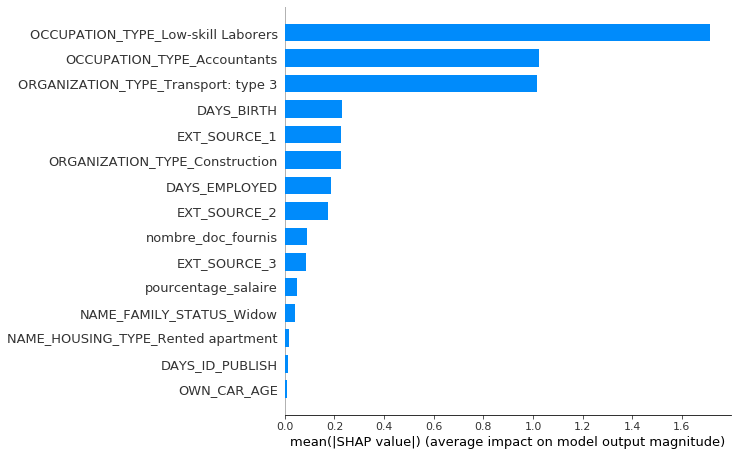

In [8]:
# Affichage de l'importance de Shapley des variables
shap.initjs()
shap.summary_plot(shap_values[1], shap_sample, plot_type="bar")

**Analyse des valeurs de Shapley absolues:**

Ce premier graphique nous donne une première idée sur la contribution des différentes variables aux prédictions du modèle. On constate déjà que 5 variables contribuent majoritairement aux prédictions, dont 3 variables  avec des valeurs absolues de Shapley très élevées.

**Expliquons ces résultats:**

Rappel: nous avons sélectionné les variables qualitatives à l'issue des résultats d'un test de chi2 normalisé (voir partie <a href=#selection_var_qualitatives>II.A.</a> pour avoir tous les détails). Pour chaque variable qualitative selectionnée, le rapport statistique que nous avons affiché indiquait si la variables présentait une relation de dépendance significative ou non avec la target et si oui, s'il s'agissait d'une répulsion ou d'une attraction. Nous avons sélectionné les variables qui présentaient les relations de dépendance les plus significatives. Il s'agit d'une selection simple mais qui nous a permis d'obtenir de bon résultats en limitant le nombre de variables utilisées par le modèle. Cependant, on constate ici que ces variables ont tendance à participer en très grande majorité aux prédictions. Par exemple, bien que nous n'ayons pas le signe des valeurs de Shapley sur le graphique, nous pouvons supputer que le modèle ait tendance à prédire une personne ayant un travail peu qualifié comme défaillant au remboursement de son prêt et ce, presque indépendamment des autres variables. 

**Quels sont les problèmes ?** 

Premièrement nous avons créé un modèle potentiellement peu éthique par sa fatalité dans la manière de faire ses prédictions. Les personnes ayant un travail peu qualifié ont une tendance significative à ne pas rembourser leur prêt (relation d'attraction entre TARGET=1 et Low-skill Laborers=1) mais il ne s'agit que d'une tendance. Cette tendance doit orienter le modèle et non participer entièrement à sa prédiction. Deuxièmement, la manière dont nous avons sélectionné les variables est certes efficace d'un point de vue performance mais empêche le modèle de bien généraliser (néanmoins mieux généraliser que sans la sélection de variables). En effet, les variables sélectionnées ne prennent pas en compte l'ensemble de la population de notre dataset. C'est-à-dire qu'il doit y avoir un bon nombre d'individus qui ne sont ni veuves ou veufs, ni *low-skill laborers*, ni travailleurs dans le domaine de la construction, ni travailleurs dans le domaine des transports de type 3, ni locataires de leur appartement et enfin, ni comptables.

**Comment résoudre ces problèmes ?**

Nous pouvons tenter de résoudre ces problèmes en faisant une sélection de variables un peu différente. Plutôt que de sélectionner un nombre fixe de variables à l'issue des tests de chi2, on pourrait créer deux nouvelles variables binaires, **attraction** et **répulsion**, qui prennent la valeur **1** ou **0** selon si l'individu présente ou non au moins une relation d'attraction ou de répulsion avec la TARGET. L'avantage est qu'on synthétisera tous les résultats, donc toutes les variables ayant une relation de dépendance significative avec la TARGET, dans seulement 2 variables. Le risque lié à cette méthode est que le modèle ne se fonde que sur ces deux variables pour établir ses prédictions, nous n'avons présenté ici qu'une potentielle solution.

**Allons jusqu'au bout de l'interprétation.**

Nous avons mis en lumière les différents problèmes liés à notre modèle. Cependant, il donne de bons résultats (résultats comparés aux *notebooks* Kaggle qui comme nous, n'utilisent qu'un dataset parmi les 7 fournis lors de la compétition). Nous pouvons donc poursuivre son interprétation, qui, à défaut de nous permettre de bien comprendre le modèle, nous permet de comprendre comment améliorer notre modèle.

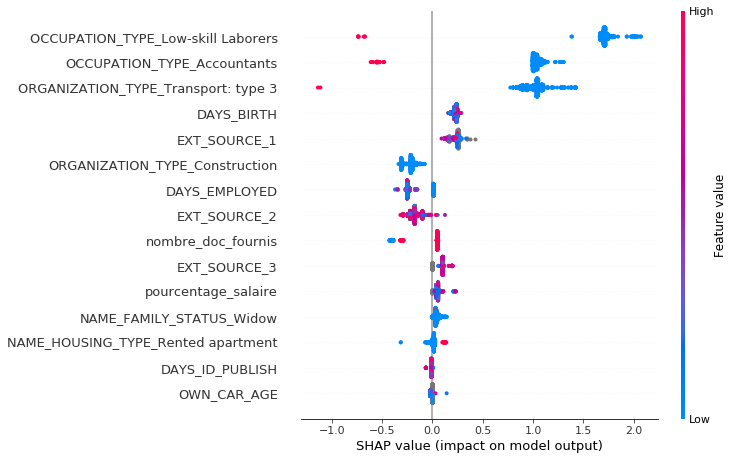

In [9]:
shap.summary_plot(shap_values[1], shap_sample)

**Analyse des conséquences des valeurs de Shapley sur les prédictions du modèle.**

Ce qui est le plus flagrant sur ce graphique correspond en fait à un problème que nous avons soulevé précédemment: les faibles effectifs "positifs" des variables qui contribuent le plus aux prédictions ! Ce problème est mis en avant par la grande proportion de points bleus sur le graphique et donc de la grande proportion de valeurs "0" pour ces variables. On constate également que les amas de points bleus sont très étendus **indiquant bel et bien qu'il y a des nuances plus ou moins marquées parmi les individus qui sont des "Low-skill Laborers", des "Accountants" ou des travailleurs dans le domaine des "transports de type 3"** mais que **ces nuances sont éclipsées par la valeur binaire de la variable**. L'idéal serait d'avoir des amas bleus plus centrés dans lesquels on distinguerait des points rouges à la frontière droite ou gauche des amas... 

## III.C. Limites du modèle.

### Données et équité.

Dans la partie précédente, nous avons mis en évidence plusieurs problèmes liés à l'interprétation de notre modèle. En effet, bien qu'ayant de bonnes performances, notre modèle est difficilement interprétable et surtout, **il semble ne pas être juste avec tous les demandeurs de prêts**. Nous avons tenté de fournir une solution au problème en évoquant une manière différente de sélectionner les variables. Cependant, le problème pourrait venir des variables en elles-mêmes. 

**Objectif de cette partie.**

Compte tenu des différents problèmes évoqués, nous allons dans cette partie nous interroger sur les limites de notre modèle et en particulier sur les limites inhérentes aux données elles-mêmes. Avant d'entrer plus en détail dans l'étude du biais de notre modèle, nous allons simplement observer comment celui-ci se comporte pour deux individus aux profils strictement identiques à l'exception d'une variable. Ne changer la valeur que d'une seule variable pourrait-il radicalement changer la prédiction de notre modèle ? Cette étude de cas introduira une étude plus approfondie du biais grâce à la bibliothèque Python *Aequitas*. Notons que, plus tôt dans ce notebook, lors de l'analyse exploratoire de données partie I, nous avions déjà constaté quelques points sensibles comme par exemple, le très faible effectif (4 clients) de personnes ne se considèrant ni homme ni femme. 

**Est-ce cohérent de s'interroger sur les limites éthiques de notre modèle ?**

En 2015, Amazon a créé un système d'intelligence artificielle capable d'analyser les cv des postulants à leurs offres d'emploi. L'entreprise s'est rendu compte que le logiciel écartait beaucoup plus les cv des femmes que ceux des hommes. La raison était que le modèle utilisé avait été entrainé sur un jeu de données contenant 85% d'hommes... Les données qui servent à entrainer un modèle ne sont qu'une représentation du monde et il se peut que cette représentation soit imparfaite. Juste en observant nos données et nos variables dans la partie I, nous pouvions déjà constater certains aspects potentiellement problématiques. Par exemple, la modalité **"OCCUPATION TYPE Low-skill laborers=1"** a une relation d'attraction significativement forte avec la modalité **"TARGET=1"** mais elle pourrait s'avérer injuste si l'objectif de la banque était de fournir des prêts à des personnes n'ayant pas ou peu d'historique de prêts. En effet, on pourrait refuser un prêt pour un étudiant qui travaille en parallèle de ses études en tant que livreur. D'autres variables peuvent poser des problèmes d'interprétation comme par exemple, la variable **"EXT SOURCE 1"**. Comment justifier le refus du crédit à un client lorsqu'on sait simplement qu'il a un score "EXT SOURCE 1" trop faible? Ces variables variables "extérieures" sont importantes dans la prédiction de notre modèle, pourtant, si on veut fournir un prêt à quelqu'un n'ayant pas d'historique, il est possible que cette personne n'est également pas de "score extérieur" à la banque. 

Tous ces constats faits lors de notre travail justifient que nous nous interressions de plus prêt au biais inhérent à nos données.

### Deux profils presque identiques.

**Première comparaison.**

Après avoir entrainé notre modèle, nous allons "piocher" au hasard un individu dans notre jeu de données test. Cet individu sera nommé **individu_A**. Nous allons fonder notre comparaison sur ce dernier. Qu'allons-nous comparer et comment ? D'abord, nous afficherons son profil *i.e.* les valeurs qui lui sont attribuées sur les différentes variables et nous afficherons la prédiction (valeur comprise entre 0 et 1) que le modèle fait pour cet individu. Puis nous changerons la valeur d'une seule variable, dont il résultera un nouvel individu noté **individu_B**, et nous étudierons la nouvelle prédiction faite par le modèle. La variable que nous allons modifier dans un premier temps est la variable **Low-skill Laborers**.

In [1]:
# Bibliothèques de base
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import exploration as ex
import seaborn as sns
import pickle 

# Modèles
from lightgbm import LGBMClassifier

# Split & Model selection
from sklearn.model_selection import train_test_split

# Imputer
from sklearn.impute import SimpleImputer

# Imbalanced learn / Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# Récupération de variables_pertinentes_eda
with open('variables_pertinentes_eda','rb') as fichier:
    variables_pertinentes_eda_depickler = pickle.Unpickler(fichier)
    variables_pertinentes_eda = variables_pertinentes_eda_depickler.load()
    
# Récupération de variables_sans_interet
with open('variables_sans_interet','rb') as fichier:
    variables_sans_interet_depickler = pickle.Unpickler(fichier)
    variables_sans_interet = variables_sans_interet_depickler.load()
    
# Récupération de df_pp et suppression des variables sans interet
with open('df_pp','rb') as fichier:
    df_pp_depickler = pickle.Unpickler(fichier)
    df_pp = df_pp_depickler.load()
df_pp = df_pp.drop(variables_sans_interet,axis=1)

# On ne garde que les variables qui ont augmenté le recall
variables_pertinentes_eda = variables_pertinentes_eda.drop(["TARGET","high_incomes"], axis=1)

# Jointure des variables pertinentes de l'eda et de df_pp PUIS suppression de SK_ID_CURR
df_domain_features = df_pp.merge(variables_pertinentes_eda, on = 'SK_ID_CURR', how = 'left')

 # Split Train / Test
train, test = train_test_split(df_domain_features, test_size=0.2, random_state=0)

variables_retenues = ["TARGET",
                      "OCCUPATION_TYPE_Low-skill Laborers",
                     "OCCUPATION_TYPE_Accountants",
                     "ORGANIZATION_TYPE_Transport: type 3",
                    "NAME_HOUSING_TYPE_Rented apartment",
                     "NAME_FAMILY_STATUS_Widow",
                     "ORGANIZATION_TYPE_Construction",
                    "EXT_SOURCE_1",
                    "EXT_SOURCE_2",
                     "EXT_SOURCE_3",
                     "DAYS_EMPLOYED",
                    "DAYS_BIRTH",
                    "OWN_CAR_AGE",
                    "DAYS_ID_PUBLISH",
                    "pourcentage_salaire",
                    "nombre_doc_fournis"]

# On ne garde que les variabes retenues lors des tests statistiques
train = train[variables_retenues].copy()
test = test[variables_retenues].copy()

# Séparation des variables qualitatives continues et des variables qualitatives discrètes
numerical_features = []
categorical_features = []
for col in train.columns:
    if (train[col].dtypes=='float64'):
        numerical_features.append(col)
    else:
        if (col!="TARGET"):
            categorical_features.append(col)

# Séparation de la target pour le trainset
y_train = np.array(train["TARGET"])
X_train = train.drop(["TARGET"], axis=1).copy()
y_train = y_train.reshape(len(y_train),1)

# Séparation de la target pour le trainset
y_test = np.array(test["TARGET"])
X_test = test.drop(["TARGET"], axis=1).copy()
y_test = y_test.reshape(len(y_test),1)

In [2]:
# Imputer transformer
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'))
numerical_pipeline = make_pipeline(SimpleImputer(strategy='median'))
imputer = make_column_transformer((numerical_pipeline, numerical_features),
                                  (categorical_pipeline, categorical_features))


# Echantillonnage = SMOTE + RandomUnderSampler
over = SMOTE(sampling_strategy=0.09, k_neighbors=8, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)

# LGBM
LGBM_model = LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=3, n_estimators=500, objective='binary', random_state=10, reg_alpha=0.5, reg_lambda=0.5)
LGBM_steps = [('imputer', imputer),('over', over),('under', under),('model', LGBM_model)]
LGBM_clf = Pipeline(steps=LGBM_steps)

In [ ]:
# Fit
LGBM_clf.fit(X_train, y_train)

In [29]:
# On "pioche" un individu au hasard dans notre Testset
individu_A = X_test.sample(1)
print("\n### PROFIL DE L'INDIVIDU A ###\n")
print("Index de l'individu A :", individu_A.index[0],"\n")
print(individu_A.iloc[0])


### PROFIL DE L'INDIVIDU A ###

Index de l'individu A : 85218 

OCCUPATION_TYPE_Low-skill Laborers      0.000000
OCCUPATION_TYPE_Accountants             0.000000
ORGANIZATION_TYPE_Transport: type 3     0.000000
NAME_HOUSING_TYPE_Rented apartment      0.000000
NAME_FAMILY_STATUS_Widow                0.000000
ORGANIZATION_TYPE_Construction          0.000000
EXT_SOURCE_1                            0.447870
EXT_SOURCE_2                            0.544711
EXT_SOURCE_3                            0.463275
DAYS_EMPLOYED                           1.986301
DAYS_BIRTH                             26.178082
OWN_CAR_AGE                            64.000000
DAYS_ID_PUBLISH                         6.082192
pourcentage_salaire                    14.500000
nombre_doc_fournis                      1.000000
Name: 85218, dtype: float64


In [30]:
print("Probabilité que l'individu A fasse défaut : ", np.around(LGBM_clf.predict_proba(individu_A)[0,1],3),".")

Probabilité que l'individu A fasse défaut :  0.436 .


On créé maintenant le profil B identique au profil A mais avec une valeur positive pour "Low-skill Laborers".

In [31]:
# Création de l'individu B, Low-skill Laborers = 1 
individu_B = individu_A
individu_B["OCCUPATION_TYPE_Low-skill Laborers"] = 1
print("\n### PROFIL DE L'INDIVIDU B ###\n")
print("Index de l'individu B :", individu_B.index[0],"\n")
print(individu_B.iloc[0])


### PROFIL DE L'INDIVIDU B ###

Index de l'individu B : 85218 

OCCUPATION_TYPE_Low-skill Laborers      1.000000
OCCUPATION_TYPE_Accountants             0.000000
ORGANIZATION_TYPE_Transport: type 3     0.000000
NAME_HOUSING_TYPE_Rented apartment      0.000000
NAME_FAMILY_STATUS_Widow                0.000000
ORGANIZATION_TYPE_Construction          0.000000
EXT_SOURCE_1                            0.447870
EXT_SOURCE_2                            0.544711
EXT_SOURCE_3                            0.463275
DAYS_EMPLOYED                           1.986301
DAYS_BIRTH                             26.178082
OWN_CAR_AGE                            64.000000
DAYS_ID_PUBLISH                         6.082192
pourcentage_salaire                    14.500000
nombre_doc_fournis                      1.000000
Name: 85218, dtype: float64


In [32]:
print("Probabilité que l'individu B fasse défaut : ", np.around(LGBM_clf.predict_proba(individu_B)[0,1],3),".")

Probabilité que l'individu B fasse défaut :  0.574 .


**Comparaison A - B :** On constate une augmentation de la probabilité que l'individu fasse défaut de presque 15% pour le profil B. 

Etudions maintenant ce qu'il se passe dans le sens inverse, lorsqu'on passe de "Low-skill Laborers = 1" à "Low-skill Laborers =0".

In [40]:
# On "pioche" un individu au hasard parmi les Low-skill laborers dans notre Testset
individu_C = X_test[X_test["OCCUPATION_TYPE_Low-skill Laborers"]==1].sample(1)
print("\n### PROFIL DE L'INDIVIDU C ###\n")
print("Index de l'individu C :", individu_C.index[0],"\n")
print(individu_C.iloc[0])


### PROFIL DE L'INDIVIDU C ###

Index de l'individu C : 82297 

OCCUPATION_TYPE_Low-skill Laborers      1.000000
OCCUPATION_TYPE_Accountants             0.000000
ORGANIZATION_TYPE_Transport: type 3     0.000000
NAME_HOUSING_TYPE_Rented apartment      0.000000
NAME_FAMILY_STATUS_Widow                0.000000
ORGANIZATION_TYPE_Construction          0.000000
EXT_SOURCE_1                            0.188736
EXT_SOURCE_2                            0.562305
EXT_SOURCE_3                                 NaN
DAYS_EMPLOYED                           6.550685
DAYS_BIRTH                             27.775342
OWN_CAR_AGE                                  NaN
DAYS_ID_PUBLISH                         7.035616
pourcentage_salaire                    21.200000
nombre_doc_fournis                      1.000000
Name: 82297, dtype: float64


In [41]:
print("Probabilité que l'individu C fasse défaut : ", np.around(LGBM_clf.predict_proba(individu_C)[0,1],3),".")

Probabilité que l'individu C fasse défaut :  0.676 .


In [44]:
# Création de l'individu D, Low-skill Laborers = 0
individu_D = individu_C
individu_D["OCCUPATION_TYPE_Low-skill Laborers"] = 0
print("\n### PROFIL DE L'INDIVIDU D ###\n")
print("Index de l'individu D :", individu_D.index[0],"\n")
print(individu_D.iloc[0])


### PROFIL DE L'INDIVIDU D ###

Index de l'individu D : 82297 

OCCUPATION_TYPE_Low-skill Laborers      0.000000
OCCUPATION_TYPE_Accountants             0.000000
ORGANIZATION_TYPE_Transport: type 3     0.000000
NAME_HOUSING_TYPE_Rented apartment      0.000000
NAME_FAMILY_STATUS_Widow                0.000000
ORGANIZATION_TYPE_Construction          0.000000
EXT_SOURCE_1                            0.188736
EXT_SOURCE_2                            0.562305
EXT_SOURCE_3                                 NaN
DAYS_EMPLOYED                           6.550685
DAYS_BIRTH                             27.775342
OWN_CAR_AGE                                  NaN
DAYS_ID_PUBLISH                         7.035616
pourcentage_salaire                    21.200000
nombre_doc_fournis                      1.000000
Name: 82297, dtype: float64


In [45]:
print("Probabilité que l'individu D fasse défaut : ", np.around(LGBM_clf.predict_proba(individu_D)[0,1],3),".")

Probabilité que l'individu D fasse défaut :  0.554 .


**Comparaison D - C :** On constate une diminution de la probabilité que le client fasse défaut de presque 15%.

**Deuxième comparaison:**

Nous allons procéder de la même manière en changeant cette fois-ci la valeur de la variable **Accountants**.

In [54]:
# On "pioche" un individu au hasard parmi les Accountants dans notre Testset
individu_E = X_test[X_test["OCCUPATION_TYPE_Accountants"]==1].sample(1)
print("\n### PROFIL DE L'INDIVIDU E ###\n")
print("Index de l'individu E :", individu_E.index[0],"\n")
print(individu_E.iloc[0])


### PROFIL DE L'INDIVIDU E ###

Index de l'individu E : 264358 

OCCUPATION_TYPE_Low-skill Laborers      0.000000
OCCUPATION_TYPE_Accountants             1.000000
ORGANIZATION_TYPE_Transport: type 3     0.000000
NAME_HOUSING_TYPE_Rented apartment      0.000000
NAME_FAMILY_STATUS_Widow                0.000000
ORGANIZATION_TYPE_Construction          0.000000
EXT_SOURCE_1                            0.468334
EXT_SOURCE_2                            0.268925
EXT_SOURCE_3                                 NaN
DAYS_EMPLOYED                           1.104110
DAYS_BIRTH                             21.838356
OWN_CAR_AGE                                  NaN
DAYS_ID_PUBLISH                         1.794521
pourcentage_salaire                    11.200000
nombre_doc_fournis                      0.000000
Name: 264358, dtype: float64


In [55]:
print("Probabilité que l'individu E fasse défaut : ", np.around(LGBM_clf.predict_proba(individu_E)[0,1],3),".")

Probabilité que l'individu E fasse défaut :  0.341 .


On créé maintenant le profil F identique au profil E mais avec une valeur positive pour "Accountants".

In [56]:
# Création de l'individu F, Accountants = 0
individu_F = individu_E
individu_F["OCCUPATION_TYPE_Accountants"] = 0
print("\n### PROFIL DE L'INDIVIDU F ###\n")
print("Index de l'individu F :", individu_F.index[0],"\n")
print(individu_F.iloc[0])


### PROFIL DE L'INDIVIDU F ###

Index de l'individu F : 264358 

OCCUPATION_TYPE_Low-skill Laborers      0.000000
OCCUPATION_TYPE_Accountants             0.000000
ORGANIZATION_TYPE_Transport: type 3     0.000000
NAME_HOUSING_TYPE_Rented apartment      0.000000
NAME_FAMILY_STATUS_Widow                0.000000
ORGANIZATION_TYPE_Construction          0.000000
EXT_SOURCE_1                            0.468334
EXT_SOURCE_2                            0.268925
EXT_SOURCE_3                                 NaN
DAYS_EMPLOYED                           1.104110
DAYS_BIRTH                             21.838356
OWN_CAR_AGE                                  NaN
DAYS_ID_PUBLISH                         1.794521
pourcentage_salaire                    11.200000
nombre_doc_fournis                      0.000000
Name: 264358, dtype: float64


In [57]:
print("Probabilité que l'individu F fasse défaut : ", np.around(LGBM_clf.predict_proba(individu_F)[0,1],3),".")

Probabilité que l'individu F fasse défaut :  0.422 .


**Comparaison E - F:** Passer de "1" à "0" pour la variable Accountants entraine une augmentation de la probabilité de défaut de 8%.

Bien que l'étude d'un cas ne fasse pas la généralité, les résultats laissent supposer que notre modèle pourrait être biaisé. Pour l'étude du biais, nous allons maintenant nous servir de la bibliothèque Python *Aequitas*.

### *Aequitas*

Comment faire pour avoir une mesure concrète de notre biais ? Nous allons calculer les taux de faux positifs (FPR = *False Positives Rate*) pour chaque modalité ("0" et "1") des variables **OCCUPATION_TYPE_Low-skill Laborers** et **OCCUPATION_TYPE_Accountants**.

In [126]:
# On définit un data frame pour cette partie
df_bias = X_test.loc[:, ["OCCUPATION_TYPE_Low-skill Laborers","OCCUPATION_TYPE_Accountants"]]

# On ajoute la colonne TARGET
df_bias["label_value"] = y_test

In [128]:
# On créé la colonne "score" 
scores = LGBM_clf.predict(X_test)

In [129]:
# On créé la colonne "score" qui contient les prédictions du modèle
df_bias["score"] = scores

In [130]:
df_bias.head()

,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Accountants,label_value,score
42962,0,0,1,1
227307,0,0,0,0
290035,0,0,0,1
239833,0,0,0,0
76427,0,0,0,1


In [131]:
# Pre-processing pour Aequitas
df_bias["OCCUPATION_TYPE_Low-skill Laborers"] = df_bias["OCCUPATION_TYPE_Low-skill Laborers"].astype(str)
df_bias["OCCUPATION_TYPE_Accountants"] = df_bias["OCCUPATION_TYPE_Accountants"].astype(str)

model_id, score_thresholds 0 {'rank_abs': [21523]}


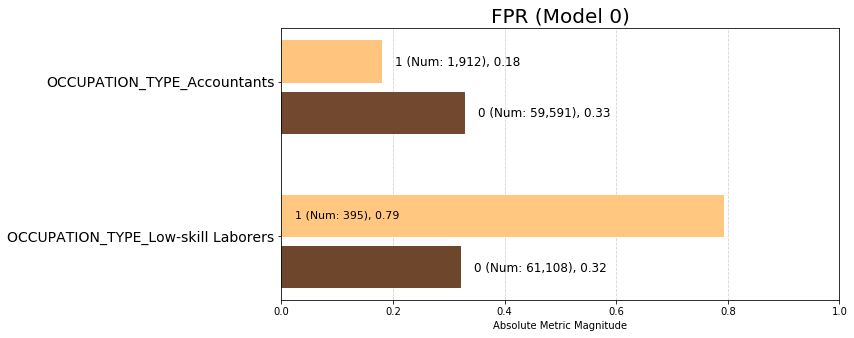

In [133]:
from aequitas.group import Group
from aequitas.plotting import Plot 

crosstab, _ = Group().get_crosstabs(df_bias)
FPR_plot = Plot().plot_group_metric(crosstab, 'fpr')

**CONCLUSION:**
- Avant d'analyser le biais, on constate que les effectifs de la modalité "1" des deux variables sont bien plus faibles que les effectifs des modalités "0" ce qu'on avait déjà remarqué.
- Malgré les différences d'effectifs, il y a des écarts significatifs de proportions de faux positifs dans les deux cas.
- Pour la variable **OCCUPATION_TYPE_Low-skill Laborers**, le modèle commet beaucoup d'erreurs: **il prédit 80% de faux positifs. Il est donc clair que le modèle a tendance à être injuste pour les personnes *Low-skill Laborers*.**
- Pour la variable **OCCUPATION_TYPE_Accountants**, le modèle semble être plus performant car il ne prédit que 18% de faux positifs.
- On constate également que le FPR est identique pour les modalités "0" des deux variables: 0.33.